## Final Project: Self Supervised Pretraining in Diabetic Retinopathy Detection



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import numpy as np
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split, SubsetRandomSampler, RandomSampler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold, train_test_split
import random
import os
from math import *
from collections import namedtuple
from functools import partial
import transformers
import matplotlib.animation
from IPython.display import HTML
from IPython.display import clear_output
import time
from google.colab import drive
import glob
from PIL import Image
import albumentations as ab
import torchvision.models as models
import cv2
import pandas as pd

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.50G/9.51G [01:39<00:00, 165MB/s]
100% 9.51G/9.51G [01:39<00:00, 103MB/s]


In [ ]:
!unzip "aptos2019-blindness-detection.zip"

Streaming output truncated to the last 5000 lines.
  inflating: test_images/512beaada8f0.png  
  inflating: test_images/51323e9d2070.png  
  inflating: test_images/515675001b9e.png  
  inflating: test_images/515877da2def.png  
  inflating: test_images/5168ddccea88.png  
  inflating: test_images/5172c056a687.png  
  inflating: test_images/5177461f5339.png  
  inflating: test_images/51910bcb980d.png  
  inflating: test_images/51a3e9b6a1c0.png  
  inflating: test_images/51bbd82feec8.png  
  inflating: test_images/51de5fb8eccd.png  
  inflating: test_images/51e88694c81f.png  
  inflating: test_images/51f0bf8f1544.png  
  inflating: test_images/51f57fb32840.png  
  inflating: test_images/51fa42dc1415.png  
  inflating: test_images/5276ab33b7b0.png  
  inflating: test_images/52a353760f72.png  
  inflating: test_images/531937254e73.png  
  inflating: test_images/5325b1c22c61.png  
  inflating: test_images/53959e0a750b.png  
  inflating: test_images/53be22c72713.png  
  inflating: test_images/

# Part 1: Baseline Model
The baseline model can be approached in one of 2 ways, as alluded to in the brain tumor segmentation downstream task. One approach is to train the model from scratch on the downstream task, initialized from random weights. The second approach is to leverage supervised pretraining as against a self-supervised pretraining.

In [ ]:
class FinetuningDataset(Dataset):
    def __init__(self, df_data, size, data_dir, transform=None):
        super().__init__()
        self.size = size
        self.df = df_data.iloc[:size]
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        img_name,label = self.df.iloc[index]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)

        img = np.asarray(image, dtype="float32")
        img /= 255

        if label == 0:
          label = [1, 0, 0, 0, 0]
        elif label == 1:
          label = [1, 1, 0, 0, 0]
        elif label == 2:
          label = [1, 1, 1, 0, 0]
        elif label == 3:
          label = [1, 1, 1, 1, 0]
        elif label == 4:
          label = [1, 1, 1, 1, 1]
        label = np.array(label)

        return img, label

csv_dir = '/content/train.csv'
data_dir = '/content/train_images'
train_df = pd.read_csv(csv_dir)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224))])
size = 600
finetuning_dataset = FinetuningDataset(train_df, size, data_dir, transform)

3662 500


In [ ]:
class CustomDenseNet(nn.Module):
    def __init__(self, pooling='avg'):
        super(CustomDenseNet, self).__init__()
        self.densenet = models.densenet121(pretrained=False, progress=True)

        # Convert all parameters and layers to float
        self.densenet = self.densenet.float()

        # Exclude the top layer (usually Global Average Pooling and Fully Connected layers)
        self.densenet = nn.Sequential(*list(self.densenet.children())[:-1])

        if pooling == 'avg':
            self.pooling = nn.AdaptiveAvgPool2d(1)
        elif pooling == 'max':
            self.pooling = nn.AdaptiveMaxPool2d(1)
        else:
            raise ValueError("Pooling should be 'avg' or 'max'")

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)

        x = x.float()

        features = self.densenet(x)
        pooled_features = self.pooling(features)
        pooled_features = pooled_features.view(pooled_features.size(0), -1)
        return pooled_features

In [ ]:

class BaselineModel(nn.Module):
    def __init__(self, encoder_model, prediction_model):
        super(BaselineModel, self).__init__()
        self.encoder_model = encoder_model
        self.prediction_model = prediction_model

    def forward(self, x):
        encoded_features = self.encoder_model(x)
        print(encoded_features.size())
        predicted_output = self.prediction_model(encoded_features)
        return predicted_output

class SimpleMultiClass(nn.Module):
    def __init__(self, input_size, num_classes=5, dropout_rate=0.5, include_top=True):
        super(SimpleMultiClass, self).__init__()
        self.include_top = include_top

        self.fc1 = nn.Linear(input_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(dropout_rate)
        self.sigmoid = nn.Sigmoid()

        if include_top:
            self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)

        if self.include_top:
            x = self.sigmoid(self.fc2(x))

        return x

# Set the device to GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder_model = CustomDenseNet()
prediction_model = SimpleMultiClass(1024)
baseline_model = BaselineModel(encoder_model, prediction_model)

# Applies 5-fold cross-validation to baseline model
def fine_tune(pre_trained_model, dataset):
    num_epochs = 5
    batch_size = 32
    lr = 0.00001
    val_accs = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for epoch in range(num_epochs):
      val_acc = 0
      for fold, (train_idx, valid_idx) in enumerate(kf.split(dataset)):
          print(f"Fold {fold + 1}")

          # Create DataLoader for training and validation
          train_sampler = RandomSampler(train_idx)
          valid_sampler = RandomSampler(valid_idx)
          train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
          valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

          criterion = nn.BCELoss()
          optimizer = optim.Adam(baseline_model.parameters(), lr=lr)

          # Training loop
          baseline_model.train()

          running_loss = 0.0
          for inputs, targets in tqdm(train_loader):
              optimizer.zero_grad()
              outputs = baseline_model(inputs)
              targets = targets.float()
              targets = targets.to(device)
              outputs = outputs.to(device)
              loss = criterion(outputs, targets)
              loss.backward()
              optimizer.step()
              running_loss += loss.item()


          # Validation loop
          baseline_model.eval()
          total = 0
          val_loss = 0

          with torch.no_grad():
              for inputs, targets in tqdm(valid_loader):
                  outputs = baseline_model(inputs)
                  targets = targets.float()
                  targets = targets.to(device)
                  outputs = outputs.to(device)
                  val_loss += criterion(outputs, targets)
                  total += targets.size(0)

          val_acc += val_loss
          print(val_acc)
      val_acc = 100 - (val_acc/(10*5))*100
      val_accs.append(val_acc)
      print(val_accs)

      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}, Val_Acc: {val_acc}")

    return val_accs

baseline_val_accs = fine_tune(baseline_model, finetuning_dataset)

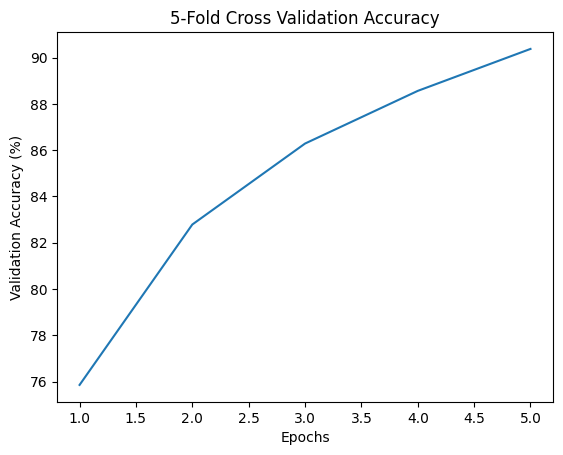

In [ ]:
baseline_arr = np.array([tensor.cpu().numpy() for tensor in baseline_val_accs])
epochs = [1,2,3,4,5]
plt.plot(epochs, baseline_arr)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.title('5-Fold Cross Validation Accuracy')
plt.savefig('baseline.pdf')
np.save('baseline.npy', baseline_arr)
plt.show()

# Part 2: Contrastive Predictive Coding
The goal of contrastive predictive coding is to learn representations by training the neural network to predict the representations of future observations from past ones. Applied to images, CPC predicts the representations of patches below a certain position from those above it, and evaluates the predictions using a contrastive loss. The CPC architecture relies on an encoder and context network. The context network is implemented as an autoregressive network using a GRU while the encoder network is implemented as

In [ ]:

os.chdir('/content/test_images')
os.getcwd()

'/content/test_images'

In [ ]:
class CPCDataset(Dataset):
  def __init__(self, crop_size, patches_per_side):
    self.image_names = sorted(os.listdir(os.getcwd()))[:1000]
    self.crop_size = crop_size
    self.patches_per_side = patches_per_side

  def __len__(self):
    return len( self.image_names)


  def __getitem__(self, idx):
    image_name = self.image_names[idx]

    #image to tensor
    image = Image.open(image_name)
    im_frame = image.resize((224, 224), resample=Image.LANCZOS)

    img = np.asarray(im_frame, dtype="float32")
    img /= 255
    img = img[np.newaxis, :, :, :]

    patches, labels = preprocess_grid_2d(preprocess_2d(img, self.crop_size, self.patches_per_side))

    return (patches[0], patches[1]), labels

In [ ]:

# Cropping & Padding Utilities
def crop_patches(image, is_training, patches_per_side, patch_jitter=0):
    h, w, _ = image.shape

    patch_overlap = - patch_jitter if patch_jitter < 0 else 0

    h_grid = (h - patch_overlap) // patches_per_side
    w_grid = (w - patch_overlap) // patches_per_side
    h_patch = h_grid - patch_jitter
    w_patch = w_grid - patch_jitter

    patches = []
    for i in range(patches_per_side):
        for j in range(patches_per_side):

            p = do_crop(image,
                        i * h_grid,
                        j * w_grid,
                        h_grid + patch_overlap,
                        w_grid + patch_overlap)

            if h_patch < h_grid or w_patch < w_grid:
                p = crop(p, is_training, [h_patch, w_patch])

            patches.append(p)

    return patches


def crop(image, is_training, crop_size):
    h, w, = crop_size[0], crop_size[1]
    h_old, w_old = image.shape[0], image.shape[1]

    if is_training:
        x = np.random.randint(0, 1+h_old-h)
        y = np.random.randint(0, 1+w_old-w)
    else:
        x = int((h_old - h) / 2)
        y = int((w_old - w) / 2)

    return do_crop(image, x, y, h, w)


def do_crop(image, x, y, h, w):
    # return ab.Crop(x, y, x + h, y + w)(image=image)["image"]
    return image[x:x + h, y:y + w, :]


def pad_to_final_size_2d(image, w):
    return ab.PadIfNeeded(w, w, border_mode=cv2.BORDER_CONSTANT, value=0)(image=image)["image"]

In [ ]:
# CPC Preprocessing
def preprocess_image(image, patch_jitter, patches_per_side, crop_size, is_training=True):
    result = []
    w, h, _ = image.shape

    if is_training:
        image = crop(image, is_training, (crop_size, crop_size))
        image = pad_to_final_size_2d(image, w)

    for patch in crop_patches(image, is_training, patches_per_side, patch_jitter):
        if is_training:
            normal_patch_size = patch.shape[0]
            patch_crop_size = int(normal_patch_size * (11.0 / 12.0))

            patch = crop(patch, is_training, (patch_crop_size, patch_crop_size))
            patch = pad_to_final_size_2d(patch, normal_patch_size)

        else:
            pass  # lets give it the most information we can get

        result.append(patch)

    return np.asarray(result)


def preprocess_2d(input, crop_size, patches_per_side, is_training=True):
    _, w, h, _ = input.shape

    patch_jitter = int(- w / (patches_per_side + 1))  # overlap half of the patch size
    return np.array([preprocess_image(image=image, patch_jitter=patch_jitter,
                                      patches_per_side=patches_per_side, crop_size=crop_size,
                                      is_training=is_training) for image in input])


def preprocess_grid_2d(image):
    patches_enc = []
    patches_pred = []
    labels = []

    shape = image.shape
    patch_size = int(sqrt(shape[1]))
    batch_size = shape[0]

    def get_patch_at(batch, x, y, mirror=False, predict_zero_instead_mirror=True):
        if batch < 0 or batch >= batch_size:
            return None

        if x < 0:
            if mirror:
                if predict_zero_instead_mirror:
                    return np.zeros(image[0, 0].shape)

                x = -x
            else:
                return None

        if y < 0:
            if mirror:
                if predict_zero_instead_mirror:
                    return np.zeros(image[0, 0].shape)

                y = -y
            else:
                return None

        if x >= patch_size:
            if mirror:
                if predict_zero_instead_mirror:
                    return np.zeros(image[0, 0].shape)

                x = 2 * (patch_size - 1) - x
            else:
                return None

        if y >= patch_size:
            if mirror:
                if predict_zero_instead_mirror:
                    return np.zeros(image[0, 0].shape)

                y = 2 * (patch_size - 1) - y
            else:
                return None

        return image[batch, x * patch_size + y]

    def get_patches_in_row(batch, x, x_start, y_start):
        y_min = y_start - (x_start - x)
        y_max = y_start + (x_start - x)

        patches = []
        for y in range(y_min, y_max + 1):
            patches.append(get_patch_at(batch, x, y, mirror=True))

        if x > 0:
            patches = get_patches_in_row(batch, x - 1, x_start, y_start) + patches

        return patches

    def get_patches_for(batch, x, y):
        me = get_patch_at(batch, x, y)
        others = get_patches_in_row(batch, x - 1, x, y)
        return others + [me]

    def get_following_patches(batch, x, y):
        me = get_patch_at(batch, x, y)
        if me is None:
            return []

        others = [me] + get_following_patches(batch, x + 1, y)
        return others

    end_patch_index = int(patch_size / 2) - 1  # this is the last index of the terms
    for batch_index in range(batch_size):
        for col_index in range(patch_size):
            # positive example
            terms = get_patches_for(batch_index, end_patch_index, col_index)
            predict_terms = get_following_patches(batch_index, end_patch_index + 2, col_index)
            patches_enc.append(np.stack(terms))
            patches_pred.append(np.stack(predict_terms))
            labels.append(1)

            # negative example
            r_batch = batch_index
            r_col = col_index

            while r_batch == batch_index and r_col == col_index:
                r_batch = np.random.randint(batch_size)
                r_col = np.random.randint(patch_size)

            predict_terms = get_following_patches(r_batch, end_patch_index + 2, r_col)
            patches_enc.append(np.stack(terms))
            patches_pred.append(np.stack(predict_terms))
            labels.append(0)

    return [np.stack(patches_enc), np.stack(patches_pred)], np.array(labels)

In [ ]:
class TimeDistributed(nn.Module):
    def __init__(self, module):
        super(TimeDistributed, self).__init__()
        self.module = module

    def forward(self, x):
        """
        Applies the module to each time step in the input tensor.
        """
        batch_size, samples, num_steps = x.size(0), x.size(1), x.size(2)
        # Reshape to combine batch and time dimensions
        x_reshape = x.view(-1, *x.size()[3:])

        # Apply the module to each time step
        output_reshape = self.module(x_reshape)

        # Reshape back to original shape
        output = output_reshape.view(batch_size*samples, num_steps, *output_reshape.size()[1:])

        return output

class NetworkAutoregressive(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NetworkAutoregressive, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)

    def forward(self, x):
        output, hidden = self.gru(x)

        return output[:, -1, :]

class NetworkPrediction(nn.Module):
    def __init__(self, code_size, predict_terms):
        super(NetworkPrediction, self).__init__()
        hidden_size = 256
        self.predict_terms = predict_terms
        self.initial_output = nn.Linear(in_features=hidden_size, out_features=code_size)
        self.outputs = nn.ModuleList([
            nn.Linear(code_size, code_size) for _ in range(predict_terms - 1)
        ])

    def forward(self, context):
        context = self.initial_output(context)
        outputs = [output(context) for output in self.outputs]
        outputs = [context] + outputs
        if len(outputs) == 1:
            output = torch.unsqueeze(outputs[0], dim=1)
        else:
            output = torch.stack(outputs, dim=1)
        return output

class CPCLayer(nn.Module):
    def __init__(self):
        super(CPCLayer, self).__init__()

    def forward(self, inputs):
        preds, y_encoded = inputs
        dot_product = torch.mean(y_encoded * preds, dim=-1)
        dot_product = torch.mean(dot_product, dim=-1)
        dot_product_probs = torch.sigmoid(dot_product)

        return dot_product_probs

    # Define a function to get output shape
    def get_output_shape(self, input_shape):
        return (input_shape[0][0], 1)

class ApplyPredictionModelToEncoder(nn.Module):
    def __init__(self, encoder_model, terms, image_size, number_channels, code_size, predict_terms, samples):
        super(ApplyPredictionModelToEncoder, self).__init__()
        self.encoder_model = encoder_model
        self.terms = terms
        self.image_size = image_size
        self.number_channels = number_channels
        self.code_size = code_size
        self.predict_terms = predict_terms
        self.cpc_layer = CPCLayer()

        input_size = self.terms * self.image_size * self.image_size * self.number_channels
        self.model_with_embed_dim = nn.Sequential(
            encoder_model,
            nn.Flatten(),
            nn.Linear(self.code_size, self.code_size)
        )
        self.time_distributed = TimeDistributed(self.model_with_embed_dim)
        hidden_size = 256
        self.network_autoregressive = NetworkAutoregressive(self.code_size, hidden_size)  # hidden_size = 256
        self.network_prediction = NetworkPrediction(code_size, predict_terms)

    def forward(self, x_input, y_input):
        batch_size = x_input.size(0)
        patches = x_input.size(1)
        x_encoded = self.time_distributed(x_input)
        context = self.network_autoregressive(x_encoded)
        preds = self.network_prediction(context)
        preds = preds.view(batch_size, patches, 2, self.code_size)

        y_encoded = self.time_distributed(y_input)
        y_encoded = y_encoded.view(batch_size, patches, 2, self.code_size)
        dot_product_probs = self.cpc_layer([preds, y_encoded])

        return dot_product_probs


In [ ]:
# Pre-training
# Essential Global Variables
crop_size = 224
patches_per_side = 5
code_size = 1024
data_dim = 224
number_channels = 3
prep_train = lambda x: preprocess_grid_2d(preprocess_2d(x, crop_size, patches_per_side))
test_data = np.zeros((3, data_dim, data_dim, number_channels), dtype=np.float32)

test_x = prep_train(test_data)[0]
test_y = prep_train(test_data)[1]
samples = test_x[0].shape[0]
terms = test_x[0].shape[1]
image_size = test_x[0].shape[2]
predict_terms = test_x[1].shape[1]

img_shape = (image_size, image_size, number_channels)

preprocess_dataset = CPCDataset(224, 5)
train_ratio = 0.95
val_ratio = 0.05
train_size = int(train_ratio * len(preprocess_dataset))
val_size = ceil(val_ratio * len(preprocess_dataset))
print(len(preprocess_dataset), train_size, val_size)
train_dataset, val_dataset = random_split(preprocess_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=15, shuffle=False)

# Set the device to GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_shape = samples*terms
encoder_model = CustomDenseNet("max")
cpc_model = ApplyPredictionModelToEncoder(encoder_model, terms, image_size, number_channels, code_size, predict_terms, samples)
criterion = nn.BCELoss()
optimizer = optim.Adam(cpc_model.parameters(), lr=1e-5)

cpc_model.to(device)

def train_model():
    # Training loop
    num_epochs = 15
    for epoch in range(num_epochs):
        cpc_model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for (x, y), target in tqdm(train_loader):
            x, y = x.to(device), y.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            pred = cpc_model(x, y)

            # Calculate loss
            target = target.float()
            target = target.to(device)
            pred = pred.to(device)
            loss = criterion(pred, target)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = pred.max(1)
            train_total += target.size(0)
            print(train_loss)

        train_loss *= 100
        print(train_loss)

        cpc_model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for (x, y), target in tqdm(val_loader):
                x, y = x.to(device), y.to(device)
                outputs = cpc_model(x, y)
                target = target.float()
                target = target.to(device)
                outputs = outputs.to(device)
                loss = criterion(outputs, target)

                val_loss += loss.item()
                val_total += target.size(0)

        val_loss *= 100

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}"
              f"Val Loss: {val_loss:.4f}")

train_model()

1000 950 50


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
  2%|▏         | 1/64 [00:06<06:45,  6.44s/it]

0.6931031346321106


  3%|▎         | 2/64 [00:11<05:54,  5.71s/it]

1.3862179517745972


  5%|▍         | 3/64 [00:16<05:32,  5.46s/it]

2.079253137111664


  6%|▋         | 4/64 [00:21<05:16,  5.28s/it]

2.7722493410110474


  8%|▊         | 5/64 [00:26<04:57,  5.04s/it]

3.4653173685073853


  9%|▉         | 6/64 [00:31<04:47,  4.96s/it]

4.1583826541900635


 11%|█         | 7/64 [00:36<04:46,  5.03s/it]

4.851405024528503


 12%|█▎        | 8/64 [00:41<04:41,  5.03s/it]

5.544437646865845


 14%|█▍        | 9/64 [00:46<04:36,  5.03s/it]

6.237439572811127


 16%|█▌        | 10/64 [00:51<04:37,  5.14s/it]

6.930279016494751


 17%|█▋        | 11/64 [00:57<04:35,  5.20s/it]

7.623348414897919


 19%|█▉        | 12/64 [01:01<04:18,  4.98s/it]

8.316167771816254


 20%|██        | 13/64 [01:06<04:18,  5.08s/it]

9.008842647075653


 22%|██▏       | 14/64 [01:12<04:13,  5.07s/it]

9.701695144176483


 23%|██▎       | 15/64 [01:16<04:04,  4.98s/it]

10.394295394420624


 25%|██▌       | 16/64 [01:22<04:03,  5.07s/it]

11.086870968341827


 27%|██▋       | 17/64 [01:27<03:57,  5.05s/it]

11.779715597629547


 28%|██▊       | 18/64 [01:31<03:49,  4.99s/it]

12.47265774011612


 30%|██▉       | 19/64 [01:36<03:37,  4.84s/it]

13.165338516235352


 31%|███▏      | 20/64 [01:41<03:32,  4.83s/it]

13.85869026184082


 33%|███▎      | 21/64 [01:46<03:30,  4.88s/it]

14.55123233795166


 34%|███▍      | 22/64 [01:50<03:20,  4.78s/it]

15.243762910366058


 36%|███▌      | 23/64 [01:55<03:17,  4.81s/it]

15.936534762382507


 38%|███▊      | 24/64 [02:00<03:10,  4.75s/it]

16.628416776657104


 39%|███▉      | 25/64 [02:05<03:09,  4.85s/it]

17.3212548494339


 41%|████      | 26/64 [02:10<03:06,  4.92s/it]

18.01406866312027


 42%|████▏     | 27/64 [02:15<03:03,  4.96s/it]

18.706545770168304


 44%|████▍     | 28/64 [02:20<02:55,  4.88s/it]

19.399393558502197


 45%|████▌     | 29/64 [02:24<02:49,  4.86s/it]

20.09202206134796


 47%|████▋     | 30/64 [02:29<02:45,  4.88s/it]

20.78529977798462


 48%|████▊     | 31/64 [02:34<02:39,  4.84s/it]

21.47742933034897


 50%|█████     | 32/64 [02:40<02:40,  5.02s/it]

22.17013245820999


 52%|█████▏    | 33/64 [02:45<02:37,  5.08s/it]

22.862085342407227


 53%|█████▎    | 34/64 [02:50<02:35,  5.18s/it]

23.553978264331818


 55%|█████▍    | 35/64 [02:55<02:25,  5.01s/it]

24.246103525161743


 56%|█████▋    | 36/64 [02:59<02:15,  4.86s/it]

24.937992930412292


 58%|█████▊    | 37/64 [03:04<02:07,  4.74s/it]

25.630554258823395


 59%|█████▉    | 38/64 [03:09<02:05,  4.81s/it]

26.32257229089737


 61%|██████    | 39/64 [03:14<02:04,  4.97s/it]

27.014350593090057


 62%|██████▎   | 40/64 [03:19<01:59,  5.00s/it]

27.70638543367386


 64%|██████▍   | 41/64 [03:24<01:54,  4.96s/it]

28.398142755031586


 66%|██████▌   | 42/64 [03:29<01:50,  5.01s/it]

29.09109354019165


 67%|██████▋   | 43/64 [03:34<01:44,  4.97s/it]

29.782548189163208


 69%|██████▉   | 44/64 [03:39<01:39,  4.98s/it]

30.474912226200104


 70%|███████   | 45/64 [03:44<01:33,  4.92s/it]

31.166772484779358


 72%|███████▏  | 46/64 [03:49<01:27,  4.86s/it]

31.85939759016037


 73%|███████▎  | 47/64 [03:53<01:21,  4.82s/it]

32.55210465192795


 75%|███████▌  | 48/64 [03:58<01:18,  4.92s/it]

33.2431937456131


 77%|███████▋  | 49/64 [04:04<01:14,  4.98s/it]

33.93593370914459


 78%|███████▊  | 50/64 [04:08<01:08,  4.86s/it]

34.62894254922867


 80%|███████▉  | 51/64 [04:13<01:04,  4.94s/it]

35.32120341062546


 81%|████████▏ | 52/64 [04:18<01:00,  5.00s/it]

36.01278108358383


 83%|████████▎ | 53/64 [04:24<00:55,  5.04s/it]

36.70483124256134


 84%|████████▍ | 54/64 [04:28<00:49,  4.99s/it]

37.39592897891998


 86%|████████▌ | 55/64 [04:33<00:44,  4.93s/it]

38.08716922998428


 88%|████████▊ | 56/64 [04:38<00:39,  4.89s/it]

38.777938425540924


 89%|████████▉ | 57/64 [04:43<00:34,  4.91s/it]

39.47022861242294


 91%|█████████ | 58/64 [04:48<00:29,  4.95s/it]

40.1617625951767


 92%|█████████▏| 59/64 [04:53<00:24,  4.91s/it]

40.85260075330734


 94%|█████████▍| 60/64 [04:58<00:19,  4.90s/it]

41.544530272483826


 95%|█████████▌| 61/64 [05:02<00:14,  4.88s/it]

42.23456335067749


 97%|█████████▋| 62/64 [05:07<00:09,  4.85s/it]

42.92549383640289


 98%|█████████▊| 63/64 [05:12<00:04,  4.91s/it]

43.615741431713104


100%|██████████| 64/64 [05:14<00:00,  4.91s/it]


44.30796432495117
4430.796432495117


100%|██████████| 4/4 [00:03<00:00,  1.20it/s]


Epoch 1/15 - Train Loss: 4430.7964Val Loss: 276.2336


  2%|▏         | 1/64 [00:04<05:05,  4.85s/it]

0.6902762055397034


  3%|▎         | 2/64 [00:09<04:54,  4.75s/it]

1.3785229325294495


  5%|▍         | 3/64 [00:14<04:56,  4.86s/it]

2.069356083869934


  6%|▋         | 4/64 [00:19<04:47,  4.79s/it]

2.7607056498527527


  8%|▊         | 5/64 [00:23<04:40,  4.75s/it]

3.452086091041565


  9%|▉         | 6/64 [00:28<04:38,  4.80s/it]

4.1424930691719055


 11%|█         | 7/64 [00:33<04:36,  4.86s/it]

4.832702398300171


 12%|█▎        | 8/64 [00:38<04:29,  4.82s/it]

5.523063957691193


 14%|█▍        | 9/64 [00:43<04:32,  4.95s/it]

6.210678696632385


 16%|█▌        | 10/64 [00:48<04:26,  4.93s/it]

6.899859607219696


 17%|█▋        | 11/64 [00:53<04:17,  4.86s/it]

7.587916553020477


 19%|█▉        | 12/64 [00:58<04:15,  4.91s/it]

8.277135848999023


 20%|██        | 13/64 [01:02<04:06,  4.82s/it]

8.968927323818207


 22%|██▏       | 14/64 [01:07<04:02,  4.86s/it]

9.659006536006927


 23%|██▎       | 15/64 [01:12<03:58,  4.87s/it]

10.35146939754486


 25%|██▌       | 16/64 [01:17<03:55,  4.92s/it]

11.038665533065796


 27%|██▋       | 17/64 [01:22<03:48,  4.86s/it]

11.728732585906982


 28%|██▊       | 18/64 [01:27<03:42,  4.83s/it]

12.418867945671082


 30%|██▉       | 19/64 [01:32<03:37,  4.84s/it]

13.105844378471375


 31%|███▏      | 20/64 [01:37<03:35,  4.90s/it]

13.797807037830353


 33%|███▎      | 21/64 [01:41<03:27,  4.82s/it]

14.487117946147919


 34%|███▍      | 22/64 [01:46<03:20,  4.77s/it]

15.176499247550964


 36%|███▌      | 23/64 [01:51<03:16,  4.80s/it]

15.865008294582367


 38%|███▊      | 24/64 [01:55<03:09,  4.73s/it]

16.551227509975433


 39%|███▉      | 25/64 [02:00<03:05,  4.75s/it]

17.239353358745575


 41%|████      | 26/64 [02:05<03:01,  4.77s/it]

17.9330552816391


 42%|████▏     | 27/64 [02:10<03:01,  4.90s/it]

18.625027239322662


 44%|████▍     | 28/64 [02:15<02:55,  4.88s/it]

19.311579287052155


 45%|████▌     | 29/64 [02:20<02:46,  4.75s/it]

20.001412093639374


 47%|████▋     | 30/64 [02:24<02:42,  4.79s/it]

20.688339173793793


 48%|████▊     | 31/64 [02:29<02:37,  4.78s/it]

21.378329038619995


 50%|█████     | 32/64 [02:35<02:38,  4.96s/it]

22.06296557188034


 52%|█████▏    | 33/64 [02:40<02:36,  5.04s/it]

22.75340747833252


 53%|█████▎    | 34/64 [02:45<02:32,  5.08s/it]

23.44040870666504


 55%|█████▍    | 35/64 [02:50<02:23,  4.96s/it]

24.128132224082947


 56%|█████▋    | 36/64 [02:54<02:15,  4.85s/it]

24.81322532892227


 58%|█████▊    | 37/64 [02:59<02:12,  4.92s/it]

25.496019661426544


 59%|█████▉    | 38/64 [03:04<02:06,  4.87s/it]

26.181556165218353


 61%|██████    | 39/64 [03:09<02:03,  4.92s/it]

26.869792580604553


 62%|██████▎   | 40/64 [03:14<01:58,  4.95s/it]

27.5581613779068


 64%|██████▍   | 41/64 [03:19<01:52,  4.90s/it]

28.24256408214569


 66%|██████▌   | 42/64 [03:24<01:49,  4.99s/it]

28.926677882671356


 67%|██████▋   | 43/64 [03:29<01:41,  4.82s/it]

29.610393702983856


 69%|██████▉   | 44/64 [03:33<01:37,  4.86s/it]

30.30026340484619


 70%|███████   | 45/64 [03:38<01:30,  4.78s/it]

30.989165484905243


 72%|███████▏  | 46/64 [03:43<01:25,  4.77s/it]

31.674237430095673


 73%|███████▎  | 47/64 [03:48<01:25,  5.00s/it]

32.36490273475647


 75%|███████▌  | 48/64 [03:53<01:18,  4.91s/it]

33.04837667942047


 77%|███████▋  | 49/64 [03:58<01:14,  4.95s/it]

33.73075556755066


 78%|███████▊  | 50/64 [04:03<01:07,  4.82s/it]

34.410243690013885


 80%|███████▉  | 51/64 [04:07<01:01,  4.76s/it]

35.10081499814987


 81%|████████▏ | 52/64 [04:12<00:57,  4.78s/it]

35.78614366054535


 83%|████████▎ | 53/64 [04:17<00:52,  4.76s/it]

36.46969002485275


 84%|████████▍ | 54/64 [04:22<00:48,  4.90s/it]

37.15119934082031


 86%|████████▌ | 55/64 [04:27<00:44,  4.98s/it]

37.83901000022888


 88%|████████▊ | 56/64 [04:32<00:40,  5.04s/it]

38.52637583017349


 89%|████████▉ | 57/64 [04:37<00:34,  4.98s/it]

39.211136400699615


 91%|█████████ | 58/64 [04:43<00:30,  5.15s/it]

39.89559590816498


 92%|█████████▏| 59/64 [04:48<00:25,  5.08s/it]

40.58032786846161


 94%|█████████▍| 60/64 [04:52<00:19,  4.93s/it]

41.265038192272186


 95%|█████████▌| 61/64 [04:57<00:14,  4.99s/it]

41.95188653469086


 97%|█████████▋| 62/64 [05:03<00:10,  5.10s/it]

42.63118314743042


 98%|█████████▊| 63/64 [05:08<00:05,  5.14s/it]

43.319162249565125


100%|██████████| 64/64 [05:09<00:00,  4.84s/it]


44.01556313037872
4401.556313037872


100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


Epoch 2/15 - Train Loss: 4401.5563Val Loss: 271.7649


  2%|▏         | 1/64 [00:04<05:03,  4.81s/it]

0.6790298223495483


  3%|▎         | 2/64 [00:09<05:08,  4.98s/it]

1.3589574098587036


  5%|▍         | 3/64 [00:14<04:52,  4.80s/it]

2.037870466709137


  6%|▋         | 4/64 [00:19<04:51,  4.86s/it]

2.720878303050995


  8%|▊         | 5/64 [00:24<04:46,  4.85s/it]

3.4012668132781982


  9%|▉         | 6/64 [00:28<04:36,  4.76s/it]

4.086679637432098


 11%|█         | 7/64 [00:33<04:36,  4.85s/it]

4.763209223747253


 12%|█▎        | 8/64 [00:38<04:25,  4.73s/it]

5.4511414766311646


 14%|█▍        | 9/64 [00:43<04:19,  4.71s/it]

6.140577912330627


 16%|█▌        | 10/64 [00:48<04:22,  4.86s/it]

6.830047607421875


 17%|█▋        | 11/64 [00:53<04:19,  4.90s/it]

7.510398983955383


 19%|█▉        | 12/64 [00:58<04:14,  4.90s/it]

8.184689939022064


 20%|██        | 13/64 [01:03<04:10,  4.91s/it]

8.855711579322815


 22%|██▏       | 14/64 [01:08<04:08,  4.97s/it]

9.544351935386658


 23%|██▎       | 15/64 [01:12<03:58,  4.87s/it]

10.234373390674591


 25%|██▌       | 16/64 [01:18<03:58,  4.97s/it]

10.912178874015808


 27%|██▋       | 17/64 [01:23<03:56,  5.03s/it]

11.582590341567993


 28%|██▊       | 18/64 [01:28<03:49,  4.99s/it]

12.256751894950867


 30%|██▉       | 19/64 [01:33<03:44,  4.99s/it]

12.930069208145142


 31%|███▏      | 20/64 [01:37<03:37,  4.94s/it]

13.600577771663666


 33%|███▎      | 21/64 [01:42<03:27,  4.82s/it]

14.280599236488342


 34%|███▍      | 22/64 [01:47<03:25,  4.88s/it]

14.94732666015625


 36%|███▌      | 23/64 [01:52<03:19,  4.87s/it]

15.61338585615158


 38%|███▊      | 24/64 [01:56<03:11,  4.78s/it]

16.28447598218918


 39%|███▉      | 25/64 [02:02<03:11,  4.91s/it]

16.964497208595276


 41%|████      | 26/64 [02:07<03:07,  4.92s/it]

17.635054290294647


 42%|████▏     | 27/64 [02:11<03:01,  4.91s/it]

18.314796805381775


 44%|████▍     | 28/64 [02:16<02:55,  4.89s/it]

18.99084347486496


 45%|████▌     | 29/64 [02:21<02:47,  4.79s/it]

19.6523996591568


 47%|████▋     | 30/64 [02:26<02:41,  4.76s/it]

20.326458632946014


 48%|████▊     | 31/64 [02:30<02:35,  4.70s/it]

21.01319044828415


 50%|█████     | 32/64 [02:35<02:36,  4.89s/it]

21.67468523979187


 52%|█████▏    | 33/64 [02:40<02:29,  4.83s/it]

22.352519154548645


 53%|█████▎    | 34/64 [02:45<02:25,  4.84s/it]

23.013081431388855


 55%|█████▍    | 35/64 [02:50<02:24,  5.00s/it]

23.68645268678665


 56%|█████▋    | 36/64 [02:56<02:22,  5.10s/it]

24.35680788755417


 58%|█████▊    | 37/64 [03:01<02:16,  5.05s/it]

25.041484594345093


 59%|█████▉    | 38/64 [03:06<02:13,  5.12s/it]

25.69682651758194


 61%|██████    | 39/64 [03:10<02:04,  4.97s/it]

26.36351650953293


 62%|██████▎   | 40/64 [03:15<01:58,  4.92s/it]

27.02298665046692


 64%|██████▍   | 41/64 [03:20<01:52,  4.90s/it]

27.699681520462036


 66%|██████▌   | 42/64 [03:25<01:47,  4.88s/it]

28.37470155954361


 67%|██████▋   | 43/64 [03:30<01:43,  4.92s/it]

29.058905363082886


 69%|██████▉   | 44/64 [03:35<01:36,  4.82s/it]

29.730544567108154


 70%|███████   | 45/64 [03:40<01:34,  4.96s/it]

30.37747621536255


 72%|███████▏  | 46/64 [03:44<01:27,  4.85s/it]

31.029940903186798


 73%|███████▎  | 47/64 [03:49<01:22,  4.84s/it]

31.69274890422821


 75%|███████▌  | 48/64 [03:54<01:17,  4.81s/it]

32.37867343425751


 77%|███████▋  | 49/64 [03:59<01:11,  4.76s/it]

33.03678095340729


 78%|███████▊  | 50/64 [04:04<01:07,  4.79s/it]

33.70826435089111


 80%|███████▉  | 51/64 [04:09<01:04,  4.93s/it]

34.373582541942596


 81%|████████▏ | 52/64 [04:14<00:59,  4.95s/it]

35.042028963565826


 83%|████████▎ | 53/64 [04:19<00:54,  5.00s/it]

35.71757084131241


 84%|████████▍ | 54/64 [04:24<00:49,  4.92s/it]

36.36858773231506


 86%|████████▌ | 55/64 [04:29<00:44,  4.94s/it]

37.04247468709946


 88%|████████▊ | 56/64 [04:33<00:38,  4.84s/it]

37.708582282066345


 89%|████████▉ | 57/64 [04:38<00:34,  4.93s/it]

38.3714314699173


 91%|█████████ | 58/64 [04:43<00:29,  4.96s/it]

39.023015797138214


 92%|█████████▏| 59/64 [04:48<00:24,  4.89s/it]

39.68587106466293


 94%|█████████▍| 60/64 [04:53<00:19,  4.86s/it]

40.3358017206192


 95%|█████████▌| 61/64 [04:58<00:14,  4.89s/it]

40.99096459150314


 97%|█████████▋| 62/64 [05:03<00:09,  4.88s/it]

41.67337131500244


 98%|█████████▊| 63/64 [05:08<00:04,  4.95s/it]

42.33114516735077


100%|██████████| 64/64 [05:09<00:00,  4.84s/it]


43.02597713470459
4302.597713470459


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Epoch 3/15 - Train Loss: 4302.5977Val Loss: 260.3450


  2%|▏         | 1/64 [00:05<05:29,  5.23s/it]

0.6725769639015198


  3%|▎         | 2/64 [00:10<05:10,  5.01s/it]

1.3097321391105652


  5%|▍         | 3/64 [00:15<05:05,  5.01s/it]

1.9512745141983032


  6%|▋         | 4/64 [00:20<05:00,  5.00s/it]

2.5895156264305115


  8%|▊         | 5/64 [00:25<04:57,  5.04s/it]

3.2289544343948364


  9%|▉         | 6/64 [00:29<04:45,  4.93s/it]

3.9027363657951355


 11%|█         | 7/64 [00:34<04:42,  4.96s/it]

4.556825041770935


 12%|█▎        | 8/64 [00:39<04:36,  4.93s/it]

5.216088593006134


 14%|█▍        | 9/64 [00:44<04:27,  4.87s/it]

5.8787038922309875


 16%|█▌        | 10/64 [00:49<04:22,  4.87s/it]

6.521505415439606


 17%|█▋        | 11/64 [00:54<04:18,  4.88s/it]

7.1761932373046875


 19%|█▉        | 12/64 [00:58<04:09,  4.80s/it]

7.8537299036979675


 20%|██        | 13/64 [01:03<04:01,  4.74s/it]

8.52564263343811


 22%|██▏       | 14/64 [01:08<03:56,  4.73s/it]

9.209184288978577


 23%|██▎       | 15/64 [01:13<03:53,  4.77s/it]

9.863020658493042


 25%|██▌       | 16/64 [01:18<03:56,  4.93s/it]

10.510826587677002


 27%|██▋       | 17/64 [01:23<03:55,  5.02s/it]

11.149069011211395


 28%|██▊       | 18/64 [01:28<03:48,  4.98s/it]

11.788079261779785


 30%|██▉       | 19/64 [01:33<03:40,  4.91s/it]

12.446558177471161


 31%|███▏      | 20/64 [01:38<03:37,  4.95s/it]

13.072503924369812


 33%|███▎      | 21/64 [01:43<03:29,  4.88s/it]

13.72782588005066


 34%|███▍      | 22/64 [01:48<03:26,  4.93s/it]

14.344157695770264


 36%|███▌      | 23/64 [01:53<03:23,  4.95s/it]

14.978145003318787


 38%|███▊      | 24/64 [01:57<03:15,  4.89s/it]

15.651294946670532


 39%|███▉      | 25/64 [02:03<03:17,  5.07s/it]

16.33163219690323


 41%|████      | 26/64 [02:08<03:09,  4.98s/it]

16.98634958267212


 42%|████▏     | 27/64 [02:13<03:04,  4.98s/it]

17.63537585735321


 44%|████▍     | 28/64 [02:18<02:59,  4.99s/it]

18.273740768432617


 45%|████▌     | 29/64 [02:22<02:51,  4.91s/it]

18.920939445495605


 47%|████▋     | 30/64 [02:27<02:47,  4.94s/it]

19.55912137031555


 48%|████▊     | 31/64 [02:32<02:42,  4.91s/it]

20.183322846889496


 50%|█████     | 32/64 [02:37<02:35,  4.86s/it]

20.842902660369873


 52%|█████▏    | 33/64 [02:42<02:30,  4.87s/it]

21.486582398414612


 53%|█████▎    | 34/64 [02:47<02:25,  4.86s/it]

22.146431148052216


 55%|█████▍    | 35/64 [02:52<02:23,  4.95s/it]

22.801371157169342


 56%|█████▋    | 36/64 [02:57<02:21,  5.05s/it]

23.46385395526886


 58%|█████▊    | 37/64 [03:03<02:20,  5.19s/it]

24.093562722206116


 59%|█████▉    | 38/64 [03:07<02:10,  5.02s/it]

24.737753808498383


 61%|██████    | 39/64 [03:12<02:04,  4.99s/it]

25.42265558242798


 62%|██████▎   | 40/64 [03:17<01:57,  4.91s/it]

26.054926335811615


 64%|██████▍   | 41/64 [03:22<01:54,  4.96s/it]

26.655769288539886


 66%|██████▌   | 42/64 [03:27<01:48,  4.95s/it]

27.30564308166504


 67%|██████▋   | 43/64 [03:32<01:42,  4.89s/it]

27.958411872386932


 69%|██████▉   | 44/64 [03:36<01:36,  4.85s/it]

28.63590395450592


 70%|███████   | 45/64 [03:41<01:32,  4.88s/it]

29.292802572250366


 72%|███████▏  | 46/64 [03:46<01:28,  4.91s/it]

29.925346076488495


 73%|███████▎  | 47/64 [03:51<01:24,  4.97s/it]

30.561111629009247


 75%|███████▌  | 48/64 [03:57<01:20,  5.02s/it]

31.181812167167664


 77%|███████▋  | 49/64 [04:01<01:15,  5.01s/it]

31.790819227695465


 78%|███████▊  | 50/64 [04:06<01:09,  5.00s/it]

32.44957369565964


 80%|███████▉  | 51/64 [04:11<01:03,  4.91s/it]

33.08132863044739


 81%|████████▏ | 52/64 [04:16<00:59,  4.96s/it]

33.7475608587265


 83%|████████▎ | 53/64 [04:21<00:53,  4.89s/it]

34.42823666334152


 84%|████████▍ | 54/64 [04:26<00:48,  4.80s/it]

35.06064701080322


 86%|████████▌ | 55/64 [04:30<00:43,  4.80s/it]

35.72405558824539


 88%|████████▊ | 56/64 [04:35<00:38,  4.81s/it]

36.34036010503769


 89%|████████▉ | 57/64 [04:40<00:33,  4.84s/it]

36.95396685600281


 91%|█████████ | 58/64 [04:45<00:29,  4.89s/it]

37.594494700431824


 92%|█████████▏| 59/64 [04:50<00:24,  4.92s/it]

38.23689389228821


 94%|█████████▍| 60/64 [04:55<00:20,  5.03s/it]

38.85535430908203


 95%|█████████▌| 61/64 [05:00<00:14,  4.85s/it]

39.51166373491287


 97%|█████████▋| 62/64 [05:05<00:09,  4.92s/it]

40.171176075935364


 98%|█████████▊| 63/64 [05:09<00:04,  4.81s/it]

40.841567158699036


100%|██████████| 64/64 [05:11<00:00,  4.87s/it]


41.48574471473694
4148.574471473694


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Epoch 4/15 - Train Loss: 4148.5745Val Loss: 251.3565


  2%|▏         | 1/64 [00:04<05:03,  4.82s/it]

0.6551193594932556


  3%|▎         | 2/64 [00:09<05:02,  4.87s/it]

1.325787901878357


  5%|▍         | 3/64 [00:14<04:59,  4.91s/it]

1.9454306960105896


  6%|▋         | 4/64 [00:19<04:59,  5.00s/it]

2.57311087846756


  8%|▊         | 5/64 [00:24<04:48,  4.89s/it]

3.2017863988876343


  9%|▉         | 6/64 [00:29<04:42,  4.87s/it]

3.81842702627182


 11%|█         | 7/64 [00:34<04:35,  4.83s/it]

4.435486912727356


 12%|█▎        | 8/64 [00:39<04:34,  4.89s/it]

5.072862029075623


 14%|█▍        | 9/64 [00:44<04:35,  5.00s/it]

5.752186596393585


 16%|█▌        | 10/64 [00:49<04:25,  4.91s/it]

6.371684372425079


 17%|█▋        | 11/64 [00:53<04:19,  4.90s/it]

6.993934512138367


 19%|█▉        | 12/64 [00:58<04:14,  4.90s/it]

7.64431232213974


 20%|██        | 13/64 [01:03<04:10,  4.92s/it]

8.288027048110962


 22%|██▏       | 14/64 [01:08<04:05,  4.91s/it]

8.935073494911194


 23%|██▎       | 15/64 [01:13<03:58,  4.87s/it]

9.562576055526733


 25%|██▌       | 16/64 [01:18<03:53,  4.87s/it]

10.195917010307312


 27%|██▋       | 17/64 [01:23<03:55,  5.00s/it]

10.834185361862183


 28%|██▊       | 18/64 [01:28<03:49,  4.98s/it]

11.468830585479736


 30%|██▉       | 19/64 [01:33<03:44,  4.99s/it]

12.083753049373627


 31%|███▏      | 20/64 [01:38<03:43,  5.08s/it]

12.721515953540802


 33%|███▎      | 21/64 [01:43<03:34,  4.98s/it]

13.357772648334503


 34%|███▍      | 22/64 [01:48<03:24,  4.88s/it]

13.97467291355133


 36%|███▌      | 23/64 [01:53<03:18,  4.85s/it]

14.618438005447388


 38%|███▊      | 24/64 [01:58<03:15,  4.89s/it]

15.227757632732391


 39%|███▉      | 25/64 [02:02<03:08,  4.83s/it]

15.849380731582642


 41%|████      | 26/64 [02:07<03:04,  4.86s/it]

16.46978610754013


 42%|████▏     | 27/64 [02:12<02:57,  4.81s/it]

17.086411893367767


 44%|████▍     | 28/64 [02:17<02:52,  4.78s/it]

17.72484666109085


 45%|████▌     | 29/64 [02:21<02:46,  4.77s/it]

18.397691905498505


 47%|████▋     | 30/64 [02:26<02:41,  4.75s/it]

19.056315302848816


 48%|████▊     | 31/64 [02:31<02:38,  4.80s/it]

19.680031061172485


 50%|█████     | 32/64 [02:36<02:33,  4.80s/it]

20.2921541929245


 52%|█████▏    | 33/64 [02:41<02:30,  4.86s/it]

20.904205679893494


 53%|█████▎    | 34/64 [02:46<02:26,  4.88s/it]

21.534176886081696


 55%|█████▍    | 35/64 [02:50<02:18,  4.79s/it]

22.172212660312653


 56%|█████▋    | 36/64 [02:55<02:13,  4.78s/it]

22.82380110025406


 58%|█████▊    | 37/64 [03:00<02:11,  4.86s/it]

23.44178456068039


 59%|█████▉    | 38/64 [03:05<02:05,  4.82s/it]

24.103674590587616


 61%|██████    | 39/64 [03:10<02:00,  4.84s/it]

24.73616635799408


 62%|██████▎   | 40/64 [03:15<01:57,  4.88s/it]

25.382985651493073


 64%|██████▍   | 41/64 [03:19<01:50,  4.81s/it]

26.039774775505066


 66%|██████▌   | 42/64 [03:24<01:44,  4.76s/it]

26.64825612306595


 67%|██████▋   | 43/64 [03:29<01:39,  4.74s/it]

27.29623556137085


 69%|██████▉   | 44/64 [03:34<01:35,  4.80s/it]

27.914417445659637


 70%|███████   | 45/64 [03:38<01:30,  4.75s/it]

28.550345182418823


 72%|███████▏  | 46/64 [03:43<01:25,  4.77s/it]

29.174296498298645


 73%|███████▎  | 47/64 [03:48<01:21,  4.80s/it]

29.777484357357025


 75%|███████▌  | 48/64 [03:53<01:18,  4.88s/it]

30.395447313785553


 77%|███████▋  | 49/64 [03:58<01:12,  4.83s/it]

31.040827810764313


 78%|███████▊  | 50/64 [04:02<01:07,  4.81s/it]

31.662580490112305


 80%|███████▉  | 51/64 [04:07<01:03,  4.89s/it]

32.26830726861954


 81%|████████▏ | 52/64 [04:13<01:00,  5.08s/it]

32.895040452480316


 83%|████████▎ | 53/64 [04:18<00:55,  5.03s/it]

33.52468252182007


 84%|████████▍ | 54/64 [04:23<00:50,  5.09s/it]

34.14977651834488


 86%|████████▌ | 55/64 [04:28<00:45,  5.09s/it]

34.80090719461441


 88%|████████▊ | 56/64 [04:33<00:40,  5.03s/it]

35.44978654384613


 89%|████████▉ | 57/64 [04:38<00:34,  4.97s/it]

36.06293112039566


 91%|█████████ | 58/64 [04:43<00:29,  4.98s/it]

36.662261605262756


 92%|█████████▏| 59/64 [04:48<00:24,  4.96s/it]

37.27977645397186


 94%|█████████▍| 60/64 [04:53<00:19,  4.94s/it]

37.88898456096649


 95%|█████████▌| 61/64 [04:58<00:14,  5.00s/it]

38.52657753229141


 97%|█████████▋| 62/64 [05:03<00:09,  5.00s/it]

39.15590715408325


 98%|█████████▊| 63/64 [05:08<00:04,  4.93s/it]

39.739253520965576


100%|██████████| 64/64 [05:10<00:00,  4.85s/it]


40.36312639713287
4036.3126397132874


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Epoch 5/15 - Train Loss: 4036.3126Val Loss: 243.5900


  2%|▏         | 1/64 [00:05<05:27,  5.20s/it]

0.6279628872871399


  3%|▎         | 2/64 [00:10<05:32,  5.36s/it]

1.2628419399261475


  5%|▍         | 3/64 [00:15<05:01,  4.95s/it]

1.8680106401443481


  6%|▋         | 4/64 [00:20<04:57,  4.96s/it]

2.4626538157463074


  8%|▊         | 5/64 [00:25<04:57,  5.05s/it]

3.0867050290107727


  9%|▉         | 6/64 [00:30<04:52,  5.05s/it]

3.679347276687622


 11%|█         | 7/64 [00:35<04:54,  5.17s/it]

4.317780435085297


 12%|█▎        | 8/64 [00:40<04:48,  5.15s/it]

4.92352557182312


 14%|█▍        | 9/64 [00:45<04:36,  5.03s/it]

5.531941115856171


 16%|█▌        | 10/64 [00:50<04:24,  4.90s/it]

6.128634572029114


 17%|█▋        | 11/64 [00:55<04:17,  4.85s/it]

6.732827186584473


 19%|█▉        | 12/64 [00:59<04:10,  4.82s/it]

7.320062935352325


 20%|██        | 13/64 [01:04<04:02,  4.76s/it]

7.9940608739852905


 22%|██▏       | 14/64 [01:09<04:00,  4.80s/it]

8.601059257984161


 23%|██▎       | 15/64 [01:13<03:53,  4.76s/it]

9.235251009464264


 25%|██▌       | 16/64 [01:18<03:46,  4.71s/it]

9.847030520439148


 27%|██▋       | 17/64 [01:23<03:43,  4.77s/it]

10.413406491279602


 28%|██▊       | 18/64 [01:28<03:43,  4.87s/it]

11.039970815181732


 30%|██▉       | 19/64 [01:33<03:39,  4.88s/it]

11.680944681167603


 31%|███▏      | 20/64 [01:38<03:37,  4.94s/it]

12.307555079460144


 33%|███▎      | 21/64 [01:43<03:32,  4.94s/it]

12.89593654870987


 34%|███▍      | 22/64 [01:48<03:29,  4.99s/it]

13.543192744255066


 36%|███▌      | 23/64 [01:53<03:24,  4.98s/it]

14.175059795379639


 38%|███▊      | 24/64 [01:58<03:14,  4.86s/it]

14.783680200576782


 39%|███▉      | 25/64 [02:03<03:12,  4.95s/it]

15.407422184944153


 41%|████      | 26/64 [02:08<03:06,  4.92s/it]

16.027782082557678


 42%|████▏     | 27/64 [02:13<03:03,  4.97s/it]

16.65905338525772


 44%|████▍     | 28/64 [02:17<02:55,  4.87s/it]

17.317966043949127


 45%|████▌     | 29/64 [02:22<02:50,  4.86s/it]

17.93720245361328


 47%|████▋     | 30/64 [02:27<02:45,  4.88s/it]

18.558502078056335


 48%|████▊     | 31/64 [02:32<02:40,  4.87s/it]

19.190262019634247


 50%|█████     | 32/64 [02:37<02:36,  4.91s/it]

19.797435879707336


 52%|█████▏    | 33/64 [02:42<02:32,  4.93s/it]

20.424949944019318


 53%|█████▎    | 34/64 [02:47<02:25,  4.84s/it]

21.029572188854218


 55%|█████▍    | 35/64 [02:51<02:18,  4.76s/it]

21.633534789085388


 56%|█████▋    | 36/64 [02:56<02:16,  4.87s/it]

22.238605797290802


 58%|█████▊    | 37/64 [03:01<02:13,  4.94s/it]

22.8515967130661


 59%|█████▉    | 38/64 [03:07<02:10,  5.01s/it]

23.427671134471893


 61%|██████    | 39/64 [03:12<02:07,  5.10s/it]

24.05371743440628


 62%|██████▎   | 40/64 [03:17<01:59,  4.98s/it]

24.679657876491547


 64%|██████▍   | 41/64 [03:22<01:56,  5.09s/it]

25.296676576137543


 66%|██████▌   | 42/64 [03:27<01:50,  5.01s/it]

25.886525094509125


 67%|██████▋   | 43/64 [03:32<01:44,  4.97s/it]

26.50475388765335


 69%|██████▉   | 44/64 [03:36<01:38,  4.95s/it]

27.09022730588913


 70%|███████   | 45/64 [03:41<01:31,  4.83s/it]

27.686976969242096


 72%|███████▏  | 46/64 [03:46<01:26,  4.83s/it]

28.28533262014389


 73%|███████▎  | 47/64 [03:51<01:21,  4.81s/it]

28.904753804206848


 75%|███████▌  | 48/64 [03:56<01:17,  4.87s/it]

29.5190709233284


 77%|███████▋  | 49/64 [04:00<01:11,  4.73s/it]

30.16850382089615


 78%|███████▊  | 50/64 [04:05<01:06,  4.75s/it]

30.74777317047119


 80%|███████▉  | 51/64 [04:10<01:01,  4.74s/it]

31.352974474430084


 81%|████████▏ | 52/64 [04:15<00:57,  4.81s/it]

31.97225034236908


 83%|████████▎ | 53/64 [04:19<00:51,  4.72s/it]

32.628637969493866


 84%|████████▍ | 54/64 [04:24<00:46,  4.69s/it]

33.23075848817825


 86%|████████▌ | 55/64 [04:28<00:42,  4.70s/it]

33.81421202421188


 88%|████████▊ | 56/64 [04:33<00:38,  4.82s/it]

34.47709250450134


 89%|████████▉ | 57/64 [04:39<00:34,  4.92s/it]

35.0547080039978


 91%|█████████ | 58/64 [04:43<00:29,  4.91s/it]

35.68609833717346


 92%|█████████▏| 59/64 [04:48<00:24,  4.93s/it]

36.28544467687607


 94%|█████████▍| 60/64 [04:53<00:19,  4.90s/it]

36.88601088523865


 95%|█████████▌| 61/64 [04:58<00:14,  4.81s/it]

37.49549102783203


 97%|█████████▋| 62/64 [05:03<00:09,  4.86s/it]

38.087950527668


 98%|█████████▊| 63/64 [05:08<00:04,  4.91s/it]

38.70495563745499


100%|██████████| 64/64 [05:09<00:00,  4.84s/it]


39.32957744598389
3932.9577445983887


100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Epoch 6/15 - Train Loss: 3932.9577Val Loss: 241.1450


  2%|▏         | 1/64 [00:04<04:47,  4.57s/it]

0.5996906757354736


  3%|▎         | 2/64 [00:09<04:43,  4.57s/it]

1.224107027053833


  5%|▍         | 3/64 [00:14<04:47,  4.72s/it]

1.859564483165741


  6%|▋         | 4/64 [00:19<04:50,  4.84s/it]

2.456287145614624


  8%|▊         | 5/64 [00:24<04:48,  4.90s/it]

3.054615616798401


  9%|▉         | 6/64 [00:29<04:47,  4.96s/it]

3.6610025763511658


 11%|█         | 7/64 [00:34<04:42,  4.96s/it]

4.282498896121979


 12%|█▎        | 8/64 [00:39<04:37,  4.96s/it]

4.994537591934204


 14%|█▍        | 9/64 [00:43<04:31,  4.94s/it]

5.5806058049201965


 16%|█▌        | 10/64 [00:49<04:31,  5.03s/it]

6.1496381759643555


 17%|█▋        | 11/64 [00:54<04:27,  5.05s/it]

6.760882198810577


 19%|█▉        | 12/64 [00:59<04:18,  4.97s/it]

7.360992610454559


 20%|██        | 13/64 [01:03<04:09,  4.89s/it]

7.988134205341339


 22%|██▏       | 14/64 [01:08<04:02,  4.85s/it]

8.592662632465363


 23%|██▎       | 15/64 [01:13<03:58,  4.87s/it]

9.169515669345856


 25%|██▌       | 16/64 [01:18<03:57,  4.94s/it]

9.737068951129913


 27%|██▋       | 17/64 [01:23<03:58,  5.07s/it]

10.331064522266388


 28%|██▊       | 18/64 [01:29<03:58,  5.18s/it]

10.929394483566284


 30%|██▉       | 19/64 [01:33<03:43,  4.96s/it]

11.536037385463715


 31%|███▏      | 20/64 [01:38<03:38,  4.97s/it]

12.126739501953125


 33%|███▎      | 21/64 [01:43<03:27,  4.82s/it]

12.726678371429443


 34%|███▍      | 22/64 [01:48<03:22,  4.82s/it]

13.342435956001282


 36%|███▌      | 23/64 [01:53<03:19,  4.87s/it]

13.910332679748535


 38%|███▊      | 24/64 [01:57<03:13,  4.83s/it]

14.543988585472107


 39%|███▉      | 25/64 [02:02<03:11,  4.91s/it]

15.122639000415802


 41%|████      | 26/64 [02:07<03:07,  4.95s/it]

15.804591715335846


 42%|████▏     | 27/64 [02:13<03:07,  5.08s/it]

16.386400938034058


 44%|████▍     | 28/64 [02:18<03:04,  5.13s/it]

17.027441263198853


 45%|████▌     | 29/64 [02:24<03:06,  5.34s/it]

17.610063791275024


 47%|████▋     | 30/64 [02:29<02:55,  5.16s/it]

18.17710143327713


 48%|████▊     | 31/64 [02:33<02:44,  5.00s/it]

18.827931106090546


 50%|█████     | 32/64 [02:38<02:38,  4.95s/it]

19.462328255176544


 52%|█████▏    | 33/64 [02:43<02:31,  4.89s/it]

20.093738675117493


 53%|█████▎    | 34/64 [02:48<02:27,  4.92s/it]

20.695384919643402


 55%|█████▍    | 35/64 [02:53<02:21,  4.89s/it]

21.287838459014893


 56%|█████▋    | 36/64 [02:58<02:17,  4.92s/it]

21.901525497436523


 58%|█████▊    | 37/64 [03:02<02:10,  4.85s/it]

22.48764532804489


 59%|█████▉    | 38/64 [03:07<02:05,  4.82s/it]

23.07181566953659


 61%|██████    | 39/64 [03:12<01:58,  4.75s/it]

23.703382968902588


 62%|██████▎   | 40/64 [03:17<01:55,  4.80s/it]

24.302478432655334


 64%|██████▍   | 41/64 [03:21<01:50,  4.81s/it]

24.883040249347687


 66%|██████▌   | 42/64 [03:26<01:44,  4.74s/it]

25.49700766801834


 67%|██████▋   | 43/64 [03:31<01:37,  4.66s/it]

26.1021568775177


 69%|██████▉   | 44/64 [03:36<01:35,  4.77s/it]

26.68024170398712


 70%|███████   | 45/64 [03:40<01:31,  4.80s/it]

27.29237711429596


 72%|███████▏  | 46/64 [03:45<01:27,  4.88s/it]

27.934487879276276


 73%|███████▎  | 47/64 [03:50<01:23,  4.90s/it]

28.508602797985077


 75%|███████▌  | 48/64 [03:55<01:19,  4.95s/it]

29.077614426612854


 77%|███████▋  | 49/64 [04:00<01:14,  4.96s/it]

29.67704701423645


 78%|███████▊  | 50/64 [04:05<01:07,  4.85s/it]

30.230012595653534


 80%|███████▉  | 51/64 [04:10<01:03,  4.88s/it]

30.83526510000229


 81%|████████▏ | 52/64 [04:15<00:58,  4.88s/it]

31.453153908252716


 83%|████████▎ | 53/64 [04:20<00:53,  4.88s/it]

32.04580873250961


 84%|████████▍ | 54/64 [04:24<00:48,  4.80s/it]

32.69503378868103


 86%|████████▌ | 55/64 [04:29<00:43,  4.78s/it]

33.30726230144501


 88%|████████▊ | 56/64 [04:34<00:39,  4.89s/it]

33.90253585577011


 89%|████████▉ | 57/64 [04:39<00:33,  4.79s/it]

34.51800686120987


 91%|█████████ | 58/64 [04:44<00:29,  4.87s/it]

35.12630033493042


 92%|█████████▏| 59/64 [04:48<00:23,  4.79s/it]

35.74124264717102


 94%|█████████▍| 60/64 [04:53<00:19,  4.79s/it]

36.342469334602356


 95%|█████████▌| 61/64 [04:58<00:14,  4.77s/it]

36.94596982002258


 97%|█████████▋| 62/64 [05:03<00:09,  4.76s/it]

37.510826587677


 98%|█████████▊| 63/64 [05:08<00:04,  4.91s/it]

38.124669671058655


100%|██████████| 64/64 [05:09<00:00,  4.84s/it]


38.766658663749695
3876.6658663749695


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Epoch 7/15 - Train Loss: 3876.6659Val Loss: 239.4366


  2%|▏         | 1/64 [00:05<05:17,  5.04s/it]

0.603594958782196


  3%|▎         | 2/64 [00:10<05:12,  5.04s/it]

1.1966654658317566


  5%|▍         | 3/64 [00:15<05:07,  5.04s/it]

1.7872973084449768


  6%|▋         | 4/64 [00:20<05:05,  5.10s/it]

2.35152804851532


  8%|▊         | 5/64 [00:25<05:00,  5.09s/it]

2.939439117908478


  9%|▉         | 6/64 [00:30<04:52,  5.05s/it]

3.533911645412445


 11%|█         | 7/64 [00:35<04:46,  5.03s/it]

4.111238479614258


 12%|█▎        | 8/64 [00:40<04:36,  4.94s/it]

4.708037734031677


 14%|█▍        | 9/64 [00:44<04:25,  4.82s/it]

5.323055148124695


 16%|█▌        | 10/64 [00:49<04:18,  4.79s/it]

5.936794757843018


 17%|█▋        | 11/64 [00:54<04:16,  4.85s/it]

6.506691932678223


 19%|█▉        | 12/64 [00:59<04:14,  4.89s/it]

7.111100494861603


 20%|██        | 13/64 [01:04<04:09,  4.89s/it]

7.7442633509635925


 22%|██▏       | 14/64 [01:08<04:00,  4.82s/it]

8.330477833747864


 23%|██▎       | 15/64 [01:13<03:54,  4.79s/it]

8.939719259738922


 25%|██▌       | 16/64 [01:18<03:57,  4.95s/it]

9.488455414772034


 27%|██▋       | 17/64 [01:23<03:49,  4.89s/it]

10.125863492488861


 28%|██▊       | 18/64 [01:28<03:39,  4.76s/it]

10.755471050739288


 30%|██▉       | 19/64 [01:33<03:36,  4.80s/it]

11.339227437973022


 31%|███▏      | 20/64 [01:37<03:29,  4.76s/it]

11.962387442588806


 33%|███▎      | 21/64 [01:42<03:28,  4.85s/it]

12.543081402778625


 34%|███▍      | 22/64 [01:47<03:28,  4.97s/it]

13.111624896526337


 36%|███▌      | 23/64 [01:53<03:25,  5.01s/it]

13.708931505680084


 38%|███▊      | 24/64 [01:58<03:20,  5.02s/it]

14.319378018379211


 39%|███▉      | 25/64 [02:02<03:13,  4.96s/it]

14.908546686172485


 41%|████      | 26/64 [02:07<03:09,  4.98s/it]

15.483136236667633


 42%|████▏     | 27/64 [02:12<02:59,  4.85s/it]

16.090159595012665


 44%|████▍     | 28/64 [02:17<03:00,  5.03s/it]

16.644632041454315


 45%|████▌     | 29/64 [02:23<02:57,  5.08s/it]

17.255505859851837


 47%|████▋     | 30/64 [02:28<02:52,  5.06s/it]

17.81575644016266


 48%|████▊     | 31/64 [02:33<02:48,  5.10s/it]

18.392418920993805


 50%|█████     | 32/64 [02:37<02:38,  4.95s/it]

18.97015380859375


 52%|█████▏    | 33/64 [02:42<02:32,  4.91s/it]

19.585423827171326


 53%|█████▎    | 34/64 [02:47<02:25,  4.86s/it]

20.212238430976868


 55%|█████▍    | 35/64 [02:52<02:23,  4.95s/it]

20.7904594540596


 56%|█████▋    | 36/64 [02:57<02:16,  4.86s/it]

21.437799096107483


 58%|█████▊    | 37/64 [03:02<02:10,  4.83s/it]

21.98290604352951


 59%|█████▉    | 38/64 [03:07<02:07,  4.90s/it]

22.54122143983841


 61%|██████    | 39/64 [03:12<02:03,  4.93s/it]

23.100304424762726


 62%|██████▎   | 40/64 [03:16<01:56,  4.86s/it]

23.658068358898163


 64%|██████▍   | 41/64 [03:21<01:52,  4.88s/it]

24.24559462070465


 66%|██████▌   | 42/64 [03:26<01:48,  4.91s/it]

24.871831834316254


 67%|██████▋   | 43/64 [03:31<01:42,  4.90s/it]

25.49247097969055


 69%|██████▉   | 44/64 [03:36<01:40,  5.00s/it]

26.028563857078552


 70%|███████   | 45/64 [03:41<01:34,  5.00s/it]

26.609085023403168


 72%|███████▏  | 46/64 [03:46<01:27,  4.87s/it]

27.230832159519196


 73%|███████▎  | 47/64 [03:51<01:22,  4.87s/it]

27.83411979675293


 75%|███████▌  | 48/64 [03:56<01:17,  4.87s/it]

28.384587109088898


 77%|███████▋  | 49/64 [04:01<01:13,  4.91s/it]

28.981641232967377


 78%|███████▊  | 50/64 [04:05<01:07,  4.81s/it]

29.602253913879395


 80%|███████▉  | 51/64 [04:10<01:03,  4.85s/it]

30.21138334274292


 81%|████████▏ | 52/64 [04:15<00:57,  4.81s/it]

30.796118080615997


 83%|████████▎ | 53/64 [04:20<00:54,  4.94s/it]

31.4028879404068


 84%|████████▍ | 54/64 [04:25<00:49,  4.92s/it]

31.931931853294373


 86%|████████▌ | 55/64 [04:30<00:43,  4.89s/it]

32.49910372495651


 88%|████████▊ | 56/64 [04:35<00:38,  4.82s/it]

33.10877275466919


 89%|████████▉ | 57/64 [04:39<00:33,  4.76s/it]

33.64650511741638


 91%|█████████ | 58/64 [04:44<00:28,  4.82s/it]

34.268750846385956


 92%|█████████▏| 59/64 [04:49<00:23,  4.79s/it]

34.89591145515442


 94%|█████████▍| 60/64 [04:54<00:19,  4.82s/it]

35.42576485872269


 95%|█████████▌| 61/64 [04:58<00:14,  4.80s/it]

36.0196093916893


 97%|█████████▋| 62/64 [05:03<00:09,  4.84s/it]

36.60596561431885


 98%|█████████▊| 63/64 [05:08<00:04,  4.72s/it]

37.2050558924675


100%|██████████| 64/64 [05:10<00:00,  4.84s/it]


37.76384752988815
3776.3847529888153


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


Epoch 8/15 - Train Loss: 3776.3848Val Loss: 222.5361


  2%|▏         | 1/64 [00:05<05:21,  5.11s/it]

0.5878325700759888


  3%|▎         | 2/64 [00:09<05:03,  4.89s/it]

1.1652498841285706


  5%|▍         | 3/64 [00:14<04:49,  4.75s/it]

1.787341833114624


  6%|▋         | 4/64 [00:19<04:59,  4.99s/it]

2.407910406589508


  8%|▊         | 5/64 [00:24<04:56,  5.02s/it]

3.0588245391845703


  9%|▉         | 6/64 [00:29<04:44,  4.91s/it]

3.7011342644691467


 11%|█         | 7/64 [00:34<04:39,  4.91s/it]

4.2855881452560425


 12%|█▎        | 8/64 [00:39<04:28,  4.80s/it]

4.868441164493561


 14%|█▍        | 9/64 [00:44<04:30,  4.92s/it]

5.4651442766189575


 16%|█▌        | 10/64 [00:49<04:25,  4.93s/it]

6.0418689250946045


 17%|█▋        | 11/64 [00:54<04:20,  4.91s/it]

6.597250461578369


 19%|█▉        | 12/64 [00:58<04:15,  4.91s/it]

7.2024319767951965


 20%|██        | 13/64 [01:03<04:08,  4.87s/it]

7.781272709369659


 22%|██▏       | 14/64 [01:08<04:04,  4.90s/it]

8.35152131319046


 23%|██▎       | 15/64 [01:13<03:57,  4.85s/it]

8.921851754188538


 25%|██▌       | 16/64 [01:18<03:53,  4.87s/it]

9.439761996269226


 27%|██▋       | 17/64 [01:23<03:49,  4.89s/it]

10.060566067695618


 28%|██▊       | 18/64 [01:27<03:38,  4.76s/it]

10.609739303588867


 30%|██▉       | 19/64 [01:32<03:34,  4.76s/it]

11.180236041545868


 31%|███▏      | 20/64 [01:37<03:36,  4.92s/it]

11.750221490859985


 33%|███▎      | 21/64 [01:42<03:28,  4.85s/it]

12.39707350730896


 34%|███▍      | 22/64 [01:47<03:24,  4.86s/it]

12.959814965724945


 36%|███▌      | 23/64 [01:52<03:16,  4.79s/it]

13.516242802143097


 38%|███▊      | 24/64 [01:56<03:10,  4.76s/it]

14.131207823753357


 39%|███▉      | 25/64 [02:01<03:03,  4.70s/it]

14.753341853618622


 41%|████      | 26/64 [02:06<03:02,  4.80s/it]

15.306736886501312


 42%|████▏     | 27/64 [02:11<02:56,  4.78s/it]

15.898627758026123


 44%|████▍     | 28/64 [02:15<02:51,  4.77s/it]

16.45256757736206


 45%|████▌     | 29/64 [02:20<02:50,  4.88s/it]

17.046503484249115


 47%|████▋     | 30/64 [02:26<02:48,  4.96s/it]

17.660938143730164


 48%|████▊     | 31/64 [02:30<02:40,  4.88s/it]

18.22368586063385


 50%|█████     | 32/64 [02:35<02:37,  4.92s/it]

18.780314683914185


 52%|█████▏    | 33/64 [02:40<02:33,  4.96s/it]

19.379831731319427


 53%|█████▎    | 34/64 [02:45<02:28,  4.95s/it]

19.972495019435883


 55%|█████▍    | 35/64 [02:50<02:19,  4.81s/it]

20.584427893161774


 56%|█████▋    | 36/64 [02:55<02:15,  4.83s/it]

21.146382212638855


 58%|█████▊    | 37/64 [03:00<02:12,  4.90s/it]

21.743615806102753


 59%|█████▉    | 38/64 [03:04<02:05,  4.81s/it]

22.383079648017883


 61%|██████    | 39/64 [03:09<02:02,  4.90s/it]

22.92059201002121


 62%|██████▎   | 40/64 [03:14<01:56,  4.86s/it]

23.543484687805176


 64%|██████▍   | 41/64 [03:19<01:49,  4.77s/it]

24.120435118675232


 66%|██████▌   | 42/64 [03:24<01:45,  4.80s/it]

24.67019659280777


 67%|██████▋   | 43/64 [03:28<01:40,  4.77s/it]

25.2501979470253


 69%|██████▉   | 44/64 [03:33<01:36,  4.80s/it]

25.79687935113907


 70%|███████   | 45/64 [03:38<01:32,  4.89s/it]

26.38710206747055


 72%|███████▏  | 46/64 [03:43<01:26,  4.83s/it]

26.951584100723267


 73%|███████▎  | 47/64 [03:48<01:24,  5.00s/it]

27.52403700351715


 75%|███████▌  | 48/64 [03:53<01:18,  4.93s/it]

28.08171844482422


 77%|███████▋  | 49/64 [03:58<01:15,  5.02s/it]

28.678874850273132


 78%|███████▊  | 50/64 [04:03<01:10,  5.05s/it]

29.294118404388428


 80%|███████▉  | 51/64 [04:09<01:05,  5.08s/it]

29.90298479795456


 81%|████████▏ | 52/64 [04:14<01:00,  5.06s/it]

30.466517627239227


 83%|████████▎ | 53/64 [04:19<00:55,  5.06s/it]

31.03853487968445


 84%|████████▍ | 54/64 [04:24<00:50,  5.01s/it]

31.613936483860016


 86%|████████▌ | 55/64 [04:28<00:44,  4.94s/it]

32.22236216068268


 88%|████████▊ | 56/64 [04:33<00:38,  4.83s/it]

32.858934581279755


 89%|████████▉ | 57/64 [04:38<00:34,  4.99s/it]

33.39599549770355


 91%|█████████ | 58/64 [04:43<00:29,  4.95s/it]

33.954261898994446


 92%|█████████▏| 59/64 [04:48<00:25,  5.01s/it]

34.540593564510345


 94%|█████████▍| 60/64 [04:53<00:19,  4.92s/it]

35.16919422149658


 95%|█████████▌| 61/64 [04:58<00:14,  4.91s/it]

35.77692657709122


 97%|█████████▋| 62/64 [05:03<00:10,  5.00s/it]

36.35479074716568


 98%|█████████▊| 63/64 [05:08<00:04,  4.94s/it]

36.93471282720566


100%|██████████| 64/64 [05:10<00:00,  4.84s/it]


37.494406282901764
3749.4406282901764


100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


Epoch 9/15 - Train Loss: 3749.4406Val Loss: 228.3048


  2%|▏         | 1/64 [00:04<04:59,  4.75s/it]

0.6207794547080994


  3%|▎         | 2/64 [00:09<04:48,  4.65s/it]

1.1924270987510681


  5%|▍         | 3/64 [00:14<04:45,  4.67s/it]

1.7972689270973206


  6%|▋         | 4/64 [00:18<04:43,  4.73s/it]

2.4035338163375854


  8%|▊         | 5/64 [00:23<04:39,  4.74s/it]

2.998222231864929


  9%|▉         | 6/64 [00:28<04:38,  4.80s/it]

3.5595836639404297


 11%|█         | 7/64 [00:33<04:31,  4.77s/it]

4.138607621192932


 12%|█▎        | 8/64 [00:37<04:26,  4.76s/it]

4.684599936008453


 14%|█▍        | 9/64 [00:43<04:33,  4.97s/it]

5.288885474205017


 16%|█▌        | 10/64 [00:48<04:29,  4.98s/it]

5.83186948299408


 17%|█▋        | 11/64 [00:53<04:20,  4.92s/it]

6.430900752544403


 19%|█▉        | 12/64 [00:58<04:21,  5.02s/it]

6.965629577636719


 20%|██        | 13/64 [01:03<04:18,  5.08s/it]

7.536666095256805


 22%|██▏       | 14/64 [01:08<04:12,  5.04s/it]

8.133717596530914


 23%|██▎       | 15/64 [01:13<04:02,  4.96s/it]

8.686911284923553


 25%|██▌       | 16/64 [01:18<03:57,  4.94s/it]

9.240847051143646


 27%|██▋       | 17/64 [01:22<03:48,  4.85s/it]

9.835941016674042


 28%|██▊       | 18/64 [01:27<03:42,  4.83s/it]

10.406356751918793


 30%|██▉       | 19/64 [01:32<03:34,  4.77s/it]

11.011343359947205


 31%|███▏      | 20/64 [01:37<03:35,  4.90s/it]

11.570866346359253


 33%|███▎      | 21/64 [01:42<03:31,  4.91s/it]

12.167024791240692


 34%|███▍      | 22/64 [01:47<03:21,  4.81s/it]

12.7488933801651


 36%|███▌      | 23/64 [01:51<03:16,  4.80s/it]

13.34715336561203


 38%|███▊      | 24/64 [01:56<03:14,  4.87s/it]

14.01854145526886


 39%|███▉      | 25/64 [02:01<03:05,  4.76s/it]

14.573524594306946


 41%|████      | 26/64 [02:06<03:04,  4.86s/it]

15.155766487121582


 42%|████▏     | 27/64 [02:11<03:02,  4.94s/it]

15.754814684391022


 44%|████▍     | 28/64 [02:16<02:56,  4.91s/it]

16.299877643585205


 45%|████▌     | 29/64 [02:21<02:53,  4.97s/it]

16.909663021564484


 47%|████▋     | 30/64 [02:26<02:44,  4.85s/it]

17.457623958587646


 48%|████▊     | 31/64 [02:30<02:39,  4.82s/it]

18.02923935651779


 50%|█████     | 32/64 [02:35<02:34,  4.82s/it]

18.587091088294983


 52%|█████▏    | 33/64 [02:40<02:28,  4.79s/it]

19.147731602191925


 53%|█████▎    | 34/64 [02:45<02:27,  4.93s/it]

19.709843814373016


 55%|█████▍    | 35/64 [02:50<02:22,  4.90s/it]

20.27741175889969


 56%|█████▋    | 36/64 [02:55<02:17,  4.91s/it]

20.837456703186035


 58%|█████▊    | 37/64 [03:00<02:14,  4.98s/it]

21.435759782791138


 59%|█████▉    | 38/64 [03:04<02:05,  4.82s/it]

22.029350340366364


 61%|██████    | 39/64 [03:09<02:01,  4.86s/it]

22.589069545269012


 62%|██████▎   | 40/64 [03:14<01:54,  4.77s/it]

23.179198503494263


 64%|██████▍   | 41/64 [03:19<01:48,  4.74s/it]

23.758977591991425


 66%|██████▌   | 42/64 [03:24<01:45,  4.78s/it]

24.369832277297974


 67%|██████▋   | 43/64 [03:28<01:41,  4.83s/it]

24.951387584209442


 69%|██████▉   | 44/64 [03:33<01:36,  4.81s/it]

25.52481907606125


 70%|███████   | 45/64 [03:38<01:31,  4.79s/it]

26.101364135742188


 72%|███████▏  | 46/64 [03:43<01:29,  4.98s/it]

26.61499571800232


 73%|███████▎  | 47/64 [03:49<01:26,  5.10s/it]

27.182948410511017


 75%|███████▌  | 48/64 [03:54<01:20,  5.02s/it]

27.768242716789246


 77%|███████▋  | 49/64 [03:59<01:16,  5.08s/it]

28.32080763578415


 78%|███████▊  | 50/64 [04:03<01:08,  4.92s/it]

28.92090481519699


 80%|███████▉  | 51/64 [04:08<01:02,  4.81s/it]

29.550570130348206


 81%|████████▏ | 52/64 [04:13<00:57,  4.78s/it]

30.134677350521088


 83%|████████▎ | 53/64 [04:18<00:53,  4.87s/it]

30.68080496788025


 84%|████████▍ | 54/64 [04:23<00:49,  4.99s/it]

31.221776843070984


 86%|████████▌ | 55/64 [04:28<00:44,  4.92s/it]

31.791007936000824


 88%|████████▊ | 56/64 [04:32<00:38,  4.82s/it]

32.31182461977005


 89%|████████▉ | 57/64 [04:37<00:32,  4.71s/it]

32.89055800437927


 91%|█████████ | 58/64 [04:42<00:28,  4.79s/it]

33.41842705011368


 92%|█████████▏| 59/64 [04:47<00:24,  4.91s/it]

33.97649896144867


 94%|█████████▍| 60/64 [04:52<00:19,  4.99s/it]

34.52826899290085


 95%|█████████▌| 61/64 [04:57<00:14,  4.99s/it]

35.08024340867996


 97%|█████████▋| 62/64 [05:02<00:10,  5.09s/it]

35.70000368356705


 98%|█████████▊| 63/64 [05:08<00:05,  5.22s/it]

36.26455098390579


100%|██████████| 64/64 [05:09<00:00,  4.84s/it]


36.839956521987915
3683.9956521987915


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Epoch 10/15 - Train Loss: 3683.9957Val Loss: 230.0706


  2%|▏         | 1/64 [00:05<05:45,  5.48s/it]

0.5091161131858826


  3%|▎         | 2/64 [00:10<05:11,  5.02s/it]

1.120112657546997


  5%|▍         | 3/64 [00:15<05:12,  5.13s/it]

1.6729772686958313


  6%|▋         | 4/64 [00:20<05:07,  5.12s/it]

2.208275556564331


  8%|▊         | 5/64 [00:25<05:02,  5.13s/it]

2.765830874443054


  9%|▉         | 6/64 [00:30<05:00,  5.17s/it]

3.3613529205322266


 11%|█         | 7/64 [00:35<04:46,  5.02s/it]

3.928560733795166


 12%|█▎        | 8/64 [00:40<04:40,  5.00s/it]

4.501797258853912


 14%|█▍        | 9/64 [00:45<04:28,  4.89s/it]

5.120830595493317


 16%|█▌        | 10/64 [00:50<04:24,  4.91s/it]

5.629712283611298


 17%|█▋        | 11/64 [00:55<04:23,  4.98s/it]

6.1749178767204285


 19%|█▉        | 12/64 [01:00<04:17,  4.95s/it]

6.750889897346497


 20%|██        | 13/64 [01:05<04:18,  5.08s/it]

7.308159530162811


 22%|██▏       | 14/64 [01:10<04:11,  5.03s/it]

7.9187575578689575


 23%|██▎       | 15/64 [01:15<04:01,  4.94s/it]

8.490823924541473


 25%|██▌       | 16/64 [01:19<03:52,  4.85s/it]

9.019932329654694


 27%|██▋       | 17/64 [01:24<03:49,  4.87s/it]

9.636807024478912


 28%|██▊       | 18/64 [01:29<03:42,  4.83s/it]

10.199365377426147


 30%|██▉       | 19/64 [01:34<03:39,  4.88s/it]

10.765423834323883


 31%|███▏      | 20/64 [01:39<03:36,  4.91s/it]

11.38694828748703


 33%|███▎      | 21/64 [01:44<03:29,  4.86s/it]

11.946501851081848


 34%|███▍      | 22/64 [01:49<03:23,  4.84s/it]

12.49270886182785


 36%|███▌      | 23/64 [01:54<03:20,  4.90s/it]

13.033103227615356


 38%|███▊      | 24/64 [01:58<03:15,  4.89s/it]

13.608771085739136


 39%|███▉      | 25/64 [02:04<03:14,  4.99s/it]

14.175162494182587


 41%|████      | 26/64 [02:08<03:03,  4.82s/it]

14.789897203445435


 42%|████▏     | 27/64 [02:13<03:02,  4.92s/it]

15.307771742343903


 44%|████▍     | 28/64 [02:18<02:55,  4.87s/it]

15.897730469703674


 45%|████▌     | 29/64 [02:23<02:49,  4.86s/it]

16.511540830135345


 47%|████▋     | 30/64 [02:28<02:43,  4.81s/it]

17.072899520397186


 48%|████▊     | 31/64 [02:32<02:39,  4.84s/it]

17.600228309631348


 50%|█████     | 32/64 [02:37<02:33,  4.78s/it]

18.14248114824295


 52%|█████▏    | 33/64 [02:42<02:28,  4.79s/it]

18.738879799842834


 53%|█████▎    | 34/64 [02:47<02:27,  4.92s/it]

19.357089519500732


 55%|█████▍    | 35/64 [02:52<02:26,  5.04s/it]

19.935985505580902


 56%|█████▋    | 36/64 [02:57<02:17,  4.93s/it]

20.494755685329437


 58%|█████▊    | 37/64 [03:02<02:10,  4.85s/it]

21.05040979385376


 59%|█████▉    | 38/64 [03:07<02:06,  4.87s/it]

21.59691709280014


 61%|██████    | 39/64 [03:11<02:00,  4.82s/it]

22.165490329265594


 62%|██████▎   | 40/64 [03:16<01:55,  4.80s/it]

22.728759288787842


 64%|██████▍   | 41/64 [03:21<01:50,  4.82s/it]

23.30615758895874


 66%|██████▌   | 42/64 [03:26<01:46,  4.86s/it]

23.882461190223694


 67%|██████▋   | 43/64 [03:31<01:41,  4.83s/it]

24.47643744945526


 69%|██████▉   | 44/64 [03:36<01:37,  4.89s/it]

25.020588755607605


 70%|███████   | 45/64 [03:40<01:31,  4.80s/it]

25.594098210334778


 72%|███████▏  | 46/64 [03:46<01:28,  4.92s/it]

26.156006276607513


 73%|███████▎  | 47/64 [03:51<01:25,  5.01s/it]

26.687020778656006


 75%|███████▌  | 48/64 [03:55<01:18,  4.92s/it]

27.255898535251617


 77%|███████▋  | 49/64 [04:00<01:13,  4.91s/it]

27.82972937822342


 78%|███████▊  | 50/64 [04:05<01:07,  4.80s/it]

28.398636639118195


 80%|███████▉  | 51/64 [04:10<01:02,  4.84s/it]

28.932307362556458


 81%|████████▏ | 52/64 [04:14<00:57,  4.77s/it]

29.549410462379456


 83%|████████▎ | 53/64 [04:19<00:52,  4.74s/it]

30.112220227718353


 84%|████████▍ | 54/64 [04:24<00:47,  4.75s/it]

30.702159345149994


 86%|████████▌ | 55/64 [04:29<00:43,  4.78s/it]

31.31530076265335


 88%|████████▊ | 56/64 [04:34<00:38,  4.79s/it]

31.92810869216919


 89%|████████▉ | 57/64 [04:38<00:33,  4.83s/it]

32.495860040187836


 91%|█████████ | 58/64 [04:44<00:29,  4.90s/it]

33.070888340473175


 92%|█████████▏| 59/64 [04:48<00:24,  4.91s/it]

33.6144483089447


 94%|█████████▍| 60/64 [04:53<00:19,  4.93s/it]

34.15391379594803


 95%|█████████▌| 61/64 [04:58<00:14,  4.91s/it]

34.68446612358093


 97%|█████████▋| 62/64 [05:03<00:09,  4.83s/it]

35.26047945022583


 98%|█████████▊| 63/64 [05:08<00:04,  4.89s/it]

35.80326867103577


100%|██████████| 64/64 [05:09<00:00,  4.84s/it]


36.410824954509735
3641.0824954509735


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Epoch 11/15 - Train Loss: 3641.0825Val Loss: 226.5857


  2%|▏         | 1/64 [00:04<05:12,  4.95s/it]

0.5803669095039368


  3%|▎         | 2/64 [00:10<05:11,  5.03s/it]

1.1449585556983948


  5%|▍         | 3/64 [00:15<05:05,  5.02s/it]

1.6527723670005798


  6%|▋         | 4/64 [00:19<04:51,  4.86s/it]

2.1806644201278687


  8%|▊         | 5/64 [00:24<04:55,  5.01s/it]

2.7694541811943054


  9%|▉         | 6/64 [00:29<04:51,  5.02s/it]

3.346776306629181


 11%|█         | 7/64 [00:34<04:38,  4.89s/it]

3.9521986842155457


 12%|█▎        | 8/64 [00:39<04:31,  4.85s/it]

4.495704829692841


 14%|█▍        | 9/64 [00:44<04:24,  4.80s/it]

5.052095711231232


 16%|█▌        | 10/64 [00:48<04:18,  4.78s/it]

5.61792665719986


 17%|█▋        | 11/64 [00:53<04:12,  4.77s/it]

6.118328154087067


 19%|█▉        | 12/64 [00:58<04:04,  4.71s/it]

6.6682509779930115


 20%|██        | 13/64 [01:03<04:03,  4.77s/it]

7.2163888812065125


 22%|██▏       | 14/64 [01:07<03:57,  4.75s/it]

7.803764045238495


 23%|██▎       | 15/64 [01:12<03:58,  4.87s/it]

8.392249166965485


 25%|██▌       | 16/64 [01:17<03:56,  4.92s/it]

8.900152444839478


 27%|██▋       | 17/64 [01:22<03:51,  4.92s/it]

9.444132447242737


 28%|██▊       | 18/64 [01:27<03:41,  4.81s/it]

10.051920473575592


 30%|██▉       | 19/64 [01:32<03:36,  4.81s/it]

10.60432893037796


 31%|███▏      | 20/64 [01:37<03:34,  4.88s/it]

11.16986471414566


 33%|███▎      | 21/64 [01:42<03:36,  5.03s/it]

11.664446115493774


 34%|███▍      | 22/64 [01:47<03:29,  4.99s/it]

12.176913559436798


 36%|███▌      | 23/64 [01:52<03:23,  4.96s/it]

12.739461898803711


 38%|███▊      | 24/64 [01:57<03:18,  4.96s/it]

13.311345100402832


 39%|███▉      | 25/64 [02:02<03:14,  5.00s/it]

13.884384572505951


 41%|████      | 26/64 [02:07<03:09,  4.98s/it]

14.453398048877716


 42%|████▏     | 27/64 [02:12<03:01,  4.91s/it]

15.083394169807434


 44%|████▍     | 28/64 [02:17<02:57,  4.93s/it]

15.62870079278946


 45%|████▌     | 29/64 [02:22<02:53,  4.95s/it]

16.227476954460144


 47%|████▋     | 30/64 [02:27<02:50,  5.03s/it]

16.796955108642578


 48%|████▊     | 31/64 [02:32<02:42,  4.93s/it]

17.40152198076248


 50%|█████     | 32/64 [02:36<02:38,  4.94s/it]

18.025550425052643


 52%|█████▏    | 33/64 [02:41<02:33,  4.96s/it]

18.531118273735046


 53%|█████▎    | 34/64 [02:47<02:31,  5.06s/it]

19.07961755990982


 55%|█████▍    | 35/64 [02:52<02:26,  5.04s/it]

19.628970623016357


 56%|█████▋    | 36/64 [02:57<02:19,  4.99s/it]

20.145726323127747


 58%|█████▊    | 37/64 [03:02<02:16,  5.07s/it]

20.62206768989563


 59%|█████▉    | 38/64 [03:07<02:08,  4.94s/it]

21.208949029445648


 61%|██████    | 39/64 [03:11<02:01,  4.87s/it]

21.787647902965546


 62%|██████▎   | 40/64 [03:16<01:57,  4.88s/it]

22.354961156845093


 64%|██████▍   | 41/64 [03:21<01:51,  4.85s/it]

22.928045392036438


 66%|██████▌   | 42/64 [03:26<01:50,  5.02s/it]

23.486672520637512


 67%|██████▋   | 43/64 [03:31<01:43,  4.93s/it]

24.08642441034317


 69%|██████▉   | 44/64 [03:36<01:39,  4.99s/it]

24.632488012313843


 70%|███████   | 45/64 [03:41<01:34,  4.98s/it]

25.197778820991516


 72%|███████▏  | 46/64 [03:46<01:30,  5.00s/it]

25.682685762643814


 73%|███████▎  | 47/64 [03:51<01:24,  4.97s/it]

26.26206150650978


 75%|███████▌  | 48/64 [03:56<01:18,  4.94s/it]

26.883650332689285


 77%|███████▋  | 49/64 [04:01<01:12,  4.85s/it]

27.439073354005814


 78%|███████▊  | 50/64 [04:06<01:08,  4.87s/it]

27.987949579954147


 80%|███████▉  | 51/64 [04:10<01:03,  4.87s/it]

28.5701302587986


 81%|████████▏ | 52/64 [04:15<00:57,  4.81s/it]

29.117448776960373


 83%|████████▎ | 53/64 [04:20<00:53,  4.82s/it]

29.661971002817154


 84%|████████▍ | 54/64 [04:25<00:49,  4.94s/it]

30.2053065598011


 86%|████████▌ | 55/64 [04:30<00:44,  4.98s/it]

30.73071113228798


 88%|████████▊ | 56/64 [04:35<00:39,  4.88s/it]

31.278440922498703


 89%|████████▉ | 57/64 [04:40<00:33,  4.84s/it]

31.836855322122574


 91%|█████████ | 58/64 [04:45<00:29,  4.90s/it]

32.42912945151329


 92%|█████████▏| 59/64 [04:49<00:24,  4.88s/it]

32.992051750421524


 94%|█████████▍| 60/64 [04:54<00:19,  4.80s/it]

33.568625062704086


 95%|█████████▌| 61/64 [04:59<00:14,  4.75s/it]

34.079487174749374


 97%|█████████▋| 62/64 [05:03<00:09,  4.75s/it]

34.59340450167656


 98%|█████████▊| 63/64 [05:08<00:04,  4.70s/it]

35.20307847857475


100%|██████████| 64/64 [05:10<00:00,  4.85s/it]


35.79162439703941
3579.1624397039413


100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


Epoch 12/15 - Train Loss: 3579.1624Val Loss: 219.3525


  2%|▏         | 1/64 [00:04<05:05,  4.84s/it]

0.5615979433059692


  3%|▎         | 2/64 [00:09<04:58,  4.81s/it]

1.1388024687767029


  5%|▍         | 3/64 [00:14<04:47,  4.71s/it]

1.6536073088645935


  6%|▋         | 4/64 [00:18<04:43,  4.72s/it]

2.199268341064453


  8%|▊         | 5/64 [00:23<04:38,  4.72s/it]

2.7205743193626404


  9%|▉         | 6/64 [00:28<04:34,  4.73s/it]

3.2856116890907288


 11%|█         | 7/64 [00:33<04:36,  4.86s/it]

3.8558619022369385


 12%|█▎        | 8/64 [00:38<04:40,  5.01s/it]

4.360414743423462


 14%|█▍        | 9/64 [00:43<04:35,  5.00s/it]

4.9670732617378235


 16%|█▌        | 10/64 [00:48<04:28,  4.98s/it]

5.5459378361701965


 17%|█▋        | 11/64 [00:53<04:26,  5.03s/it]

6.0334590673446655


 19%|█▉        | 12/64 [00:59<04:26,  5.12s/it]

6.559184789657593


 20%|██        | 13/64 [01:03<04:12,  4.96s/it]

7.141476094722748


 22%|██▏       | 14/64 [01:08<04:04,  4.90s/it]

7.706757605075836


 23%|██▎       | 15/64 [01:13<03:55,  4.80s/it]

8.302115261554718


 25%|██▌       | 16/64 [01:18<03:51,  4.82s/it]

8.851120114326477


 27%|██▋       | 17/64 [01:23<03:55,  5.02s/it]

9.424249529838562


 28%|██▊       | 18/64 [01:28<03:47,  4.94s/it]

9.984831511974335


 30%|██▉       | 19/64 [01:32<03:38,  4.85s/it]

10.551519751548767


 31%|███▏      | 20/64 [01:37<03:35,  4.91s/it]

11.11220109462738


 33%|███▎      | 21/64 [01:42<03:30,  4.89s/it]

11.720346331596375


 34%|███▍      | 22/64 [01:47<03:21,  4.79s/it]

12.296303927898407


 36%|███▌      | 23/64 [01:51<03:13,  4.73s/it]

12.89235270023346


 38%|███▊      | 24/64 [01:56<03:12,  4.81s/it]

13.422933042049408


 39%|███▉      | 25/64 [02:01<03:07,  4.81s/it]

13.990825891494751


 41%|████      | 26/64 [02:06<03:00,  4.75s/it]

14.583547949790955


 42%|████▏     | 27/64 [02:11<02:57,  4.79s/it]

15.125004768371582


 44%|████▍     | 28/64 [02:16<02:53,  4.82s/it]

15.635472059249878


 45%|████▌     | 29/64 [02:20<02:46,  4.77s/it]

16.247397005558014


 47%|████▋     | 30/64 [02:25<02:42,  4.77s/it]

16.77564698457718


 48%|████▊     | 31/64 [02:30<02:43,  4.95s/it]

17.371464610099792


 50%|█████     | 32/64 [02:35<02:38,  4.95s/it]

17.95350080728531


 52%|█████▏    | 33/64 [02:40<02:29,  4.81s/it]

18.542617976665497


 53%|█████▎    | 34/64 [02:45<02:23,  4.80s/it]

19.15921974182129


 55%|█████▍    | 35/64 [02:50<02:21,  4.86s/it]

19.677199363708496


 56%|█████▋    | 36/64 [02:54<02:13,  4.78s/it]

20.20120543241501


 58%|█████▊    | 37/64 [02:59<02:09,  4.79s/it]

20.797536253929138


 59%|█████▉    | 38/64 [03:04<02:08,  4.93s/it]

21.326075792312622


 61%|██████    | 39/64 [03:09<02:03,  4.96s/it]

21.935832142829895


 62%|██████▎   | 40/64 [03:15<02:02,  5.11s/it]

22.489554226398468


 64%|██████▍   | 41/64 [03:20<01:56,  5.05s/it]

23.057958006858826


 66%|██████▌   | 42/64 [03:25<01:51,  5.05s/it]

23.59855741262436


 67%|██████▋   | 43/64 [03:30<01:45,  5.03s/it]

24.159315407276154


 69%|██████▉   | 44/64 [03:35<01:41,  5.06s/it]

24.701151132583618


 70%|███████   | 45/64 [03:40<01:35,  5.03s/it]

25.2624529004097


 72%|███████▏  | 46/64 [03:45<01:29,  4.95s/it]

25.801030695438385


 73%|███████▎  | 47/64 [03:50<01:25,  5.02s/it]

26.33424800634384


 75%|███████▌  | 48/64 [03:55<01:20,  5.00s/it]

26.88408499956131


 77%|███████▋  | 49/64 [04:00<01:15,  5.05s/it]

27.403141498565674


 78%|███████▊  | 50/64 [04:05<01:09,  4.96s/it]

27.968729496002197


 80%|███████▉  | 51/64 [04:10<01:04,  4.96s/it]

28.59328120946884


 81%|████████▏ | 52/64 [04:14<00:59,  4.93s/it]

29.096302568912506


 83%|████████▎ | 53/64 [04:19<00:54,  4.94s/it]

29.62495744228363


 84%|████████▍ | 54/64 [04:25<00:50,  5.04s/it]

30.15741765499115


 86%|████████▌ | 55/64 [04:30<00:45,  5.01s/it]

30.769092857837677


 88%|████████▊ | 56/64 [04:34<00:39,  4.91s/it]

31.358727395534515


 89%|████████▉ | 57/64 [04:40<00:35,  5.07s/it]

31.949512600898743


 91%|█████████ | 58/64 [04:45<00:30,  5.05s/it]

32.50655817985535


 92%|█████████▏| 59/64 [04:49<00:24,  4.91s/it]

33.055416107177734


 94%|█████████▍| 60/64 [04:55<00:19,  5.00s/it]

33.55305868387222


 95%|█████████▌| 61/64 [04:59<00:14,  4.94s/it]

34.087214052677155


 97%|█████████▋| 62/64 [05:04<00:09,  4.83s/it]

34.65551036596298


 98%|█████████▊| 63/64 [05:09<00:04,  4.97s/it]

35.14846029877663


100%|██████████| 64/64 [05:11<00:00,  4.86s/it]


35.71965703368187
3571.965703368187


100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


Epoch 13/15 - Train Loss: 3571.9657Val Loss: 214.6642


  2%|▏         | 1/64 [00:05<05:23,  5.14s/it]

0.5758111476898193


  3%|▎         | 2/64 [00:09<05:03,  4.89s/it]

1.1222537159919739


  5%|▍         | 3/64 [00:14<05:03,  4.97s/it]

1.6969308257102966


  6%|▋         | 4/64 [00:19<04:56,  4.94s/it]

2.3011468648910522


  8%|▊         | 5/64 [00:24<04:47,  4.87s/it]

2.8196418285369873


  9%|▉         | 6/64 [00:29<04:39,  4.81s/it]

3.432053029537201


 11%|█         | 7/64 [00:33<04:31,  4.76s/it]

3.9645784497261047


 12%|█▎        | 8/64 [00:38<04:31,  4.84s/it]

4.519768595695496


 14%|█▍        | 9/64 [00:43<04:28,  4.89s/it]

5.135731101036072


 16%|█▌        | 10/64 [00:48<04:20,  4.83s/it]

5.707336962223053


 17%|█▋        | 11/64 [00:53<04:22,  4.96s/it]

6.280065059661865


 19%|█▉        | 12/64 [00:58<04:11,  4.84s/it]

6.838908791542053


 20%|██        | 13/64 [01:03<04:11,  4.93s/it]

7.3746225237846375


 22%|██▏       | 14/64 [01:08<04:05,  4.92s/it]

7.882760047912598


 23%|██▎       | 15/64 [01:13<04:03,  4.98s/it]

8.40855598449707


 25%|██▌       | 16/64 [01:18<04:00,  5.00s/it]

8.947259485721588


 27%|██▋       | 17/64 [01:23<03:54,  4.99s/it]

9.525589406490326


 28%|██▊       | 18/64 [01:28<03:46,  4.92s/it]

10.09273111820221


 30%|██▉       | 19/64 [01:33<03:39,  4.87s/it]

10.641869246959686


 31%|███▏      | 20/64 [01:38<03:34,  4.88s/it]

11.197509706020355


 33%|███▎      | 21/64 [01:42<03:26,  4.81s/it]

11.765513718128204


 34%|███▍      | 22/64 [01:47<03:22,  4.82s/it]

12.333506464958191


 36%|███▌      | 23/64 [01:52<03:18,  4.85s/it]

12.917627334594727


 38%|███▊      | 24/64 [01:57<03:12,  4.82s/it]

13.516372263431549


 39%|███▉      | 25/64 [02:02<03:09,  4.86s/it]

14.110194623470306


 41%|████      | 26/64 [02:06<03:02,  4.82s/it]

14.656327784061432


 42%|████▏     | 27/64 [02:11<02:55,  4.74s/it]

15.230355978012085


 44%|████▍     | 28/64 [02:16<02:55,  4.87s/it]

15.810719788074493


 45%|████▌     | 29/64 [02:21<02:54,  4.98s/it]

16.337564051151276


 47%|████▋     | 30/64 [02:26<02:45,  4.86s/it]

16.920023202896118


 48%|████▊     | 31/64 [02:30<02:37,  4.78s/it]

17.449203491210938


 50%|█████     | 32/64 [02:35<02:34,  4.82s/it]

18.02690076828003


 52%|█████▏    | 33/64 [02:40<02:31,  4.87s/it]

18.607357800006866


 53%|█████▎    | 34/64 [02:45<02:25,  4.84s/it]

19.118184745311737


 55%|█████▍    | 35/64 [02:50<02:20,  4.86s/it]

19.677293181419373


 56%|█████▋    | 36/64 [02:55<02:17,  4.92s/it]

20.250394701957703


 58%|█████▊    | 37/64 [03:00<02:14,  4.99s/it]

20.81468892097473


 59%|█████▉    | 38/64 [03:05<02:06,  4.87s/it]

21.378741562366486


 61%|██████    | 39/64 [03:10<02:01,  4.84s/it]

21.93423819541931


 62%|██████▎   | 40/64 [03:15<01:57,  4.88s/it]

22.45778876543045


 64%|██████▍   | 41/64 [03:20<01:53,  4.92s/it]

22.997380256652832


 66%|██████▌   | 42/64 [03:25<01:48,  4.93s/it]

23.521962463855743


 67%|██████▋   | 43/64 [03:29<01:42,  4.86s/it]

24.076643586158752


 69%|██████▉   | 44/64 [03:35<01:40,  5.01s/it]

24.660947799682617


 70%|███████   | 45/64 [03:40<01:36,  5.09s/it]

25.247123062610626


 72%|███████▏  | 46/64 [03:45<01:29,  4.99s/it]

25.772878527641296


 73%|███████▎  | 47/64 [03:50<01:25,  5.01s/it]

26.328469693660736


 75%|███████▌  | 48/64 [03:54<01:18,  4.92s/it]

26.887584626674652


 77%|███████▋  | 49/64 [03:59<01:13,  4.92s/it]

27.459592163562775


 78%|███████▊  | 50/64 [04:05<01:09,  4.99s/it]

27.98347282409668


 80%|███████▉  | 51/64 [04:10<01:04,  4.99s/it]

28.528683722019196


 81%|████████▏ | 52/64 [04:14<00:59,  4.93s/it]

29.073336362838745


 83%|████████▎ | 53/64 [04:20<00:56,  5.11s/it]

29.655299127101898


 84%|████████▍ | 54/64 [04:25<00:50,  5.06s/it]

30.195665299892426


 86%|████████▌ | 55/64 [04:30<00:45,  5.07s/it]

30.70864576101303


 88%|████████▊ | 56/64 [04:35<00:40,  5.00s/it]

31.240441620349884


 89%|████████▉ | 57/64 [04:40<00:34,  4.96s/it]

31.778456687927246


 91%|█████████ | 58/64 [04:44<00:29,  4.87s/it]

32.331212520599365


 92%|█████████▏| 59/64 [04:49<00:24,  4.98s/it]

32.85526692867279


 94%|█████████▍| 60/64 [04:55<00:20,  5.00s/it]

33.415637135505676


 95%|█████████▌| 61/64 [04:59<00:14,  4.92s/it]

33.9522368311882


 97%|█████████▋| 62/64 [05:04<00:09,  4.98s/it]

34.52955096960068


 98%|█████████▊| 63/64 [05:09<00:04,  4.94s/it]

35.08966702222824


100%|██████████| 64/64 [05:11<00:00,  4.86s/it]


35.602157950401306
3560.2157950401306


100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


Epoch 14/15 - Train Loss: 3560.2158Val Loss: 222.0512


  2%|▏         | 1/64 [00:04<05:11,  4.94s/it]

0.5102975368499756


  3%|▎         | 2/64 [00:09<04:56,  4.77s/it]

1.0429983735084534


  5%|▍         | 3/64 [00:14<04:49,  4.75s/it]

1.5950040817260742


  6%|▋         | 4/64 [00:19<04:48,  4.80s/it]

2.1267402172088623


  8%|▊         | 5/64 [00:24<04:43,  4.81s/it]

2.6588462591171265


  9%|▉         | 6/64 [00:29<04:42,  4.87s/it]

3.1910117864608765


 11%|█         | 7/64 [00:33<04:31,  4.76s/it]

3.7335625886917114


 12%|█▎        | 8/64 [00:38<04:30,  4.83s/it]

4.243228614330292


 14%|█▍        | 9/64 [00:43<04:24,  4.81s/it]

4.773573398590088


 16%|█▌        | 10/64 [00:48<04:18,  4.79s/it]

5.3103994727134705


 17%|█▋        | 11/64 [00:53<04:18,  4.87s/it]

5.847426056861877


 19%|█▉        | 12/64 [00:57<04:12,  4.86s/it]

6.4349371790885925


 20%|██        | 13/64 [01:03<04:11,  4.92s/it]

6.982254981994629


 22%|██▏       | 14/64 [01:07<04:01,  4.83s/it]

7.524547576904297


 23%|██▎       | 15/64 [01:12<03:57,  4.84s/it]

8.10640811920166


 25%|██▌       | 16/64 [01:17<03:53,  4.87s/it]

8.655925452709198


 27%|██▋       | 17/64 [01:22<03:48,  4.86s/it]

9.2086021900177


 28%|██▊       | 18/64 [01:27<03:44,  4.87s/it]

9.710777997970581


 30%|██▉       | 19/64 [01:31<03:38,  4.85s/it]

10.271971762180328


 31%|███▏      | 20/64 [01:37<03:39,  4.99s/it]

10.798435032367706


 33%|███▎      | 21/64 [01:42<03:36,  5.04s/it]

11.356204330921173


 34%|███▍      | 22/64 [01:47<03:33,  5.08s/it]

11.896689653396606


 36%|███▌      | 23/64 [01:52<03:29,  5.12s/it]

12.45209664106369


 38%|███▊      | 24/64 [01:57<03:21,  5.03s/it]

13.045781135559082


 39%|███▉      | 25/64 [02:02<03:16,  5.03s/it]

13.610071837902069


 41%|████      | 26/64 [02:07<03:08,  4.95s/it]

14.189838826656342


 42%|████▏     | 27/64 [02:11<02:57,  4.81s/it]

14.707886219024658


 44%|████▍     | 28/64 [02:16<02:51,  4.77s/it]

15.252859234809875


 45%|████▌     | 29/64 [02:21<02:52,  4.94s/it]

15.819497764110565


 47%|████▋     | 30/64 [02:26<02:49,  4.98s/it]

16.382351577281952


 48%|████▊     | 31/64 [02:31<02:43,  4.96s/it]

16.897290110588074


 50%|█████     | 32/64 [02:36<02:38,  4.95s/it]

17.421774864196777


 52%|█████▏    | 33/64 [02:41<02:34,  4.98s/it]

17.957549154758453


 53%|█████▎    | 34/64 [02:47<02:32,  5.10s/it]

18.518203377723694


 55%|█████▍    | 35/64 [02:51<02:23,  4.96s/it]

19.054377615451813


 56%|█████▋    | 36/64 [02:56<02:17,  4.92s/it]

19.625494241714478


 58%|█████▊    | 37/64 [03:01<02:14,  4.97s/it]

20.14956843852997


 59%|█████▉    | 38/64 [03:06<02:06,  4.86s/it]

20.728446066379547


 61%|██████    | 39/64 [03:11<02:02,  4.88s/it]

21.25990653038025


 62%|██████▎   | 40/64 [03:15<01:55,  4.80s/it]

21.7693954706192


 64%|██████▍   | 41/64 [03:20<01:50,  4.82s/it]

22.322944700717926


 66%|██████▌   | 42/64 [03:25<01:48,  4.93s/it]

22.822412371635437


 67%|██████▋   | 43/64 [03:30<01:42,  4.89s/it]

23.41279172897339


 69%|██████▉   | 44/64 [03:35<01:38,  4.94s/it]

23.96738576889038


 70%|███████   | 45/64 [03:40<01:33,  4.93s/it]

24.56102567911148


 72%|███████▏  | 46/64 [03:45<01:28,  4.92s/it]

25.093523502349854


 73%|███████▎  | 47/64 [03:50<01:23,  4.91s/it]

25.616876900196075


 75%|███████▌  | 48/64 [03:55<01:18,  4.89s/it]

26.165913820266724


 77%|███████▋  | 49/64 [04:00<01:14,  4.97s/it]

26.660913228988647


 78%|███████▊  | 50/64 [04:05<01:08,  4.90s/it]

27.20426034927368


 80%|███████▉  | 51/64 [04:10<01:03,  4.91s/it]

27.802134692668915


 81%|████████▏ | 52/64 [04:15<00:59,  4.97s/it]

28.355713486671448


 83%|████████▎ | 53/64 [04:19<00:53,  4.82s/it]

28.93502390384674


 84%|████████▍ | 54/64 [04:24<00:49,  4.93s/it]

29.464264690876007


 86%|████████▌ | 55/64 [04:29<00:43,  4.89s/it]

30.019491255283356


 88%|████████▊ | 56/64 [04:34<00:38,  4.82s/it]

30.55110901594162


 89%|████████▉ | 57/64 [04:39<00:33,  4.84s/it]

31.12256145477295


 91%|█████████ | 58/64 [04:44<00:29,  4.85s/it]

31.68701809644699


 92%|█████████▏| 59/64 [04:49<00:24,  4.96s/it]

32.288814187049866


 94%|█████████▍| 60/64 [04:54<00:19,  4.88s/it]

32.838642716407776


 95%|█████████▌| 61/64 [04:59<00:14,  4.97s/it]

33.391923666000366


 97%|█████████▋| 62/64 [05:04<00:10,  5.04s/it]

33.97489255666733


 98%|█████████▊| 63/64 [05:09<00:04,  4.98s/it]

34.50076711177826


100%|██████████| 64/64 [05:11<00:00,  4.86s/it]


35.09261858463287
3509.2618584632874


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

Epoch 15/15 - Train Loss: 3509.2619Val Loss: 221.3298


In [ ]:
# Finetuning
def make_finetuning_encoder(enc_model, t_pooling):
    new_enc_model = CustomDenseNet(t_pooling)

    # for name, param in new_enc_model.named_parameters():
    #     print(name, param.shape)

    # Load weights from the pretrained encoder model
    state_dict = enc_model.state_dict()
    for name, param in new_enc_model.named_parameters():
        if name in state_dict:
            param.data.copy_(state_dict[name])

    return new_enc_model

class FinetuningModel(nn.Module):
    def __init__(self, encoder_model, prediction_model):
        super(FinetuningModel, self).__init__()
        self.encoder_model = encoder_model
        self.prediction_model = prediction_model

    def forward(self, x):
        encoded_features = self.encoder_model(x)
        print(encoded_features.size())
        predicted_output = self.prediction_model(encoded_features)
        return predicted_output

class SimpleMultiClass1(nn.Module):
    def __init__(self, in_shape, include_top=True, num_classes=5, **kwargs):
        super(SimpleMultiClass, self).__init__()
        self.include_top = include_top
        self.conv1 = nn.Conv2d(in_shape[0], 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        print(x.size())
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(-1, 128 * 7 * 7)
        x = F.relu(self.fc1(x))
        if self.include_top:
            x = self.fc2(x)
        return x

class SimpleMultiClass(nn.Module):
    def __init__(self, input_size, num_classes=5, dropout_rate=0.5, include_top=True):
        super(SimpleMultiClass, self).__init__()
        self.include_top = include_top

        self.fc1 = nn.Linear(input_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(dropout_rate)
        self.sigmoid = nn.Sigmoid()

        if include_top:
            self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)

        if self.include_top:
            x = self.sigmoid(self.fc2(x))

        return x

fine_tuning_encoder_model = make_finetuning_encoder(encoder_model, "avg")
prediction_model = SimpleMultiClass(1024)
fine_tuned_model = FinetuningModel(fine_tuning_encoder_model, prediction_model)

# Applies 5-fold cross-validation to pre-trained CPC model
def fine_tune(pre_trained_model, dataset):
    num_epochs = 5
    batch_size = 15
    lr = 0.00001
    val_accs = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for epoch in range(num_epochs):
      val_acc = 0
      for fold, (train_idx, valid_idx) in enumerate(kf.split(dataset)):
          print(f"Fold {fold + 1}")
          print(len(train_idx), len(valid_idx))

          # Create DataLoader for training and validation
          train_sampler = RandomSampler(train_idx)
          valid_sampler = RandomSampler(valid_idx)
          print(len(train_sampler), len(valid_sampler))
          train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
          valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

          criterion = nn.BCELoss()
          optimizer = optim.Adam(fine_tuned_model.parameters(), lr=lr)

          # Training loop
          fine_tuned_model.train()

          running_loss = 0.0
          for inputs, targets in tqdm(train_loader):
              optimizer.zero_grad()
              outputs = fine_tuned_model(inputs)
              targets = targets.float()
              targets = targets.to(device)
              outputs = outputs.to(device)
              loss = criterion(outputs, targets)
              loss.backward()
              optimizer.step()
              running_loss += loss.item()


          # Validation loop
          fine_tuned_model.eval()
          total = 0
          val_loss = 0

          with torch.no_grad():
              for inputs, targets in tqdm(valid_loader):
                  outputs = fine_tuned_model(inputs)
                  targets = targets.float()
                  targets = targets.to(device)
                  outputs = outputs.to(device)
                  val_loss += criterion(outputs, targets)
                  total += targets.size(0)

          val_acc += val_loss
          print(val_acc)
      val_acc = 100 - (val_acc/(10*5))*100
      val_accs.append(val_acc)
      print(val_accs)

      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}, Val_Acc: {val_acc}")

    return val_accs

cpc_val_accs = fine_tune(fine_tuned_model, finetuning_dataset)


Fold 1
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:08<04:38,  8.97s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:16<04:07,  8.24s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:24<03:51,  7.99s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:31<03:34,  7.65s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:38<03:24,  7.56s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:46<03:16,  7.56s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:53<03:04,  7.39s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [01:01<02:59,  7.50s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:08<02:52,  7.50s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:18<02:57,  8.05s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:25<02:42,  7.72s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:32<02:32,  7.60s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:39<02:20,  7.39s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:46<02:12,  7.34s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:53<02:05,  7.37s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [02:01<01:57,  7.31s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:07<01:46,  7.10s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:14<01:39,  7.10s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:21<01:31,  7.01s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:29<01:26,  7.22s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:36<01:18,  7.11s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:43<01:10,  7.08s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:50<01:04,  7.17s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [02:57<00:57,  7.16s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [03:04<00:49,  7.14s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:11<00:42,  7.12s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:19<00:36,  7.27s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:26<00:29,  7.30s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:34<00:21,  7.28s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:41<00:14,  7.34s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:48<00:07,  7.23s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:02<00:20,  2.90s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:06<00:18,  3.13s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:09<00:16,  3.37s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:13<00:13,  3.43s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:17<00:10,  3.52s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:20<00:06,  3.38s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:23<00:03,  3.45s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:26<00:00,  3.37s/it]


torch.Size([15, 1024])
tensor(6.2089, device='cuda:0')
Fold 2
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:06<03:25,  6.64s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:13<03:30,  7.03s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:21<03:28,  7.18s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:28<03:16,  7.01s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:35<03:10,  7.05s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:42<03:02,  7.04s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:49<02:57,  7.08s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [00:56<02:49,  7.05s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:03<02:41,  7.03s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:10<02:37,  7.14s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:18<02:33,  7.33s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:25<02:25,  7.26s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:32<02:17,  7.25s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:40<02:12,  7.36s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:48<02:06,  7.43s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [01:56<02:02,  7.68s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:03<01:54,  7.61s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:11<01:46,  7.59s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:18<01:38,  7.56s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:26<01:30,  7.52s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:34<01:26,  7.82s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:41<01:16,  7.61s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:49<01:07,  7.54s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [02:56<01:00,  7.50s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [03:04<00:52,  7.53s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:11<00:45,  7.57s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:20<00:38,  7.75s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:27<00:30,  7.62s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:34<00:22,  7.54s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:42<00:14,  7.49s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:49<00:07,  7.48s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:02<00:20,  2.92s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:06<00:18,  3.14s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:09<00:16,  3.28s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:13<00:13,  3.35s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:16<00:10,  3.42s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:19<00:06,  3.35s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:23<00:03,  3.36s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:26<00:00,  3.34s/it]


torch.Size([15, 1024])
tensor(11.0128, device='cuda:0')
Fold 3
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:07<03:41,  7.15s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:14<03:38,  7.29s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:22<03:37,  7.51s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:29<03:30,  7.52s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:37<03:26,  7.66s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:44<03:10,  7.33s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:52<03:05,  7.43s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [00:59<02:55,  7.33s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:06<02:51,  7.45s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:14<02:47,  7.60s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:21<02:35,  7.40s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:29<02:27,  7.36s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:36<02:19,  7.35s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:43<02:12,  7.35s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:50<02:03,  7.25s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [01:57<01:55,  7.23s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:05<01:50,  7.35s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:12<01:43,  7.37s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:20<01:35,  7.37s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:28<01:31,  7.59s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:36<01:24,  7.66s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:43<01:14,  7.48s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:50<01:06,  7.41s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [02:58<00:59,  7.42s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [03:05<00:51,  7.41s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:12<00:43,  7.28s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:19<00:36,  7.32s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:26<00:28,  7.23s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:34<00:21,  7.25s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:41<00:14,  7.37s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:49<00:07,  7.35s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:03<00:24,  3.55s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:06<00:19,  3.23s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:09<00:15,  3.02s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:12<00:12,  3.10s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:16<00:09,  3.29s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:19<00:06,  3.34s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:23<00:03,  3.45s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:26<00:00,  3.37s/it]


torch.Size([15, 1024])
tensor(15.3207, device='cuda:0')
Fold 4
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:07<03:46,  7.30s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:14<03:36,  7.23s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:21<03:28,  7.21s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:29<03:27,  7.40s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:36<03:20,  7.44s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:43<03:10,  7.32s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:51<03:05,  7.42s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [00:59<02:59,  7.48s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:06<02:51,  7.46s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:13<02:40,  7.31s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:21<02:34,  7.35s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:27<02:24,  7.22s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:35<02:17,  7.22s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:42<02:11,  7.32s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:50<02:04,  7.34s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [01:56<01:55,  7.20s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:04<01:49,  7.31s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:12<01:43,  7.36s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:19<01:37,  7.50s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:26<01:28,  7.39s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:34<01:21,  7.40s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:41<01:13,  7.34s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:49<01:06,  7.38s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [02:56<00:59,  7.43s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [03:03<00:51,  7.38s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:11<00:44,  7.45s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:18<00:37,  7.40s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:26<00:29,  7.45s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:33<00:22,  7.41s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:40<00:14,  7.37s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:48<00:07,  7.40s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:03<00:27,  3.88s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:07<00:22,  3.67s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:10<00:17,  3.49s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:14<00:14,  3.58s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:17<00:10,  3.37s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:20<00:06,  3.33s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:23<00:03,  3.23s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:26<00:00,  3.34s/it]


torch.Size([15, 1024])
tensor(19.2093, device='cuda:0')
Fold 5
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:07<03:43,  7.20s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:15<03:49,  7.65s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:22<03:40,  7.62s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:30<03:31,  7.56s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:37<03:21,  7.45s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:44<03:11,  7.36s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:52<03:10,  7.62s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [01:00<03:05,  7.73s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:07<02:54,  7.57s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:15<02:46,  7.58s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:23<02:38,  7.56s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:30<02:28,  7.44s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:37<02:18,  7.31s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:44<02:11,  7.30s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:51<02:02,  7.23s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [01:58<01:54,  7.15s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:05<01:46,  7.11s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:13<01:41,  7.28s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:20<01:34,  7.27s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:28<01:28,  7.35s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:35<01:21,  7.38s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:42<01:13,  7.37s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:50<01:06,  7.38s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [02:58<01:01,  7.74s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [03:05<00:52,  7.47s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:12<00:44,  7.35s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:20<00:36,  7.32s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:27<00:29,  7.43s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:34<00:22,  7.36s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:42<00:14,  7.37s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:49<00:07,  7.41s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:02<00:19,  2.79s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:05<00:17,  2.99s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:09<00:16,  3.21s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:13<00:13,  3.48s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:16<00:10,  3.39s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:20<00:07,  3.50s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:23<00:03,  3.48s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:26<00:00,  3.35s/it]


torch.Size([15, 1024])
tensor(22.8048, device='cuda:0')
[tensor(54.3904, device='cuda:0')]
Epoch [1/5], Loss: 0.5056215059012175, Val_Acc: 54.39042282104492
Fold 1
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:07<03:55,  7.60s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:16<04:12,  8.42s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:23<03:48,  7.88s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:31<03:41,  7.92s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:39<03:29,  7.77s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:46<03:20,  7.71s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:54<03:07,  7.52s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [01:01<02:57,  7.40s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:08<02:47,  7.30s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:15<02:40,  7.30s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:23<02:34,  7.35s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:30<02:25,  7.26s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:37<02:16,  7.17s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:44<02:10,  7.24s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:51<02:01,  7.14s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [01:58<01:54,  7.17s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:05<01:47,  7.18s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:13<01:40,  7.20s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:20<01:33,  7.22s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:27<01:27,  7.29s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:35<01:20,  7.30s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:41<01:10,  7.09s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:48<01:04,  7.11s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [02:55<00:56,  7.10s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [03:02<00:49,  7.07s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:10<00:42,  7.14s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:17<00:35,  7.06s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:24<00:28,  7.15s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:32<00:22,  7.35s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:39<00:14,  7.34s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:47<00:07,  7.56s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:03<00:22,  3.17s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:06<00:19,  3.24s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:10<00:18,  3.70s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:14<00:14,  3.55s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:17<00:10,  3.52s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:20<00:06,  3.41s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:24<00:03,  3.42s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:27<00:00,  3.39s/it]


torch.Size([15, 1024])
tensor(3.2932, device='cuda:0')
Fold 2
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:07<03:37,  7.03s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:14<03:36,  7.21s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:21<03:32,  7.33s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:28<03:18,  7.08s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:35<03:14,  7.22s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:42<03:04,  7.10s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:50<03:01,  7.25s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [00:58<02:58,  7.44s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:05<02:48,  7.34s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:12<02:41,  7.34s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:20<02:36,  7.48s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:27<02:29,  7.46s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:34<02:18,  7.30s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:43<02:15,  7.55s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:50<02:09,  7.63s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [01:57<01:58,  7.43s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:06<01:55,  7.68s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:14<01:49,  7.85s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:21<01:39,  7.63s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:28<01:30,  7.54s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:36<01:23,  7.57s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:43<01:15,  7.58s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:51<01:08,  7.60s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [02:59<01:01,  7.75s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [03:07<00:53,  7.64s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:14<00:45,  7.60s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:22<00:38,  7.76s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:29<00:30,  7.55s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:37<00:22,  7.59s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:45<00:15,  7.71s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:52<00:07,  7.57s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:03<00:23,  3.29s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:06<00:20,  3.39s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:10<00:17,  3.40s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:13<00:14,  3.53s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:17<00:10,  3.53s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:21<00:07,  3.68s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:24<00:03,  3.56s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:28<00:00,  3.52s/it]


torch.Size([15, 1024])
tensor(6.3285, device='cuda:0')
Fold 3
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:07<03:46,  7.31s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:14<03:31,  7.06s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:22<03:37,  7.51s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:29<03:30,  7.52s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:37<03:25,  7.63s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:45<03:17,  7.60s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:52<03:09,  7.59s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [01:00<03:02,  7.62s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:07<02:54,  7.61s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:15<02:47,  7.60s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:23<02:39,  7.60s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:31<02:35,  7.76s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:38<02:22,  7.49s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:45<02:12,  7.35s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:52<02:06,  7.44s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [02:00<01:57,  7.37s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:07<01:49,  7.30s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:14<01:44,  7.44s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:22<01:37,  7.48s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:30<01:30,  7.53s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:37<01:21,  7.45s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:44<01:14,  7.48s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:53<01:09,  7.73s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [03:00<01:00,  7.54s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [03:07<00:52,  7.49s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:15<00:45,  7.54s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:22<00:37,  7.54s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:30<00:30,  7.50s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:37<00:21,  7.29s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:44<00:14,  7.31s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:52<00:07,  7.37s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:03<00:22,  3.24s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:06<00:19,  3.25s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:09<00:15,  3.17s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:13<00:13,  3.40s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:16<00:09,  3.26s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:20<00:07,  3.57s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:23<00:03,  3.48s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:27<00:00,  3.44s/it]


torch.Size([15, 1024])
tensor(9.2359, device='cuda:0')
Fold 4
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:07<03:42,  7.17s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:14<03:43,  7.46s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:22<03:38,  7.54s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:29<03:27,  7.40s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:37<03:21,  7.45s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:44<03:16,  7.54s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:52<03:11,  7.64s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [00:59<02:59,  7.48s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:07<02:50,  7.42s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:14<02:44,  7.47s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:22<02:38,  7.53s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:29<02:30,  7.51s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:37<02:22,  7.51s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:45<02:15,  7.55s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:52<02:06,  7.46s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [02:00<02:00,  7.55s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:07<01:51,  7.43s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:14<01:43,  7.41s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:21<01:35,  7.34s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:29<01:28,  7.41s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:36<01:19,  7.21s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:43<01:13,  7.40s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:51<01:07,  7.48s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [02:59<01:00,  7.52s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [03:06<00:52,  7.49s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:13<00:44,  7.39s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:21<00:37,  7.47s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:28<00:29,  7.50s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:36<00:22,  7.55s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:44<00:15,  7.53s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:51<00:07,  7.45s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:04<00:28,  4.11s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:07<00:22,  3.71s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:10<00:17,  3.42s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:13<00:13,  3.30s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:16<00:09,  3.25s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:20<00:06,  3.43s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:24<00:03,  3.49s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:27<00:00,  3.45s/it]


torch.Size([15, 1024])
tensor(11.9501, device='cuda:0')
Fold 5
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:07<03:41,  7.15s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:14<03:42,  7.41s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:22<03:36,  7.46s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:29<03:28,  7.45s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:37<03:20,  7.43s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:44<03:13,  7.43s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:51<03:02,  7.29s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [00:59<02:57,  7.38s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:06<02:46,  7.24s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:13<02:37,  7.18s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:19<02:28,  7.08s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:27<02:22,  7.15s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:34<02:15,  7.13s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:42<02:12,  7.37s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:49<02:06,  7.45s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [01:57<02:00,  7.54s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:04<01:52,  7.49s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:12<01:44,  7.44s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:21<01:41,  7.84s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:29<01:37,  8.16s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:38<01:30,  8.20s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:45<01:18,  7.88s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:53<01:11,  7.91s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [03:00<01:01,  7.66s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [03:07<00:52,  7.50s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:15<00:45,  7.54s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:22<00:37,  7.45s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:30<00:30,  7.56s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:37<00:22,  7.46s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:45<00:15,  7.51s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:52<00:07,  7.44s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:03<00:22,  3.15s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:06<00:18,  3.10s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:10<00:17,  3.50s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:13<00:13,  3.39s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:17<00:10,  3.56s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:20<00:06,  3.37s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:23<00:03,  3.35s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:26<00:00,  3.36s/it]


torch.Size([15, 1024])
tensor(14.4823, device='cuda:0')
[tensor(54.3904, device='cuda:0'), tensor(71.0355, device='cuda:0')]
Epoch [2/5], Loss: 0.3645769087597728, Val_Acc: 71.03549194335938
Fold 1
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:06<03:21,  6.49s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:13<03:29,  6.98s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:20<03:20,  6.92s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:27<03:16,  7.01s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:35<03:12,  7.13s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:43<03:16,  7.55s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:50<03:03,  7.36s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [00:58<03:00,  7.50s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:06<02:56,  7.69s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:14<02:48,  7.67s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:21<02:40,  7.64s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:29<02:31,  7.59s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:36<02:21,  7.47s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:43<02:15,  7.51s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:51<02:07,  7.48s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [01:58<01:59,  7.47s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:06<01:52,  7.50s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:13<01:44,  7.46s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:21<01:36,  7.45s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:28<01:29,  7.45s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:36<01:22,  7.48s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:42<01:12,  7.29s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:50<01:06,  7.37s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [02:57<00:57,  7.25s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [03:04<00:50,  7.19s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:12<00:43,  7.31s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:20<00:37,  7.49s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:27<00:30,  7.55s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:34<00:22,  7.38s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:42<00:15,  7.51s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:49<00:07,  7.39s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:03<00:27,  3.96s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:07<00:21,  3.53s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:10<00:17,  3.47s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:13<00:13,  3.40s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:17<00:10,  3.61s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:21<00:06,  3.49s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:24<00:03,  3.44s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:27<00:00,  3.45s/it]


torch.Size([15, 1024])
tensor(2.4468, device='cuda:0')
Fold 2
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:07<03:41,  7.14s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:14<03:39,  7.32s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:23<03:49,  7.91s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:30<03:39,  7.82s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:38<03:25,  7.63s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:45<03:17,  7.61s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:53<03:10,  7.63s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [01:00<02:57,  7.40s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:07<02:49,  7.36s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:15<02:43,  7.42s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:22<02:37,  7.52s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:30<02:32,  7.62s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:38<02:24,  7.61s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:45<02:16,  7.56s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:52<02:06,  7.44s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [02:00<01:57,  7.35s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:07<01:49,  7.27s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:14<01:43,  7.36s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:22<01:36,  7.46s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:30<01:30,  7.55s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:37<01:23,  7.56s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:44<01:13,  7.39s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:51<01:05,  7.30s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [02:58<00:56,  7.10s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [03:05<00:49,  7.11s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:12<00:42,  7.10s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:20<00:35,  7.17s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:27<00:29,  7.27s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:34<00:21,  7.20s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:42<00:14,  7.33s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:49<00:07,  7.20s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:03<00:24,  3.49s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:06<00:19,  3.20s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:09<00:15,  3.16s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:13<00:13,  3.32s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:16<00:09,  3.24s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:19<00:06,  3.36s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:22<00:03,  3.29s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:27<00:00,  3.38s/it]


torch.Size([15, 1024])
tensor(4.6948, device='cuda:0')
Fold 3
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:07<03:39,  7.08s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:14<03:40,  7.37s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:21<03:31,  7.30s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:29<03:28,  7.44s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:36<03:17,  7.32s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:44<03:12,  7.42s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:52<03:09,  7.57s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [00:59<03:02,  7.62s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:07<02:53,  7.56s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:14<02:44,  7.47s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:21<02:35,  7.39s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:28<02:26,  7.35s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:36<02:18,  7.27s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:43<02:09,  7.19s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:51<02:06,  7.41s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [01:58<01:57,  7.34s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:05<01:49,  7.29s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:12<01:42,  7.30s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:19<01:34,  7.26s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:26<01:25,  7.15s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:34<01:19,  7.27s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:41<01:11,  7.17s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:48<01:05,  7.30s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [02:56<00:59,  7.38s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [03:04<00:52,  7.50s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:12<00:45,  7.64s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:19<00:37,  7.52s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:26<00:29,  7.35s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:33<00:21,  7.31s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:40<00:14,  7.12s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:47<00:07,  7.07s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:03<00:22,  3.24s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:06<00:18,  3.11s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:09<00:15,  3.04s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:12<00:12,  3.16s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:16<00:10,  3.37s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:20<00:06,  3.49s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:23<00:03,  3.37s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:26<00:00,  3.36s/it]


torch.Size([15, 1024])
tensor(6.8333, device='cuda:0')
Fold 4
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:07<03:59,  7.73s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:15<03:48,  7.61s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:22<03:37,  7.51s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:30<03:34,  7.64s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:37<03:23,  7.54s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:44<03:12,  7.39s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:52<03:06,  7.45s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [01:00<02:59,  7.48s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:08<02:56,  7.67s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:14<02:41,  7.33s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:22<02:35,  7.41s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:29<02:27,  7.40s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:36<02:19,  7.32s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:44<02:14,  7.49s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:51<02:05,  7.39s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [01:58<01:55,  7.21s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:06<01:48,  7.26s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:13<01:41,  7.27s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:20<01:34,  7.24s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:27<01:26,  7.22s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:34<01:19,  7.23s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:42<01:12,  7.23s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:50<01:06,  7.43s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [02:57<00:58,  7.31s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [03:04<00:51,  7.29s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:11<00:44,  7.35s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:19<00:36,  7.30s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:26<00:29,  7.37s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:34<00:22,  7.41s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:41<00:14,  7.49s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:49<00:07,  7.44s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:03<00:24,  3.54s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:07<00:22,  3.71s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:10<00:17,  3.50s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:13<00:13,  3.42s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:17<00:10,  3.46s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:20<00:06,  3.30s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:23<00:03,  3.26s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:26<00:00,  3.36s/it]


torch.Size([15, 1024])
tensor(8.8838, device='cuda:0')
Fold 5
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:07<03:42,  7.17s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:14<03:36,  7.21s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:22<03:35,  7.42s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:29<03:27,  7.40s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:37<03:23,  7.54s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:44<03:14,  7.48s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:51<03:02,  7.32s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [00:58<02:56,  7.35s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:06<02:52,  7.50s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:13<02:41,  7.34s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:21<02:33,  7.32s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:28<02:27,  7.40s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:35<02:19,  7.35s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:43<02:16,  7.56s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:52<02:12,  7.77s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [01:59<02:02,  7.64s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:06<01:51,  7.44s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:13<01:42,  7.35s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:21<01:35,  7.36s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:28<01:28,  7.36s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:35<01:21,  7.40s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:43<01:13,  7.39s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:50<01:06,  7.36s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [02:57<00:58,  7.26s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [03:04<00:50,  7.24s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:11<00:43,  7.18s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:19<00:36,  7.24s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:26<00:29,  7.25s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:34<00:22,  7.45s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:42<00:15,  7.54s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:49<00:07,  7.41s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:03<00:23,  3.31s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:06<00:20,  3.45s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:09<00:16,  3.25s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:13<00:13,  3.36s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:16<00:10,  3.40s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:20<00:06,  3.37s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:23<00:03,  3.37s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:26<00:00,  3.37s/it]


torch.Size([15, 1024])
tensor(10.8805, device='cuda:0')
[tensor(54.3904, device='cuda:0'), tensor(71.0355, device='cuda:0'), tensor(78.2390, device='cuda:0')]
Epoch [3/5], Loss: 0.2713985424488783, Val_Acc: 78.23896789550781
Fold 1
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:07<03:46,  7.30s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:15<03:49,  7.65s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:22<03:33,  7.38s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:29<03:22,  7.24s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:36<03:15,  7.26s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:44<03:11,  7.38s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:51<03:00,  7.21s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [00:58<02:55,  7.31s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:06<02:51,  7.45s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:14<02:46,  7.58s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:21<02:36,  7.45s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:29<02:31,  7.59s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:36<02:23,  7.53s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:44<02:15,  7.50s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:50<02:02,  7.21s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [01:57<01:54,  7.16s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:05<01:48,  7.22s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:12<01:40,  7.17s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:18<01:31,  7.06s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:25<01:22,  6.90s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:32<01:17,  7.04s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:40<01:10,  7.10s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:47<01:05,  7.27s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [02:55<00:58,  7.33s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [03:02<00:50,  7.28s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:09<00:43,  7.33s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:16<00:36,  7.24s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:23<00:28,  7.14s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:30<00:20,  6.98s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:37<00:14,  7.07s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:44<00:07,  7.11s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:03<00:21,  3.06s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:06<00:19,  3.21s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:09<00:16,  3.33s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:13<00:13,  3.32s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:16<00:09,  3.20s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:19<00:06,  3.31s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:22<00:03,  3.29s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:26<00:00,  3.35s/it]


torch.Size([15, 1024])
tensor(1.8036, device='cuda:0')
Fold 2
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:06<03:33,  6.89s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:13<03:28,  6.96s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:21<03:24,  7.05s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:28<03:21,  7.20s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:35<03:15,  7.26s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:43<03:09,  7.29s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:50<02:59,  7.18s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [00:57<02:51,  7.15s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:04<02:44,  7.17s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:11<02:39,  7.27s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:18<02:31,  7.21s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:26<02:23,  7.18s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:33<02:15,  7.15s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:40<02:09,  7.21s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:48<02:03,  7.29s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [01:55<01:58,  7.39s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:02<01:50,  7.37s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:10<01:44,  7.48s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:17<01:36,  7.42s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:25<01:29,  7.43s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:33<01:23,  7.55s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:40<01:15,  7.53s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:47<01:05,  7.32s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [02:54<00:58,  7.30s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [03:02<00:50,  7.28s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:09<00:43,  7.24s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:16<00:36,  7.23s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:23<00:28,  7.24s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:31<00:21,  7.28s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:39<00:15,  7.52s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:46<00:07,  7.52s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:03<00:24,  3.49s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:06<00:20,  3.41s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:10<00:16,  3.38s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:13<00:14,  3.52s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:17<00:10,  3.55s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:20<00:06,  3.47s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:24<00:03,  3.48s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:27<00:00,  3.46s/it]


torch.Size([15, 1024])
tensor(3.5595, device='cuda:0')
Fold 3
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:07<03:41,  7.15s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:14<03:36,  7.23s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:21<03:25,  7.10s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:28<03:20,  7.17s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:36<03:15,  7.24s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:43<03:06,  7.17s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:50<03:02,  7.30s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [00:58<02:56,  7.37s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:05<02:46,  7.23s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:12<02:39,  7.26s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:19<02:32,  7.27s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:28<02:31,  7.59s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:35<02:23,  7.54s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:42<02:14,  7.48s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:50<02:07,  7.51s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [01:57<01:57,  7.36s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:05<01:51,  7.46s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:12<01:43,  7.40s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:19<01:34,  7.25s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:26<01:26,  7.23s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:34<01:20,  7.34s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:41<01:13,  7.33s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:48<01:05,  7.30s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [02:55<00:57,  7.23s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [03:03<00:51,  7.31s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:10<00:44,  7.38s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:17<00:36,  7.27s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:25<00:29,  7.30s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:31<00:21,  7.08s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:38<00:14,  7.09s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:46<00:07,  7.33s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:03<00:21,  3.13s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:06<00:18,  3.08s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:09<00:16,  3.33s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:13<00:13,  3.38s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:16<00:10,  3.48s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:19<00:06,  3.16s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:23<00:03,  3.35s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:26<00:00,  3.31s/it]


torch.Size([15, 1024])
tensor(5.2698, device='cuda:0')
Fold 4
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:08<04:19,  8.36s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:15<03:46,  7.54s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:22<03:29,  7.22s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:29<03:19,  7.11s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:36<03:10,  7.04s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:43<03:02,  7.03s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:50<02:58,  7.13s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [00:58<02:54,  7.29s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:05<02:48,  7.31s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:12<02:40,  7.28s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:19<02:32,  7.26s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:26<02:22,  7.12s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:33<02:14,  7.10s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:40<02:07,  7.10s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:47<01:59,  7.03s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [01:54<01:51,  6.97s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:02<01:48,  7.26s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:08<01:38,  7.02s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:16<01:32,  7.09s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:23<01:26,  7.18s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:30<01:20,  7.28s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:38<01:13,  7.40s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:45<01:06,  7.34s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [02:53<00:58,  7.30s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [03:00<00:50,  7.20s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:07<00:43,  7.32s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:14<00:36,  7.31s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:22<00:29,  7.33s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:30<00:22,  7.55s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:37<00:15,  7.55s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:44<00:07,  7.35s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:03<00:24,  3.50s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:06<00:19,  3.30s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:10<00:17,  3.42s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:13<00:13,  3.38s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:16<00:09,  3.29s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:19<00:06,  3.23s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:23<00:03,  3.23s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:26<00:00,  3.37s/it]


torch.Size([15, 1024])
tensor(6.8943, device='cuda:0')
Fold 5
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:07<03:44,  7.23s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:14<03:34,  7.14s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:21<03:26,  7.11s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:28<03:19,  7.12s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:35<03:14,  7.21s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:43<03:09,  7.30s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:51<03:07,  7.51s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [00:58<02:57,  7.41s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:05<02:47,  7.27s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:12<02:39,  7.27s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:19<02:32,  7.27s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:27<02:26,  7.33s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:34<02:19,  7.35s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:42<02:13,  7.42s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:49<02:06,  7.43s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [01:57<01:58,  7.43s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:05<01:54,  7.61s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:12<01:43,  7.39s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:19<01:35,  7.38s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:26<01:28,  7.37s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:34<01:20,  7.31s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:41<01:12,  7.20s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:48<01:04,  7.18s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [02:55<00:58,  7.28s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [03:02<00:50,  7.16s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:09<00:43,  7.19s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:17<00:36,  7.28s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:24<00:29,  7.31s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:31<00:21,  7.28s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:38<00:14,  7.19s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:45<00:07,  7.09s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:03<00:22,  3.27s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:06<00:20,  3.49s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:10<00:18,  3.61s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:13<00:13,  3.43s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:17<00:10,  3.39s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:20<00:06,  3.36s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:23<00:03,  3.26s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:26<00:00,  3.36s/it]


torch.Size([15, 1024])
tensor(8.4338, device='cuda:0')
[tensor(54.3904, device='cuda:0'), tensor(71.0355, device='cuda:0'), tensor(78.2390, device='cuda:0'), tensor(83.1325, device='cuda:0')]
Epoch [4/5], Loss: 0.2351971580646932, Val_Acc: 83.13249206542969
Fold 1
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:06<03:32,  6.87s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:14<03:36,  7.21s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:21<03:31,  7.30s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:28<03:19,  7.13s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:35<03:14,  7.20s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:42<03:03,  7.07s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:50<03:01,  7.24s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [00:57<02:54,  7.25s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:05<02:50,  7.40s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:12<02:41,  7.36s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:19<02:30,  7.15s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:26<02:22,  7.14s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:33<02:15,  7.15s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:40<02:08,  7.14s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:47<02:00,  7.07s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [01:54<01:53,  7.08s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:02<01:47,  7.17s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:09<01:42,  7.29s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:17<01:36,  7.41s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:24<01:27,  7.32s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:31<01:19,  7.24s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:38<01:12,  7.22s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:45<01:05,  7.25s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [02:53<00:58,  7.29s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [03:00<00:51,  7.30s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:07<00:43,  7.25s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:15<00:37,  7.47s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:23<00:29,  7.43s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:30<00:21,  7.27s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:37<00:14,  7.31s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:44<00:07,  7.26s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:03<00:22,  3.21s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:06<00:19,  3.23s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:09<00:15,  3.15s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:13<00:13,  3.36s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:16<00:10,  3.48s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:19<00:06,  3.30s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:23<00:03,  3.39s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:27<00:00,  3.39s/it]


torch.Size([15, 1024])
tensor(1.4892, device='cuda:0')
Fold 2
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:08<04:11,  8.10s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:15<03:44,  7.49s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:23<03:42,  7.67s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:29<03:25,  7.32s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:37<03:18,  7.34s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:44<03:08,  7.26s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:51<02:58,  7.13s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [00:58<02:49,  7.06s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:05<02:46,  7.26s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:13<02:42,  7.41s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:20<02:32,  7.27s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:27<02:25,  7.30s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:34<02:16,  7.16s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:41<02:09,  7.20s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:49<02:01,  7.17s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [01:56<01:56,  7.31s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:03<01:46,  7.13s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:10<01:38,  7.00s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:18<01:34,  7.30s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:25<01:27,  7.25s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:32<01:18,  7.12s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:39<01:11,  7.14s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:46<01:05,  7.25s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [02:54<00:59,  7.41s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [03:02<00:51,  7.43s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:09<00:44,  7.36s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:16<00:36,  7.38s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:23<00:29,  7.30s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:31<00:21,  7.33s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:38<00:14,  7.27s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:45<00:07,  7.35s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:03<00:21,  3.04s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:06<00:20,  3.35s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:09<00:16,  3.35s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:12<00:12,  3.14s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:15<00:09,  3.16s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:19<00:06,  3.26s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:22<00:03,  3.31s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:26<00:00,  3.30s/it]


torch.Size([15, 1024])
tensor(2.9275, device='cuda:0')
Fold 3
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:07<03:38,  7.06s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:14<03:43,  7.46s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:21<03:28,  7.20s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:28<03:19,  7.13s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:35<03:08,  6.98s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:42<03:00,  6.96s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:49<02:56,  7.05s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [00:56<02:49,  7.07s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:04<02:44,  7.16s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:10<02:35,  7.08s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:17<02:27,  7.02s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:25<02:21,  7.09s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:32<02:16,  7.18s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:39<02:09,  7.20s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:46<02:01,  7.17s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [01:53<01:54,  7.15s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:00<01:46,  7.07s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:07<01:36,  6.91s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:14<01:31,  7.05s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:21<01:24,  7.07s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:29<01:18,  7.16s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:36<01:12,  7.20s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:44<01:06,  7.36s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [02:51<00:58,  7.34s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [02:58<00:51,  7.33s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:06<00:43,  7.32s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:13<00:36,  7.23s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:20<00:29,  7.31s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:28<00:21,  7.33s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:35<00:14,  7.29s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:42<00:07,  7.24s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:03<00:22,  3.21s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:06<00:20,  3.38s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:10<00:16,  3.38s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:13<00:12,  3.24s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:16<00:09,  3.33s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:20<00:07,  3.53s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:23<00:03,  3.41s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:26<00:00,  3.30s/it]


torch.Size([15, 1024])
tensor(4.3676, device='cuda:0')
Fold 4
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:07<03:42,  7.19s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:14<03:35,  7.18s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:21<03:23,  7.03s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:28<03:19,  7.11s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:35<03:09,  7.03s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:42<03:07,  7.21s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:50<03:03,  7.36s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [00:58<02:57,  7.42s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:05<02:53,  7.55s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:13<02:44,  7.49s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:20<02:35,  7.39s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:27<02:27,  7.37s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:35<02:19,  7.36s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:43<02:15,  7.55s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:50<02:06,  7.46s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [01:58<02:00,  7.54s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:04<01:49,  7.29s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:12<01:44,  7.45s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:20<01:37,  7.50s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:27<01:30,  7.57s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:34<01:21,  7.40s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:42<01:13,  7.39s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:50<01:08,  7.60s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [02:57<00:59,  7.39s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [03:04<00:51,  7.29s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:11<00:43,  7.21s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:18<00:36,  7.23s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:25<00:28,  7.22s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:33<00:21,  7.31s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:39<00:14,  7.03s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:46<00:06,  6.95s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:02<00:19,  2.79s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:05<00:16,  2.67s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:08<00:15,  3.03s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:12<00:12,  3.12s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:15<00:09,  3.24s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:18<00:06,  3.29s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:22<00:03,  3.30s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:26<00:00,  3.25s/it]


torch.Size([15, 1024])
tensor(5.7639, device='cuda:0')
Fold 5
480 120
480 120


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([15, 1024])


  3%|▎         | 1/32 [00:07<03:41,  7.16s/it]

torch.Size([15, 1024])


  6%|▋         | 2/32 [00:14<03:39,  7.32s/it]

torch.Size([15, 1024])


  9%|▉         | 3/32 [00:21<03:30,  7.25s/it]

torch.Size([15, 1024])


 12%|█▎        | 4/32 [00:29<03:26,  7.37s/it]

torch.Size([15, 1024])


 16%|█▌        | 5/32 [00:36<03:13,  7.15s/it]

torch.Size([15, 1024])


 19%|█▉        | 6/32 [00:43<03:05,  7.15s/it]

torch.Size([15, 1024])


 22%|██▏       | 7/32 [00:50<02:58,  7.15s/it]

torch.Size([15, 1024])


 25%|██▌       | 8/32 [00:56<02:47,  6.96s/it]

torch.Size([15, 1024])


 28%|██▊       | 9/32 [01:04<02:43,  7.11s/it]

torch.Size([15, 1024])


 31%|███▏      | 10/32 [01:11<02:37,  7.14s/it]

torch.Size([15, 1024])


 34%|███▍      | 11/32 [01:18<02:29,  7.11s/it]

torch.Size([15, 1024])


 38%|███▊      | 12/32 [01:25<02:22,  7.13s/it]

torch.Size([15, 1024])


 41%|████      | 13/32 [01:33<02:16,  7.17s/it]

torch.Size([15, 1024])


 44%|████▍     | 14/32 [01:40<02:09,  7.19s/it]

torch.Size([15, 1024])


 47%|████▋     | 15/32 [01:47<02:03,  7.28s/it]

torch.Size([15, 1024])


 50%|█████     | 16/32 [01:54<01:55,  7.25s/it]

torch.Size([15, 1024])


 53%|█████▎    | 17/32 [02:02<01:49,  7.29s/it]

torch.Size([15, 1024])


 56%|█████▋    | 18/32 [02:09<01:41,  7.24s/it]

torch.Size([15, 1024])


 59%|█████▉    | 19/32 [02:16<01:33,  7.19s/it]

torch.Size([15, 1024])


 62%|██████▎   | 20/32 [02:23<01:27,  7.25s/it]

torch.Size([15, 1024])


 66%|██████▌   | 21/32 [02:30<01:19,  7.20s/it]

torch.Size([15, 1024])


 69%|██████▉   | 22/32 [02:37<01:11,  7.12s/it]

torch.Size([15, 1024])


 72%|███████▏  | 23/32 [02:44<01:03,  7.00s/it]

torch.Size([15, 1024])


 75%|███████▌  | 24/32 [02:52<00:58,  7.31s/it]

torch.Size([15, 1024])


 78%|███████▊  | 25/32 [02:59<00:50,  7.28s/it]

torch.Size([15, 1024])


 81%|████████▏ | 26/32 [03:07<00:43,  7.27s/it]

torch.Size([15, 1024])


 84%|████████▍ | 27/32 [03:14<00:36,  7.32s/it]

torch.Size([15, 1024])


 88%|████████▊ | 28/32 [03:22<00:29,  7.40s/it]

torch.Size([15, 1024])


 91%|█████████ | 29/32 [03:29<00:22,  7.40s/it]

torch.Size([15, 1024])


 94%|█████████▍| 30/32 [03:36<00:14,  7.34s/it]

torch.Size([15, 1024])


 97%|█████████▋| 31/32 [03:43<00:07,  7.21s/it]

torch.Size([15, 1024])


 12%|█▎        | 1/8 [00:03<00:24,  3.50s/it]

torch.Size([15, 1024])


 25%|██▌       | 2/8 [00:06<00:20,  3.41s/it]

torch.Size([15, 1024])


 38%|███▊      | 3/8 [00:10<00:16,  3.31s/it]

torch.Size([15, 1024])


 50%|█████     | 4/8 [00:13<00:12,  3.21s/it]

torch.Size([15, 1024])


 62%|██████▎   | 5/8 [00:16<00:09,  3.32s/it]

torch.Size([15, 1024])


 75%|███████▌  | 6/8 [00:20<00:06,  3.41s/it]

torch.Size([15, 1024])


 88%|████████▊ | 7/8 [00:23<00:03,  3.37s/it]

torch.Size([15, 1024])


100%|██████████| 8/8 [00:26<00:00,  3.28s/it]

torch.Size([15, 1024])
tensor(7.0397, device='cuda:0')
[tensor(54.3904, device='cuda:0'), tensor(71.0355, device='cuda:0'), tensor(78.2390, device='cuda:0'), tensor(83.1325, device='cuda:0'), tensor(85.9206, device='cuda:0')]
Epoch [5/5], Loss: 0.1953851750586182, Val_Acc: 85.92062377929688


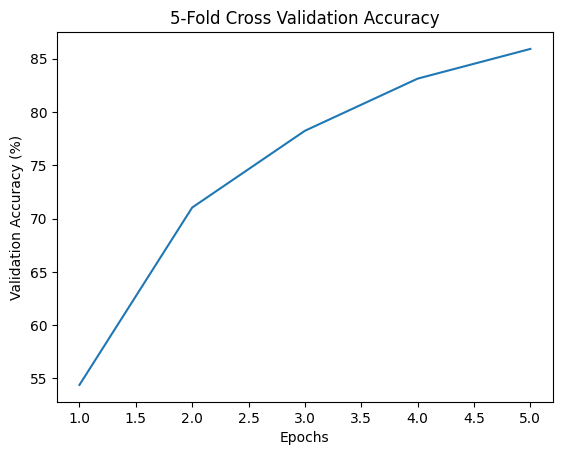

In [ ]:
cpc_arr = np.array([tensor.cpu().numpy() for tensor in cpc_val_accs])
np.save('cpc.npy', cpc_arr)
epochs = [1,2,3,4,5]
plt.plot(epochs, cpc_arr)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.title('5-Fold Cross Validation Accuracy')
plt.savefig('/content/cpc.pdf')
plt.show()

In [ ]:
np.save('cpc.npy', cpc_arr)

# Part 3: Rotation Prediction
The rotation prediction task encourages the model to learn visual representations by simply predicting the angle by which the input image is rotated. For a model to successfully predict the angle of rotation, it needs to capture enough semantic information about the object/concept in the input image.

In [ ]:
class RotDataset(Dataset):
  def __init__(self, crop_size, transform):
    self.rot_90 = transforms.RandomRotation((90, 90))
    self.rot_180 = transforms.RandomRotation((180, 180))
    self.rot_270 = transforms.RandomRotation((270, 270))

    self.image_names = sorted(os.listdir('/content/test_images'))[:1000]
    self.crop_size = crop_size
    self.transform = transform


  def __len__(self):
    return len(self.image_names)


  def __getitem__(self, idx):
    image_name = os.path.join('/content/test_images', self.image_names[idx])

    #image to tensor
    raw_image = Image.open(image_name)
    im_frame = raw_image.resize((224, 224), resample=Image.LANCZOS)

    rotation_num = np.random.randint(0, 4)

    if rotation_num == 0:
      image = self.transform(im_frame)
      label = [1, 0, 0, 0]
    elif rotation_num == 1:
      image = self.transform(self.rot_90(im_frame))
      label = [0, 1, 0, 0]
    elif rotation_num == 2:
      image = self.transform(self.rot_180(im_frame))
      label = [0, 0, 1, 0]
    elif rotation_num == 3:
      image = self.transform(self.rot_270(im_frame))
      label = [0, 0, 0, 1]

    img = np.asarray(image, dtype="float32")
    img /= 255

    return img, np.array(label)



In [ ]:
class FullyConnectedBig(nn.Module):
    def __init__(self, input_size, dropout_rate=0.5, include_top=True):
        super(FullyConnectedBig, self).__init__()
        self.include_top = include_top

        self.fc1 = nn.Linear(input_size, 2048)
        self.bn1 = nn.BatchNorm1d(2048)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(2048, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.dropout2 = nn.Dropout(dropout_rate)

        if include_top:
            self.fc3 = nn.Linear(1024, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        if self.include_top:
            x = F.relu(self.fc3(x))

        return x

class ApplyRotationPredictionModelToEncoder(nn.Module):
    def __init__(self, encoder_model, units):
        super(ApplyRotationPredictionModelToEncoder, self).__init__()
        self.encoder_model = encoder_model

        # Create the sub-model using the provided prediction architecture
        self.sub_model = FullyConnectedBig(units)

        # Define the final output layer
        self.final = nn.Linear(1, 4)

    def forward(self, x):
        # Forward pass through the encoder model
        x = self.encoder_model(x)

        # Flatten the output of the encoder model
        x = torch.flatten(x, 1)

        # Forward pass through the sub-model
        x = self.sub_model(x)

        # Forward pass through the final output layer
        x = self.final(x)

        # Apply softmax activation
        x = F.softmax(x, dim=1)

        return x

class CustomRotDenseNet(nn.Module):
    def __init__(self, pooling='avg'):
        super(CustomRotDenseNet, self).__init__()
        self.densenet = models.densenet121(pretrained=False, progress=True)

        # Convert all parameters and layers to float
        self.densenet = self.densenet.float()

        # Exclude the top layer (usually Global Average Pooling and Fully Connected layers)
        self.densenet = nn.Sequential(*list(self.densenet.children())[:-1])

        if pooling == 'avg':
            self.pooling = nn.AdaptiveAvgPool2d(1)
        elif pooling == 'max':
            self.pooling = nn.AdaptiveMaxPool2d(1)
        else:
            raise ValueError("Pooling should be 'avg' or 'max'")

    def forward(self, x):
        x = x.float()

        features = self.densenet(x)
        pooled_features = self.pooling(features)
        pooled_features = pooled_features.view(pooled_features.size(0), -1)
        return pooled_features


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
preprocess_dataset = RotDataset(224, transform)
train_ratio = 0.95
val_ratio = 0.05
train_size = int(train_ratio * len(preprocess_dataset))
val_size = ceil(val_ratio * len(preprocess_dataset))
train_dataset, val_dataset = random_split(preprocess_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=15, shuffle=False)

# Set the device to GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder_model = CustomRotDenseNet()
units = 1024
rotation_model = ApplyRotationPredictionModelToEncoder(encoder_model, units)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rotation_model.parameters(), lr=1e-5)

rotation_model.to(device)

def train_rotation_model():
    # Training loop
    num_epochs = 15
    for epoch in range(num_epochs):
        rotation_model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for input, target in tqdm(train_loader):
            input = input.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            pred = rotation_model(input)

            target = target.float()
            target = target.to(device)
            pred = pred.to(device)
            loss = criterion(pred, target)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = pred.max(1)
            train_total += target.size(0)
            print(train_loss)


        rotation_model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for input, target in tqdm(val_loader):
                input = input.to(device)
                outputs = rotation_model(input)
                target = target.float()
                target = target.to(device)
                outputs = outputs.to(device)
                loss = criterion(outputs, target)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += target.size(0)


        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}"
              f"Val Loss: {val_loss:.4f}")

train_rotation_model()

1000 950 50


  2%|▏         | 1/64 [00:02<02:14,  2.13s/it]

1.3738352060317993


  3%|▎         | 2/64 [00:03<01:36,  1.56s/it]

2.748475670814514


  5%|▍         | 3/64 [00:04<01:18,  1.29s/it]

4.1623852252960205


  6%|▋         | 4/64 [00:05<01:08,  1.15s/it]

5.555471777915955


  8%|▊         | 5/64 [00:05<00:58,  1.01it/s]

6.933815836906433


  9%|▉         | 6/64 [00:06<00:49,  1.16it/s]

8.32946491241455


 11%|█         | 7/64 [00:07<00:44,  1.29it/s]

9.65458858013153


 12%|█▎        | 8/64 [00:08<00:51,  1.09it/s]

11.046642899513245


 14%|█▍        | 9/64 [00:09<00:56,  1.02s/it]

12.43283724784851


 16%|█▌        | 10/64 [00:10<00:49,  1.09it/s]

13.815885543823242


 17%|█▋        | 11/64 [00:10<00:44,  1.19it/s]

15.200675964355469


 19%|█▉        | 12/64 [00:12<00:49,  1.06it/s]

16.5902761220932


 20%|██        | 13/64 [00:12<00:40,  1.27it/s]

17.959768414497375


 22%|██▏       | 14/64 [00:13<00:37,  1.32it/s]

19.368297815322876


 23%|██▎       | 15/64 [00:13<00:32,  1.52it/s]

20.77638030052185


 25%|██▌       | 16/64 [00:14<00:33,  1.44it/s]

22.16693639755249


 27%|██▋       | 17/64 [00:15<00:38,  1.23it/s]

23.579235434532166


 28%|██▊       | 18/64 [00:16<00:43,  1.07it/s]

24.931697726249695


 30%|██▉       | 19/64 [00:17<00:40,  1.10it/s]

26.330790162086487


 31%|███▏      | 20/64 [00:18<00:36,  1.22it/s]

27.74618101119995


 33%|███▎      | 21/64 [00:18<00:30,  1.41it/s]

29.12613356113434


 34%|███▍      | 22/64 [00:19<00:29,  1.43it/s]

30.53541886806488


 36%|███▌      | 23/64 [00:20<00:31,  1.31it/s]

31.91055679321289


 38%|███▊      | 24/64 [00:21<00:33,  1.20it/s]

33.285762310028076


 39%|███▉      | 25/64 [00:21<00:30,  1.27it/s]

34.6934757232666


 41%|████      | 26/64 [00:22<00:27,  1.37it/s]

36.07134795188904


 42%|████▏     | 27/64 [00:23<00:30,  1.21it/s]

37.4775595664978


 44%|████▍     | 28/64 [00:24<00:25,  1.41it/s]

38.86982083320618


 45%|████▌     | 29/64 [00:25<00:28,  1.24it/s]

40.271692633628845


 47%|████▋     | 30/64 [00:25<00:25,  1.32it/s]

41.67638564109802


 48%|████▊     | 31/64 [00:26<00:28,  1.16it/s]

43.07554066181183


 50%|█████     | 32/64 [00:27<00:29,  1.10it/s]

44.44544994831085


 52%|█████▏    | 33/64 [00:28<00:25,  1.21it/s]

45.84491467475891


 53%|█████▎    | 34/64 [00:29<00:25,  1.16it/s]

47.20044922828674


 55%|█████▍    | 35/64 [00:30<00:25,  1.12it/s]

48.57445681095123


 56%|█████▋    | 36/64 [00:31<00:23,  1.21it/s]

50.012027621269226


 58%|█████▊    | 37/64 [00:31<00:20,  1.34it/s]

51.390631794929504


 59%|█████▉    | 38/64 [00:32<00:19,  1.33it/s]

52.80858528614044


 61%|██████    | 39/64 [00:32<00:17,  1.41it/s]

54.2044323682785


 62%|██████▎   | 40/64 [00:33<00:16,  1.47it/s]

55.58203303813934


 64%|██████▍   | 41/64 [00:34<00:16,  1.41it/s]

56.957088351249695


 66%|██████▌   | 42/64 [00:35<00:17,  1.25it/s]

58.375943422317505


 67%|██████▋   | 43/64 [00:36<00:16,  1.31it/s]

59.77122700214386


 69%|██████▉   | 44/64 [00:36<00:15,  1.29it/s]

61.16942262649536


 70%|███████   | 45/64 [00:37<00:15,  1.22it/s]

62.4985032081604


 72%|███████▏  | 46/64 [00:38<00:15,  1.15it/s]

63.896204829216


 73%|███████▎  | 47/64 [00:39<00:13,  1.27it/s]

65.29192733764648


 75%|███████▌  | 48/64 [00:40<00:13,  1.21it/s]

66.67468976974487


 77%|███████▋  | 49/64 [00:41<00:13,  1.11it/s]

68.04512047767639


 78%|███████▊  | 50/64 [00:42<00:13,  1.07it/s]

69.44327008724213


 80%|███████▉  | 51/64 [00:43<00:11,  1.14it/s]

70.81402361392975


 81%|████████▏ | 52/64 [00:43<00:08,  1.34it/s]

72.20192110538483


 83%|████████▎ | 53/64 [00:44<00:09,  1.18it/s]

73.56771886348724


 84%|████████▍ | 54/64 [00:44<00:06,  1.44it/s]

74.95923101902008


 86%|████████▌ | 55/64 [00:45<00:06,  1.40it/s]

76.37877523899078


 88%|████████▊ | 56/64 [00:46<00:05,  1.33it/s]

77.76910841464996


 89%|████████▉ | 57/64 [00:46<00:04,  1.53it/s]

79.2034467458725


 91%|█████████ | 58/64 [00:47<00:03,  1.64it/s]

80.56949961185455


 92%|█████████▏| 59/64 [00:48<00:03,  1.42it/s]

81.96579217910767


 94%|█████████▍| 60/64 [00:49<00:02,  1.36it/s]

83.366446018219


 95%|█████████▌| 61/64 [00:50<00:02,  1.33it/s]

84.7580748796463


 97%|█████████▋| 62/64 [00:50<00:01,  1.26it/s]

86.15957236289978


 98%|█████████▊| 63/64 [00:51<00:00,  1.31it/s]

87.54855906963348


100%|██████████| 64/64 [00:51<00:00,  1.23it/s]


88.95567059516907
64 88.95567059516907


100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


Epoch 1/15 - Train Loss: 88.9557Val Loss: 5.5700


  2%|▏         | 1/64 [00:00<00:57,  1.09it/s]

1.4060392379760742


  3%|▎         | 2/64 [00:02<01:22,  1.34s/it]

2.799704074859619


  5%|▍         | 3/64 [00:03<01:22,  1.35s/it]

4.207416415214539


  6%|▋         | 4/64 [00:04<01:13,  1.22s/it]

5.570727109909058


  8%|▊         | 5/64 [00:06<01:12,  1.23s/it]

6.942264676094055


  9%|▉         | 6/64 [00:07<01:07,  1.17s/it]

8.314066529273987


 11%|█         | 7/64 [00:08<01:04,  1.12s/it]

9.756633043289185


 12%|█▎        | 8/64 [00:09<01:05,  1.17s/it]

11.148328304290771


 14%|█▍        | 9/64 [00:11<01:19,  1.44s/it]

12.580064296722412


 16%|█▌        | 10/64 [00:12<01:10,  1.30s/it]

13.975980639457703


 17%|█▋        | 11/64 [00:13<00:56,  1.06s/it]

15.372106909751892


 19%|█▉        | 12/64 [00:13<00:49,  1.06it/s]

16.721034169197083


 20%|██        | 13/64 [00:14<00:44,  1.15it/s]

18.110962986946106


 22%|██▏       | 14/64 [00:15<00:46,  1.07it/s]

19.51754927635193


 23%|██▎       | 15/64 [00:16<00:39,  1.23it/s]

20.91045379638672


 25%|██▌       | 16/64 [00:17<00:41,  1.15it/s]

22.30221998691559


 27%|██▋       | 17/64 [00:17<00:34,  1.37it/s]

23.678706765174866


 28%|██▊       | 18/64 [00:18<00:35,  1.28it/s]

25.068572163581848


 30%|██▉       | 19/64 [00:19<00:38,  1.16it/s]

26.46187949180603


 31%|███▏      | 20/64 [00:20<00:36,  1.20it/s]

27.851616501808167


 33%|███▎      | 21/64 [00:20<00:31,  1.37it/s]

29.294384360313416


 34%|███▍      | 22/64 [00:21<00:31,  1.35it/s]

30.667038679122925


 36%|███▌      | 23/64 [00:21<00:26,  1.52it/s]

32.089858055114746


 38%|███▊      | 24/64 [00:22<00:28,  1.40it/s]

33.44274294376373


 39%|███▉      | 25/64 [00:23<00:28,  1.36it/s]

34.848814725875854


 41%|████      | 26/64 [00:24<00:28,  1.34it/s]

36.22812736034393


 42%|████▏     | 27/64 [00:25<00:29,  1.24it/s]

37.64453363418579


 44%|████▍     | 28/64 [00:25<00:26,  1.38it/s]

39.035996198654175


 45%|████▌     | 29/64 [00:26<00:22,  1.54it/s]

40.44393825531006


 47%|████▋     | 30/64 [00:27<00:23,  1.44it/s]

41.81181883811951


 48%|████▊     | 31/64 [00:27<00:20,  1.65it/s]

43.163400769233704


 50%|█████     | 32/64 [00:27<00:17,  1.82it/s]

44.53655016422272


 52%|█████▏    | 33/64 [00:28<00:19,  1.61it/s]

45.921663999557495


 53%|█████▎    | 34/64 [00:29<00:18,  1.64it/s]

47.30098032951355


 55%|█████▍    | 35/64 [00:29<00:18,  1.53it/s]

48.67880630493164


 56%|█████▋    | 36/64 [00:30<00:17,  1.62it/s]

50.07029342651367


 58%|█████▊    | 37/64 [00:30<00:15,  1.75it/s]

51.41610646247864


 59%|█████▉    | 38/64 [00:31<00:16,  1.62it/s]

52.82319617271423


 61%|██████    | 39/64 [00:32<00:12,  1.93it/s]

54.212194204330444


 62%|██████▎   | 40/64 [00:32<00:14,  1.69it/s]

55.55507946014404


 64%|██████▍   | 41/64 [00:33<00:12,  1.79it/s]

56.955164194107056


 66%|██████▌   | 42/64 [00:34<00:13,  1.58it/s]

58.369515895843506


 67%|██████▋   | 43/64 [00:35<00:16,  1.31it/s]

59.77675497531891


 69%|██████▉   | 44/64 [00:35<00:14,  1.36it/s]

61.12503921985626


 70%|███████   | 45/64 [00:36<00:13,  1.43it/s]

62.53220069408417


 72%|███████▏  | 46/64 [00:37<00:12,  1.46it/s]

63.90576350688934


 73%|███████▎  | 47/64 [00:37<00:12,  1.34it/s]

65.30519032478333


 75%|███████▌  | 48/64 [00:38<00:12,  1.26it/s]

66.71294796466827


 77%|███████▋  | 49/64 [00:39<00:12,  1.22it/s]

68.10718297958374


 78%|███████▊  | 50/64 [00:40<00:11,  1.17it/s]

69.48565411567688


 80%|███████▉  | 51/64 [00:41<00:10,  1.28it/s]

70.85804581642151


 81%|████████▏ | 52/64 [00:41<00:09,  1.31it/s]

72.24770927429199


 83%|████████▎ | 53/64 [00:42<00:08,  1.27it/s]

73.63331925868988


 84%|████████▍ | 54/64 [00:43<00:08,  1.22it/s]

75.01838839054108


 86%|████████▌ | 55/64 [00:44<00:08,  1.10it/s]

76.38718831539154


 88%|████████▊ | 56/64 [00:45<00:06,  1.27it/s]

77.75720834732056


 89%|████████▉ | 57/64 [00:45<00:04,  1.45it/s]

79.151806473732


 91%|█████████ | 58/64 [00:46<00:04,  1.30it/s]

80.55921363830566


 92%|█████████▏| 59/64 [00:47<00:04,  1.21it/s]

81.92300617694855


 94%|█████████▍| 60/64 [00:48<00:03,  1.19it/s]

83.31260883808136


 95%|█████████▌| 61/64 [00:49<00:02,  1.15it/s]

84.6967180967331


 97%|█████████▋| 62/64 [00:50<00:01,  1.20it/s]

86.04521441459656


 98%|█████████▊| 63/64 [00:51<00:00,  1.21it/s]

87.42138290405273


100%|██████████| 64/64 [00:51<00:00,  1.24it/s]


88.74551630020142
64 88.74551630020142


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch 2/15 - Train Loss: 88.7455Val Loss: 5.5877


  2%|▏         | 1/64 [00:00<00:53,  1.17it/s]

1.3864901065826416


  3%|▎         | 2/64 [00:01<00:43,  1.41it/s]

2.779995560646057


  5%|▍         | 3/64 [00:02<00:44,  1.36it/s]

4.185607552528381


  6%|▋         | 4/64 [00:03<00:45,  1.32it/s]

5.581108570098877


  8%|▊         | 5/64 [00:03<00:35,  1.67it/s]

6.998790264129639


  9%|▉         | 6/64 [00:04<00:39,  1.48it/s]

8.37266218662262


 11%|█         | 7/64 [00:05<00:42,  1.33it/s]

9.767758131027222


 12%|█▎        | 8/64 [00:05<00:42,  1.31it/s]

11.119784832000732


 14%|█▍        | 9/64 [00:06<00:41,  1.33it/s]

12.475611448287964


 16%|█▌        | 10/64 [00:07<00:35,  1.52it/s]

13.866397976875305


 17%|█▋        | 11/64 [00:08<00:43,  1.23it/s]

15.245358109474182


 19%|█▉        | 12/64 [00:09<00:43,  1.20it/s]

16.632542967796326


 20%|██        | 13/64 [00:10<00:57,  1.12s/it]

18.061589241027832


 22%|██▏       | 14/64 [00:11<00:45,  1.09it/s]

19.450969219207764


 23%|██▎       | 15/64 [00:12<00:42,  1.16it/s]

20.800782322883606


 25%|██▌       | 16/64 [00:12<00:40,  1.17it/s]

22.155860543251038


 27%|██▋       | 17/64 [00:13<00:36,  1.28it/s]

23.579398036003113


 28%|██▊       | 18/64 [00:14<00:37,  1.24it/s]

24.921028971672058


 30%|██▉       | 19/64 [00:15<00:42,  1.06it/s]

26.299899697303772


 31%|███▏      | 20/64 [00:16<00:38,  1.13it/s]

27.6890732049942


 33%|███▎      | 21/64 [00:17<00:36,  1.18it/s]

29.062737584114075


 34%|███▍      | 22/64 [00:17<00:31,  1.35it/s]

30.47551465034485


 36%|███▌      | 23/64 [00:18<00:30,  1.35it/s]

31.87903594970703


 38%|███▊      | 24/64 [00:19<00:29,  1.36it/s]

33.25142168998718


 39%|███▉      | 25/64 [00:19<00:26,  1.45it/s]

34.64032053947449


 41%|████      | 26/64 [00:20<00:30,  1.26it/s]

36.01322889328003


 42%|████▏     | 27/64 [00:21<00:33,  1.12it/s]

37.38792538642883


 44%|████▍     | 28/64 [00:22<00:30,  1.18it/s]

38.793949127197266


 45%|████▌     | 29/64 [00:23<00:26,  1.32it/s]

40.200857520103455


 47%|████▋     | 30/64 [00:23<00:23,  1.46it/s]

41.56858551502228


 48%|████▊     | 31/64 [00:24<00:22,  1.47it/s]

42.92512547969818


 50%|█████     | 32/64 [00:25<00:22,  1.44it/s]

44.30118811130524


 52%|█████▏    | 33/64 [00:25<00:23,  1.34it/s]

45.674946427345276


 53%|█████▎    | 34/64 [00:26<00:23,  1.28it/s]

47.06739318370819


 55%|█████▍    | 35/64 [00:27<00:21,  1.33it/s]

48.44067871570587


 56%|█████▋    | 36/64 [00:28<00:21,  1.28it/s]

49.78489422798157


 58%|█████▊    | 37/64 [00:29<00:22,  1.23it/s]

51.215505719184875


 59%|█████▉    | 38/64 [00:29<00:19,  1.33it/s]

52.583760499954224


 61%|██████    | 39/64 [00:30<00:17,  1.41it/s]

54.01748836040497


 62%|██████▎   | 40/64 [00:31<00:18,  1.28it/s]

55.36179769039154


 64%|██████▍   | 41/64 [00:31<00:15,  1.47it/s]

56.80055356025696


 66%|██████▌   | 42/64 [00:32<00:12,  1.75it/s]

58.175025939941406


 67%|██████▋   | 43/64 [00:32<00:12,  1.73it/s]

59.57605957984924


 69%|██████▉   | 44/64 [00:33<00:12,  1.63it/s]

60.978625535964966


 70%|███████   | 45/64 [00:34<00:12,  1.52it/s]

62.41558611392975


 72%|███████▏  | 46/64 [00:34<00:11,  1.57it/s]

63.764979124069214


 73%|███████▎  | 47/64 [00:35<00:13,  1.24it/s]

65.14771747589111


 75%|███████▌  | 48/64 [00:36<00:13,  1.21it/s]

66.54992961883545


 77%|███████▋  | 49/64 [00:37<00:11,  1.34it/s]

67.9382392168045


 78%|███████▊  | 50/64 [00:38<00:11,  1.20it/s]

69.32709312438965


 80%|███████▉  | 51/64 [00:39<00:10,  1.19it/s]

70.70287525653839


 81%|████████▏ | 52/64 [00:39<00:08,  1.37it/s]

72.09952282905579


 83%|████████▎ | 53/64 [00:40<00:08,  1.33it/s]

73.51269888877869


 84%|████████▍ | 54/64 [00:41<00:06,  1.43it/s]

74.87141478061676


 86%|████████▌ | 55/64 [00:41<00:06,  1.41it/s]

76.23456823825836


 88%|████████▊ | 56/64 [00:42<00:06,  1.28it/s]

77.64112174510956


 89%|████████▉ | 57/64 [00:43<00:06,  1.15it/s]

79.00062680244446


 91%|█████████ | 58/64 [00:44<00:05,  1.18it/s]

80.42101418972015


 92%|█████████▏| 59/64 [00:45<00:03,  1.30it/s]

81.81564569473267


 94%|█████████▍| 60/64 [00:45<00:02,  1.51it/s]

83.20800650119781


 95%|█████████▌| 61/64 [00:45<00:01,  1.82it/s]

84.57114231586456


 97%|█████████▋| 62/64 [00:46<00:01,  1.76it/s]

85.89302623271942


100%|██████████| 64/64 [00:47<00:00,  1.35it/s]


87.27592980861664
88.62835395336151
64 88.62835395336151


100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


Epoch 3/15 - Train Loss: 88.6284Val Loss: 5.5633


  2%|▏         | 1/64 [00:00<00:34,  1.85it/s]

1.4097473621368408


  3%|▎         | 2/64 [00:01<00:43,  1.42it/s]

2.7995102405548096


  5%|▍         | 3/64 [00:01<00:40,  1.51it/s]

4.181050896644592


  6%|▋         | 4/64 [00:02<00:47,  1.27it/s]

5.575059175491333


  8%|▊         | 5/64 [00:03<00:46,  1.28it/s]

6.987143397331238


  9%|▉         | 6/64 [00:04<00:43,  1.33it/s]

8.341321349143982


 11%|█         | 7/64 [00:05<00:41,  1.39it/s]

9.699845314025879


 12%|█▎        | 8/64 [00:05<00:40,  1.40it/s]

11.074532866477966


 14%|█▍        | 9/64 [00:06<00:39,  1.38it/s]

12.460503220558167


 16%|█▌        | 10/64 [00:07<00:39,  1.38it/s]

13.836428880691528


 17%|█▋        | 11/64 [00:07<00:36,  1.46it/s]

15.206788420677185


 19%|█▉        | 12/64 [00:08<00:34,  1.52it/s]

16.579647302627563


 20%|██        | 13/64 [00:09<00:33,  1.54it/s]

17.985798358917236


 22%|██▏       | 14/64 [00:09<00:32,  1.55it/s]

19.355335474014282


 23%|██▎       | 15/64 [00:10<00:28,  1.72it/s]

20.80009949207306


 25%|██▌       | 16/64 [00:11<00:39,  1.21it/s]

22.164470076560974


 27%|██▋       | 17/64 [00:12<00:36,  1.28it/s]

23.562358617782593


 28%|██▊       | 18/64 [00:13<00:37,  1.22it/s]

24.909082412719727


 30%|██▉       | 19/64 [00:14<00:38,  1.18it/s]

26.29312777519226


 31%|███▏      | 20/64 [00:15<00:43,  1.02it/s]

27.654045939445496


 33%|███▎      | 21/64 [00:16<00:40,  1.07it/s]

28.989068269729614


 34%|███▍      | 22/64 [00:16<00:34,  1.22it/s]

30.385937213897705


 36%|███▌      | 23/64 [00:17<00:30,  1.37it/s]

31.743091106414795


 38%|███▊      | 24/64 [00:17<00:28,  1.41it/s]

33.120725274086


 39%|███▉      | 25/64 [00:18<00:29,  1.32it/s]

34.48545479774475


 41%|████      | 26/64 [00:19<00:25,  1.52it/s]

35.857444047927856


 42%|████▏     | 27/64 [00:19<00:25,  1.44it/s]

37.21795642375946


 44%|████▍     | 28/64 [00:20<00:24,  1.48it/s]

38.61249923706055


 45%|████▌     | 29/64 [00:21<00:25,  1.40it/s]

39.971723318099976


 47%|████▋     | 30/64 [00:22<00:25,  1.35it/s]

41.356714844703674


 48%|████▊     | 31/64 [00:22<00:23,  1.43it/s]

42.71838986873627


 50%|█████     | 32/64 [00:23<00:20,  1.54it/s]

44.08176600933075


 52%|█████▏    | 33/64 [00:24<00:21,  1.42it/s]

45.46393430233002


 53%|█████▎    | 34/64 [00:25<00:22,  1.32it/s]

46.85756874084473


 55%|█████▍    | 35/64 [00:26<00:25,  1.14it/s]

48.28018236160278


 56%|█████▋    | 36/64 [00:26<00:22,  1.24it/s]

49.66641628742218


 58%|█████▊    | 37/64 [00:27<00:21,  1.27it/s]

51.075315833091736


 59%|█████▉    | 38/64 [00:28<00:17,  1.45it/s]

52.46462559700012


 61%|██████    | 39/64 [00:29<00:20,  1.24it/s]

53.850555300712585


 62%|██████▎   | 40/64 [00:30<00:23,  1.02it/s]

55.21743667125702


 64%|██████▍   | 41/64 [00:31<00:21,  1.09it/s]

56.55879843235016


 66%|██████▌   | 42/64 [00:32<00:18,  1.16it/s]

57.97153627872467


 67%|██████▋   | 43/64 [00:32<00:17,  1.21it/s]

59.35467302799225


 69%|██████▉   | 44/64 [00:33<00:15,  1.33it/s]

60.783058643341064


 70%|███████   | 45/64 [00:34<00:14,  1.29it/s]

62.14953434467316


 72%|███████▏  | 46/64 [00:35<00:14,  1.21it/s]

63.51349854469299


 73%|███████▎  | 47/64 [00:35<00:13,  1.30it/s]

64.89781665802002


 75%|███████▌  | 48/64 [00:36<00:13,  1.17it/s]

66.31866526603699


 77%|███████▋  | 49/64 [00:37<00:13,  1.14it/s]

67.6722491979599


 78%|███████▊  | 50/64 [00:38<00:11,  1.27it/s]

69.04298532009125


 80%|███████▉  | 51/64 [00:39<00:10,  1.28it/s]

70.42895567417145


 81%|████████▏ | 52/64 [00:40<00:10,  1.11it/s]

71.79056012630463


 83%|████████▎ | 53/64 [00:40<00:08,  1.31it/s]

73.19459104537964


 84%|████████▍ | 54/64 [00:41<00:07,  1.36it/s]

74.523996591568


 86%|████████▌ | 55/64 [00:42<00:06,  1.38it/s]

75.92325150966644


 88%|████████▊ | 56/64 [00:42<00:06,  1.32it/s]

77.32608294487


 89%|████████▉ | 57/64 [00:43<00:04,  1.51it/s]

78.73731625080109


 91%|█████████ | 58/64 [00:43<00:03,  1.71it/s]

80.1091376543045


 92%|█████████▏| 59/64 [00:44<00:03,  1.58it/s]

81.49759101867676


 94%|█████████▍| 60/64 [00:45<00:02,  1.69it/s]

82.84788393974304


 95%|█████████▌| 61/64 [00:45<00:01,  1.58it/s]

84.22923958301544


 97%|█████████▋| 62/64 [00:46<00:01,  1.31it/s]

85.57300055027008


 98%|█████████▊| 63/64 [00:47<00:00,  1.23it/s]

87.00317740440369


100%|██████████| 64/64 [00:47<00:00,  1.33it/s]


88.42125236988068
64 88.42125236988068


100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


Epoch 4/15 - Train Loss: 88.4213Val Loss: 5.5817


  2%|▏         | 1/64 [00:00<00:33,  1.87it/s]

1.3846402168273926


  3%|▎         | 2/64 [00:01<00:51,  1.20it/s]

2.776275873184204


  5%|▍         | 3/64 [00:02<00:57,  1.05it/s]

4.120623469352722


  6%|▋         | 4/64 [00:03<00:56,  1.06it/s]

5.513856530189514


  8%|▊         | 5/64 [00:04<00:51,  1.14it/s]

6.913711905479431


  9%|▉         | 6/64 [00:05<00:56,  1.02it/s]

8.233188152313232


 11%|█         | 7/64 [00:06<00:51,  1.10it/s]

9.60997211933136


 12%|█▎        | 8/64 [00:07<00:48,  1.16it/s]

11.007535696029663


 14%|█▍        | 9/64 [00:07<00:42,  1.29it/s]

12.402796387672424


 16%|█▌        | 10/64 [00:08<00:42,  1.28it/s]

13.761258244514465


 17%|█▋        | 11/64 [00:09<00:40,  1.30it/s]

15.119039535522461


 19%|█▉        | 12/64 [00:10<00:42,  1.22it/s]

16.505728363990784


 20%|██        | 13/64 [00:10<00:42,  1.20it/s]

17.89721381664276


 22%|██▏       | 14/64 [00:11<00:37,  1.35it/s]

19.26701855659485


 23%|██▎       | 15/64 [00:12<00:33,  1.45it/s]

20.647651195526123


 25%|██▌       | 16/64 [00:12<00:36,  1.32it/s]

22.043028473854065


 27%|██▋       | 17/64 [00:13<00:34,  1.38it/s]

23.38535225391388


 28%|██▊       | 18/64 [00:14<00:31,  1.47it/s]

24.709726214408875


 30%|██▉       | 19/64 [00:15<00:32,  1.38it/s]

26.058454394340515


 31%|███▏      | 20/64 [00:15<00:28,  1.54it/s]

27.43142807483673


 33%|███▎      | 21/64 [00:15<00:25,  1.70it/s]

28.767839908599854


 34%|███▍      | 22/64 [00:16<00:28,  1.48it/s]

30.152609944343567


 36%|███▌      | 23/64 [00:17<00:25,  1.61it/s]

31.552359461784363


 38%|███▊      | 24/64 [00:17<00:22,  1.74it/s]

32.947054862976074


 39%|███▉      | 25/64 [00:18<00:22,  1.72it/s]

34.29925572872162


 41%|████      | 26/64 [00:19<00:22,  1.70it/s]

35.67803955078125


 42%|████▏     | 27/64 [00:19<00:24,  1.52it/s]

37.06577396392822


 44%|████▍     | 28/64 [00:20<00:24,  1.48it/s]

38.45138335227966


 45%|████▌     | 29/64 [00:21<00:24,  1.46it/s]

39.796743631362915


 47%|████▋     | 30/64 [00:22<00:25,  1.34it/s]

41.17232573032379


 48%|████▊     | 31/64 [00:23<00:28,  1.17it/s]

42.562315821647644


 50%|█████     | 32/64 [00:23<00:24,  1.32it/s]

43.94012415409088


 52%|█████▏    | 33/64 [00:24<00:25,  1.22it/s]

45.30065071582794


 53%|█████▎    | 34/64 [00:25<00:26,  1.14it/s]

46.66468024253845


 55%|█████▍    | 35/64 [00:26<00:20,  1.44it/s]

48.00603151321411


 56%|█████▋    | 36/64 [00:26<00:19,  1.43it/s]

49.415109515190125


 58%|█████▊    | 37/64 [00:27<00:21,  1.25it/s]

50.73785090446472


 59%|█████▉    | 38/64 [00:28<00:20,  1.29it/s]

52.149293303489685


 61%|██████    | 39/64 [00:29<00:18,  1.34it/s]

53.55211699008942


 62%|██████▎   | 40/64 [00:29<00:15,  1.55it/s]

54.93090224266052


 64%|██████▍   | 41/64 [00:30<00:15,  1.44it/s]

56.27527141571045


 66%|██████▌   | 42/64 [00:31<00:15,  1.44it/s]

57.67889952659607


 67%|██████▋   | 43/64 [00:32<00:17,  1.21it/s]

59.018510580062866


 69%|██████▉   | 44/64 [00:32<00:15,  1.32it/s]

60.413970708847046


 70%|███████   | 45/64 [00:33<00:14,  1.27it/s]

61.769986271858215


 72%|███████▏  | 46/64 [00:34<00:15,  1.19it/s]

63.13267433643341


 73%|███████▎  | 47/64 [00:35<00:14,  1.21it/s]

64.50353825092316


 75%|███████▌  | 48/64 [00:36<00:12,  1.26it/s]

65.84555613994598


 77%|███████▋  | 49/64 [00:36<00:10,  1.44it/s]

67.18829715251923


 78%|███████▊  | 50/64 [00:37<00:08,  1.61it/s]

68.53939628601074


 80%|███████▉  | 51/64 [00:37<00:08,  1.51it/s]

69.87005424499512


 81%|████████▏ | 52/64 [00:38<00:09,  1.28it/s]

71.27576398849487


 83%|████████▎ | 53/64 [00:40<00:09,  1.13it/s]

72.68700432777405


 84%|████████▍ | 54/64 [00:41<00:09,  1.06it/s]

74.05516850948334


 86%|████████▌ | 55/64 [00:41<00:07,  1.19it/s]

75.43965578079224


 88%|████████▊ | 56/64 [00:42<00:06,  1.15it/s]

76.80458307266235


 89%|████████▉ | 57/64 [00:43<00:06,  1.16it/s]

78.13165497779846


 91%|█████████ | 58/64 [00:44<00:05,  1.14it/s]

79.50214731693268


 92%|█████████▏| 59/64 [00:44<00:03,  1.33it/s]

80.8648738861084


 94%|█████████▍| 60/64 [00:45<00:02,  1.34it/s]

82.23406481742859


 95%|█████████▌| 61/64 [00:46<00:02,  1.39it/s]

83.60257840156555


 97%|█████████▋| 62/64 [00:46<00:01,  1.39it/s]

84.97944355010986


100%|██████████| 64/64 [00:47<00:00,  1.35it/s]


86.34610617160797
87.67336869239807
64 87.67336869239807


100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


Epoch 5/15 - Train Loss: 87.6734Val Loss: 5.3679


  2%|▏         | 1/64 [00:00<00:52,  1.20it/s]

1.3563804626464844


  3%|▎         | 2/64 [00:01<00:42,  1.45it/s]

2.7499496936798096


  5%|▍         | 3/64 [00:01<00:32,  1.87it/s]

4.123316526412964


  6%|▋         | 4/64 [00:04<01:18,  1.30s/it]

5.494449257850647


  8%|▊         | 5/64 [00:05<01:06,  1.12s/it]

6.847031831741333


  9%|▉         | 6/64 [00:05<00:58,  1.00s/it]

8.224431037902832


 11%|█         | 7/64 [00:06<00:48,  1.17it/s]

9.619139909744263


 12%|█▎        | 8/64 [00:06<00:41,  1.36it/s]

10.981080532073975


 14%|█▍        | 9/64 [00:07<00:35,  1.55it/s]

12.320980548858643


 16%|█▌        | 10/64 [00:08<00:36,  1.49it/s]

13.66308343410492


 17%|█▋        | 11/64 [00:08<00:32,  1.64it/s]

15.052639842033386


 19%|█▉        | 12/64 [00:08<00:29,  1.79it/s]

16.45235300064087


 20%|██        | 13/64 [00:09<00:34,  1.48it/s]

17.83989930152893


 22%|██▏       | 14/64 [00:10<00:36,  1.36it/s]

19.218194723129272


 23%|██▎       | 15/64 [00:11<00:34,  1.44it/s]

20.57264244556427


 25%|██▌       | 16/64 [00:12<00:36,  1.33it/s]

21.930323481559753


 27%|██▋       | 17/64 [00:12<00:35,  1.34it/s]

23.25893521308899


 28%|██▊       | 18/64 [00:13<00:30,  1.53it/s]

24.602911829948425


 30%|██▉       | 19/64 [00:14<00:33,  1.34it/s]

25.963794469833374


 31%|███▏      | 20/64 [00:14<00:29,  1.47it/s]

27.321009397506714


 33%|███▎      | 21/64 [00:15<00:32,  1.34it/s]

28.693747878074646


 34%|███▍      | 22/64 [00:17<00:38,  1.08it/s]

30.06832778453827


 36%|███▌      | 23/64 [00:17<00:31,  1.32it/s]

31.482566833496094


 38%|███▊      | 24/64 [00:18<00:31,  1.25it/s]

32.81041729450226


 39%|███▉      | 25/64 [00:19<00:30,  1.30it/s]

34.15217936038971


 41%|████      | 26/64 [00:19<00:28,  1.32it/s]

35.5136399269104


 42%|████▏     | 27/64 [00:20<00:28,  1.29it/s]

36.84857892990112


 44%|████▍     | 28/64 [00:21<00:25,  1.40it/s]

38.22424554824829


 45%|████▌     | 29/64 [00:22<00:27,  1.26it/s]

39.54717445373535


 47%|████▋     | 30/64 [00:23<00:28,  1.21it/s]

40.91513109207153


 48%|████▊     | 31/64 [00:23<00:22,  1.48it/s]

42.27164363861084


 50%|█████     | 32/64 [00:24<00:22,  1.43it/s]

43.66556406021118


 52%|█████▏    | 33/64 [00:24<00:17,  1.76it/s]

45.08496558666229


 53%|█████▎    | 34/64 [00:25<00:20,  1.45it/s]

46.43659043312073


 55%|█████▍    | 35/64 [00:26<00:27,  1.05it/s]

47.76793563365936


 56%|█████▋    | 36/64 [00:28<00:27,  1.03it/s]

49.157907366752625


 58%|█████▊    | 37/64 [00:29<00:27,  1.00s/it]

50.50085210800171


 59%|█████▉    | 38/64 [00:30<00:25,  1.02it/s]

51.8517107963562


 61%|██████    | 39/64 [00:30<00:21,  1.18it/s]

53.20349371433258


 62%|██████▎   | 40/64 [00:31<00:19,  1.24it/s]

54.591439604759216


 64%|██████▍   | 41/64 [00:31<00:17,  1.35it/s]

55.939356565475464


 66%|██████▌   | 42/64 [00:32<00:14,  1.55it/s]

57.25676918029785


 67%|██████▋   | 43/64 [00:33<00:15,  1.37it/s]

58.591689229011536


 69%|██████▉   | 44/64 [00:34<00:16,  1.23it/s]

59.9810653924942


 70%|███████   | 45/64 [00:35<00:15,  1.23it/s]

61.370251178741455


 72%|███████▏  | 46/64 [00:36<00:16,  1.09it/s]

62.69085133075714


 73%|███████▎  | 47/64 [00:37<00:16,  1.06it/s]

64.01772928237915


 75%|███████▌  | 48/64 [00:37<00:14,  1.11it/s]

65.36295473575592


 77%|███████▋  | 49/64 [00:38<00:11,  1.33it/s]

66.73841738700867


 78%|███████▊  | 50/64 [00:38<00:09,  1.54it/s]

68.09272849559784


 80%|███████▉  | 51/64 [00:39<00:08,  1.60it/s]

69.46129167079926


 81%|████████▏ | 52/64 [00:39<00:07,  1.71it/s]

70.82496237754822


 83%|████████▎ | 53/64 [00:40<00:07,  1.53it/s]

72.16655027866364


 84%|████████▍ | 54/64 [00:41<00:06,  1.59it/s]

73.51796233654022


 86%|████████▌ | 55/64 [00:41<00:05,  1.77it/s]

74.85963380336761


 88%|████████▊ | 56/64 [00:42<00:05,  1.54it/s]

76.2098001241684


 89%|████████▉ | 57/64 [00:43<00:04,  1.58it/s]

77.54666292667389


 91%|█████████ | 58/64 [00:43<00:03,  1.66it/s]

78.86837685108185


 92%|█████████▏| 59/64 [00:44<00:03,  1.38it/s]

80.1969108581543


 94%|█████████▍| 60/64 [00:45<00:03,  1.11it/s]

81.53079223632812


 95%|█████████▌| 61/64 [00:46<00:02,  1.16it/s]

82.88944017887115


 97%|█████████▋| 62/64 [00:47<00:01,  1.28it/s]

84.2560338973999


100%|██████████| 64/64 [00:48<00:00,  1.53it/s]

85.59945094585419
86.92905604839325


100%|██████████| 64/64 [00:48<00:00,  1.32it/s]


64 86.92905604839325


100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


Epoch 6/15 - Train Loss: 86.9291Val Loss: 5.4050


  2%|▏         | 1/64 [00:01<01:09,  1.10s/it]

1.35289466381073


  3%|▎         | 2/64 [00:02<01:09,  1.12s/it]

2.7277345657348633


  5%|▍         | 3/64 [00:02<00:56,  1.08it/s]

4.049847364425659


  6%|▋         | 4/64 [00:03<00:52,  1.15it/s]

5.46317195892334


  8%|▊         | 5/64 [00:04<00:47,  1.24it/s]

6.806182503700256


  9%|▉         | 6/64 [00:05<00:48,  1.20it/s]

8.133654952049255


 11%|█         | 7/64 [00:05<00:41,  1.36it/s]

9.527663350105286


 12%|█▎        | 8/64 [00:06<00:37,  1.48it/s]

10.904628992080688


 14%|█▍        | 9/64 [00:06<00:32,  1.69it/s]

12.272233605384827


 16%|█▌        | 10/64 [00:07<00:36,  1.48it/s]

13.578596591949463


 17%|█▋        | 11/64 [00:08<00:38,  1.39it/s]

14.950029969215393


 19%|█▉        | 12/64 [00:09<00:37,  1.40it/s]

16.279574632644653


 20%|██        | 13/64 [00:09<00:36,  1.38it/s]

17.676438093185425


 22%|██▏       | 14/64 [00:10<00:31,  1.59it/s]

18.99908459186554


 23%|██▎       | 15/64 [00:11<00:37,  1.31it/s]

20.323421120643616


 25%|██▌       | 16/64 [00:12<00:40,  1.18it/s]

21.673503160476685


 27%|██▋       | 17/64 [00:13<00:42,  1.10it/s]

23.022287845611572


 28%|██▊       | 18/64 [00:14<00:42,  1.07it/s]

24.3543199300766


 30%|██▉       | 19/64 [00:15<00:39,  1.15it/s]

25.718344569206238


 31%|███▏      | 20/64 [00:16<00:39,  1.12it/s]

27.09326982498169


 33%|███▎      | 21/64 [00:17<00:38,  1.11it/s]

28.432948350906372


 34%|███▍      | 22/64 [00:17<00:31,  1.32it/s]

29.789547204971313


 36%|███▌      | 23/64 [00:18<00:31,  1.31it/s]

31.1818984746933


 38%|███▊      | 24/64 [00:19<00:34,  1.17it/s]

32.55911362171173


 39%|███▉      | 25/64 [00:20<00:31,  1.23it/s]

33.87892925739288


 41%|████      | 26/64 [00:20<00:29,  1.28it/s]

35.24071443080902


 42%|████▏     | 27/64 [00:21<00:25,  1.46it/s]

36.57635951042175


 44%|████▍     | 28/64 [00:21<00:23,  1.53it/s]

37.95040476322174


 45%|████▌     | 29/64 [00:22<00:23,  1.52it/s]

39.311339259147644


 47%|████▋     | 30/64 [00:23<00:25,  1.36it/s]

40.685659766197205


 48%|████▊     | 31/64 [00:24<00:27,  1.21it/s]

42.060521483421326


 50%|█████     | 32/64 [00:25<00:25,  1.23it/s]

43.4403772354126


 52%|█████▏    | 33/64 [00:25<00:23,  1.33it/s]

44.80361866950989


 53%|█████▎    | 34/64 [00:27<00:26,  1.12it/s]

46.11415731906891


 55%|█████▍    | 35/64 [00:27<00:21,  1.32it/s]

47.48110806941986


 56%|█████▋    | 36/64 [00:27<00:19,  1.47it/s]

48.84785842895508


 58%|█████▊    | 37/64 [00:28<00:16,  1.67it/s]

50.16050624847412


 59%|█████▉    | 38/64 [00:28<00:15,  1.69it/s]

51.5313755273819


 61%|██████    | 39/64 [00:29<00:15,  1.66it/s]

52.85769319534302


 62%|██████▎   | 40/64 [00:30<00:15,  1.59it/s]

54.25277900695801


 64%|██████▍   | 41/64 [00:30<00:14,  1.61it/s]

55.675830006599426


 66%|██████▌   | 42/64 [00:31<00:13,  1.63it/s]

57.07470118999481


 67%|██████▋   | 43/64 [00:31<00:11,  1.80it/s]

58.464001178741455


 69%|██████▉   | 44/64 [00:32<00:10,  1.85it/s]

59.820570945739746


 70%|███████   | 45/64 [00:32<00:09,  1.98it/s]

61.18653082847595


 72%|███████▏  | 46/64 [00:34<00:14,  1.28it/s]

62.5442761182785


 73%|███████▎  | 47/64 [00:34<00:12,  1.38it/s]

63.88653743267059


 75%|███████▌  | 48/64 [00:35<00:11,  1.37it/s]

65.20831990242004


 77%|███████▋  | 49/64 [00:36<00:11,  1.30it/s]

66.55148196220398


 78%|███████▊  | 50/64 [00:37<00:11,  1.24it/s]

67.88823795318604


 80%|███████▉  | 51/64 [00:38<00:10,  1.27it/s]

69.19869041442871


 81%|████████▏ | 52/64 [00:38<00:09,  1.25it/s]

70.57182598114014


 83%|████████▎ | 53/64 [00:39<00:08,  1.23it/s]

71.8959448337555


 84%|████████▍ | 54/64 [00:40<00:08,  1.13it/s]

73.23834550380707


 86%|████████▌ | 55/64 [00:41<00:07,  1.21it/s]

74.56535398960114


 88%|████████▊ | 56/64 [00:42<00:06,  1.26it/s]

75.91540658473969


 89%|████████▉ | 57/64 [00:42<00:05,  1.33it/s]

77.28397917747498


 91%|█████████ | 58/64 [00:43<00:04,  1.40it/s]

78.6106675863266


 92%|█████████▏| 59/64 [00:44<00:03,  1.27it/s]

79.97911965847015


 94%|█████████▍| 60/64 [00:44<00:02,  1.46it/s]

81.32099711894989


 95%|█████████▌| 61/64 [00:45<00:02,  1.22it/s]

82.62850439548492


 97%|█████████▋| 62/64 [00:46<00:01,  1.24it/s]

84.04051470756531


100%|██████████| 64/64 [00:47<00:00,  1.34it/s]


85.37770247459412
86.73938512802124
64 86.73938512802124


100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


Epoch 7/15 - Train Loss: 86.7394Val Loss: 5.4024


  2%|▏         | 1/64 [00:00<00:45,  1.39it/s]

1.3313435316085815


  3%|▎         | 2/64 [00:01<00:47,  1.30it/s]

2.671304225921631


  5%|▍         | 3/64 [00:02<00:45,  1.35it/s]

4.034919023513794


  6%|▋         | 4/64 [00:02<00:36,  1.66it/s]

5.452662467956543


  8%|▊         | 5/64 [00:03<00:44,  1.32it/s]

6.793362259864807


  9%|▉         | 6/64 [00:04<00:49,  1.17it/s]

8.202474355697632


 11%|█         | 7/64 [00:05<00:50,  1.13it/s]

9.620886445045471


 12%|█▎        | 8/64 [00:06<00:44,  1.25it/s]

10.948169231414795


 14%|█▍        | 9/64 [00:07<00:45,  1.22it/s]

12.317397952079773


 16%|█▌        | 10/64 [00:07<00:38,  1.40it/s]

13.673935174942017


 17%|█▋        | 11/64 [00:08<00:37,  1.41it/s]

14.97094190120697


 19%|█▉        | 12/64 [00:09<00:39,  1.31it/s]

16.282166361808777


 20%|██        | 13/64 [00:09<00:35,  1.43it/s]

17.659497380256653


 22%|██▏       | 14/64 [00:10<00:34,  1.45it/s]

18.965591549873352


 23%|██▎       | 15/64 [00:11<00:35,  1.39it/s]

20.305686712265015


 25%|██▌       | 16/64 [00:12<00:37,  1.28it/s]

21.740291118621826


 27%|██▋       | 17/64 [00:12<00:31,  1.50it/s]

23.12161135673523


 28%|██▊       | 18/64 [00:13<00:36,  1.27it/s]

24.474974751472473


 30%|██▉       | 19/64 [00:14<00:31,  1.44it/s]

25.852858781814575


 31%|███▏      | 20/64 [00:14<00:32,  1.35it/s]

27.155577182769775


 33%|███▎      | 21/64 [00:15<00:29,  1.44it/s]

28.50058937072754


 34%|███▍      | 22/64 [00:15<00:25,  1.63it/s]

29.852270364761353


 36%|███▌      | 23/64 [00:16<00:28,  1.46it/s]

31.20336937904358


 38%|███▊      | 24/64 [00:17<00:30,  1.33it/s]

32.538586020469666


 39%|███▉      | 25/64 [00:18<00:35,  1.09it/s]

33.86169624328613


 41%|████      | 26/64 [00:19<00:31,  1.22it/s]

35.20270597934723


 42%|████▏     | 27/64 [00:20<00:28,  1.31it/s]

36.545167446136475


 44%|████▍     | 28/64 [00:21<00:30,  1.16it/s]

37.87200725078583


 45%|████▌     | 29/64 [00:22<00:33,  1.06it/s]

39.184629678726196


 47%|████▋     | 30/64 [00:23<00:30,  1.13it/s]

40.507718324661255


 48%|████▊     | 31/64 [00:23<00:24,  1.35it/s]

41.880820631980896


 50%|█████     | 32/64 [00:24<00:23,  1.36it/s]

43.23707377910614


 52%|█████▏    | 33/64 [00:25<00:24,  1.29it/s]

44.538715958595276


 53%|█████▎    | 34/64 [00:26<00:24,  1.23it/s]

45.907365679740906


 55%|█████▍    | 35/64 [00:26<00:21,  1.35it/s]

47.25645911693573


 56%|█████▋    | 36/64 [00:27<00:19,  1.43it/s]

48.64508593082428


 58%|█████▊    | 37/64 [00:27<00:15,  1.72it/s]

49.9710351228714


 59%|█████▉    | 38/64 [00:28<00:17,  1.46it/s]

51.301515102386475


 61%|██████    | 39/64 [00:29<00:19,  1.27it/s]

52.60826790332794


 62%|██████▎   | 40/64 [00:30<00:17,  1.36it/s]

53.92832124233246


 64%|██████▍   | 41/64 [00:30<00:14,  1.55it/s]

55.23767650127411


 66%|██████▌   | 42/64 [00:31<00:16,  1.35it/s]

56.68242168426514


 67%|██████▋   | 43/64 [00:32<00:16,  1.28it/s]

58.0392872095108


 69%|██████▉   | 44/64 [00:32<00:13,  1.45it/s]

59.38527977466583


 70%|███████   | 45/64 [00:33<00:13,  1.42it/s]

60.772178649902344


 72%|███████▏  | 46/64 [00:34<00:13,  1.29it/s]

62.08803081512451


 73%|███████▎  | 47/64 [00:35<00:13,  1.21it/s]

63.433140993118286


 75%|███████▌  | 48/64 [00:36<00:12,  1.25it/s]

64.73337078094482


 77%|███████▋  | 49/64 [00:36<00:10,  1.50it/s]

66.03963458538055


 78%|███████▊  | 50/64 [00:37<00:08,  1.58it/s]

67.39752423763275


 80%|███████▉  | 51/64 [00:37<00:08,  1.50it/s]

68.7204076051712


 81%|████████▏ | 52/64 [00:38<00:08,  1.46it/s]

70.14706921577454


 83%|████████▎ | 53/64 [00:39<00:07,  1.50it/s]

71.50249302387238


 84%|████████▍ | 54/64 [00:39<00:06,  1.49it/s]

72.85747456550598


 86%|████████▌ | 55/64 [00:40<00:06,  1.34it/s]

74.16988134384155


 88%|████████▊ | 56/64 [00:41<00:05,  1.43it/s]

75.54407334327698


 89%|████████▉ | 57/64 [00:42<00:05,  1.39it/s]

76.89428699016571


 91%|█████████ | 58/64 [00:43<00:04,  1.34it/s]

78.27885115146637


 92%|█████████▏| 59/64 [00:43<00:03,  1.27it/s]

79.59557509422302


 94%|█████████▍| 60/64 [00:44<00:03,  1.24it/s]

80.92333602905273


 95%|█████████▌| 61/64 [00:45<00:02,  1.35it/s]

82.24839079380035


 97%|█████████▋| 62/64 [00:46<00:01,  1.38it/s]

83.6251312494278


 98%|█████████▊| 63/64 [00:46<00:00,  1.37it/s]

84.9348920583725


100%|██████████| 64/64 [00:47<00:00,  1.36it/s]


86.29934000968933
64 86.29934000968933


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


Epoch 8/15 - Train Loss: 86.2993Val Loss: 5.3890


  2%|▏         | 1/64 [00:00<00:52,  1.20it/s]

1.327855110168457


  3%|▎         | 2/64 [00:01<00:43,  1.42it/s]

2.649798631668091


  5%|▍         | 3/64 [00:02<00:39,  1.56it/s]

3.993497133255005


  6%|▋         | 4/64 [00:03<00:53,  1.12it/s]

5.308609843254089


  8%|▊         | 5/64 [00:04<00:48,  1.21it/s]

6.625651597976685


  9%|▉         | 6/64 [00:04<00:46,  1.24it/s]

7.998617887496948


 11%|█         | 7/64 [00:05<00:45,  1.25it/s]

9.341294646263123


 12%|█▎        | 8/64 [00:06<00:41,  1.35it/s]

10.668091416358948


 14%|█▍        | 9/64 [00:06<00:36,  1.53it/s]

12.060738801956177


 16%|█▌        | 10/64 [00:07<00:33,  1.61it/s]

13.416576623916626


 17%|█▋        | 11/64 [00:08<00:45,  1.17it/s]

14.69398307800293


 19%|█▉        | 12/64 [00:09<00:45,  1.14it/s]

16.062929391860962


 20%|██        | 13/64 [00:10<00:44,  1.14it/s]

17.408154845237732


 22%|██▏       | 14/64 [00:10<00:37,  1.32it/s]

18.731585383415222


 23%|██▎       | 15/64 [00:11<00:37,  1.30it/s]

20.03887379169464


 25%|██▌       | 16/64 [00:12<00:38,  1.26it/s]

21.3536479473114


 27%|██▋       | 17/64 [00:13<00:33,  1.40it/s]

22.612263679504395


 28%|██▊       | 18/64 [00:13<00:35,  1.28it/s]

23.88513159751892


 30%|██▉       | 19/64 [00:15<00:38,  1.16it/s]

25.214434146881104


 31%|███▏      | 20/64 [00:16<00:39,  1.10it/s]

26.55134880542755


 33%|███▎      | 21/64 [00:17<00:41,  1.03it/s]

27.846067547798157


 34%|███▍      | 22/64 [00:18<00:39,  1.06it/s]

29.209225296974182


 36%|███▌      | 23/64 [00:18<00:34,  1.18it/s]

30.525482892990112


 38%|███▊      | 24/64 [00:19<00:33,  1.21it/s]

31.888304948806763


 39%|███▉      | 25/64 [00:20<00:29,  1.30it/s]

33.20019268989563


 41%|████      | 26/64 [00:21<00:34,  1.11it/s]

34.558042883872986


 42%|████▏     | 27/64 [00:22<00:33,  1.10it/s]

35.84509098529816


 44%|████▍     | 28/64 [00:22<00:27,  1.30it/s]

37.118468046188354


 45%|████▌     | 29/64 [00:23<00:23,  1.51it/s]

38.51097321510315


 47%|████▋     | 30/64 [00:23<00:21,  1.55it/s]

39.86247277259827


 48%|████▊     | 31/64 [00:24<00:24,  1.36it/s]

41.19138813018799


 50%|█████     | 32/64 [00:25<00:20,  1.54it/s]

42.55965447425842


 52%|█████▏    | 33/64 [00:25<00:17,  1.81it/s]

43.94299757480621


 53%|█████▎    | 34/64 [00:26<00:17,  1.69it/s]

45.27471327781677


 55%|█████▍    | 35/64 [00:26<00:17,  1.69it/s]

46.60007619857788


 56%|█████▋    | 36/64 [00:27<00:18,  1.52it/s]

47.93932569026947


 58%|█████▊    | 37/64 [00:28<00:17,  1.54it/s]

49.27009880542755


 59%|█████▉    | 38/64 [00:28<00:16,  1.57it/s]

50.59522759914398


 61%|██████    | 39/64 [00:29<00:18,  1.37it/s]

51.9548157453537


 62%|██████▎   | 40/64 [00:30<00:15,  1.54it/s]

53.29232561588287


 64%|██████▍   | 41/64 [00:30<00:16,  1.42it/s]

54.62015080451965


 66%|██████▌   | 42/64 [00:31<00:15,  1.43it/s]

56.00303387641907


 67%|██████▋   | 43/64 [00:32<00:17,  1.22it/s]

57.339988589286804


 69%|██████▉   | 44/64 [00:33<00:16,  1.25it/s]

58.74558639526367


 70%|███████   | 45/64 [00:34<00:14,  1.31it/s]

60.099236607551575


 72%|███████▏  | 46/64 [00:34<00:12,  1.40it/s]

61.45486223697662


 73%|███████▎  | 47/64 [00:35<00:12,  1.39it/s]

62.76315474510193


 75%|███████▌  | 48/64 [00:36<00:10,  1.51it/s]

64.0881724357605


 77%|███████▋  | 49/64 [00:36<00:10,  1.48it/s]

65.45501947402954


 78%|███████▊  | 50/64 [00:37<00:10,  1.35it/s]

66.86008358001709


 80%|███████▉  | 51/64 [00:38<00:09,  1.35it/s]

68.20045709609985


 81%|████████▏ | 52/64 [00:39<00:09,  1.32it/s]

69.54753708839417


 83%|████████▎ | 53/64 [00:39<00:07,  1.44it/s]

70.97279393672943


 84%|████████▍ | 54/64 [00:40<00:07,  1.26it/s]

72.32278287410736


 86%|████████▌ | 55/64 [00:41<00:06,  1.31it/s]

73.65004932880402


 88%|████████▊ | 56/64 [00:42<00:06,  1.26it/s]

74.9653788805008


 89%|████████▉ | 57/64 [00:42<00:04,  1.44it/s]

76.29064643383026


 91%|█████████ | 58/64 [00:43<00:03,  1.58it/s]

77.60347473621368


 92%|█████████▏| 59/64 [00:44<00:03,  1.29it/s]

78.90620589256287


 94%|█████████▍| 60/64 [00:44<00:02,  1.41it/s]

80.23076546192169


 95%|█████████▌| 61/64 [00:45<00:02,  1.39it/s]

81.6116224527359


 97%|█████████▋| 62/64 [00:46<00:01,  1.38it/s]

82.94262611865997


 98%|█████████▊| 63/64 [00:46<00:00,  1.47it/s]

84.24756169319153


100%|██████████| 64/64 [00:47<00:00,  1.35it/s]


85.5928282737732
64 85.5928282737732


100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


Epoch 9/15 - Train Loss: 85.5928Val Loss: 5.3576


  2%|▏         | 1/64 [00:00<00:24,  2.52it/s]

1.3810181617736816


  3%|▎         | 2/64 [00:01<01:04,  1.04s/it]

2.6796765327453613


  5%|▍         | 3/64 [00:02<00:46,  1.32it/s]

3.9963791370391846


  6%|▋         | 4/64 [00:03<00:45,  1.31it/s]

5.319619655609131


  8%|▊         | 5/64 [00:03<00:43,  1.37it/s]

6.669624328613281


  9%|▉         | 6/64 [00:04<00:38,  1.50it/s]

8.02980637550354


 11%|█         | 7/64 [00:04<00:35,  1.59it/s]

9.382627844810486


 12%|█▎        | 8/64 [00:06<00:45,  1.24it/s]

10.686509609222412


 14%|█▍        | 9/64 [00:07<00:47,  1.15it/s]

12.091981172561646


 16%|█▌        | 10/64 [00:07<00:44,  1.21it/s]

13.426775217056274


 17%|█▋        | 11/64 [00:08<00:39,  1.33it/s]

14.770211696624756


 19%|█▉        | 12/64 [00:08<00:37,  1.39it/s]

16.095133900642395


 20%|██        | 13/64 [00:09<00:36,  1.40it/s]

17.382646083831787


 22%|██▏       | 14/64 [00:10<00:37,  1.34it/s]

18.744858980178833


 23%|██▎       | 15/64 [00:11<00:38,  1.27it/s]

20.087565302848816


 25%|██▌       | 16/64 [00:11<00:32,  1.48it/s]

21.389094471931458


 27%|██▋       | 17/64 [00:12<00:29,  1.61it/s]

22.714308619499207


 28%|██▊       | 18/64 [00:13<00:32,  1.42it/s]

24.045784950256348


 30%|██▉       | 19/64 [00:14<00:36,  1.24it/s]

25.34646773338318


 31%|███▏      | 20/64 [00:15<00:35,  1.22it/s]

26.6907297372818


 33%|███▎      | 21/64 [00:16<00:37,  1.16it/s]

27.979142427444458


 34%|███▍      | 22/64 [00:16<00:35,  1.18it/s]

29.325597047805786


 36%|███▌      | 23/64 [00:17<00:36,  1.13it/s]

30.620511054992676


 38%|███▊      | 24/64 [00:18<00:30,  1.31it/s]

31.932637333869934


 39%|███▉      | 25/64 [00:18<00:28,  1.38it/s]

33.2763192653656


 41%|████      | 26/64 [00:19<00:27,  1.41it/s]

34.58601403236389


 42%|████▏     | 27/64 [00:20<00:25,  1.44it/s]

35.90353488922119


 44%|████▍     | 28/64 [00:21<00:27,  1.31it/s]

37.28097641468048


 45%|████▌     | 29/64 [00:21<00:26,  1.33it/s]

38.58329510688782


 47%|████▋     | 30/64 [00:22<00:23,  1.47it/s]

39.8894407749176


 48%|████▊     | 31/64 [00:23<00:26,  1.24it/s]

41.248491644859314


 50%|█████     | 32/64 [00:24<00:23,  1.34it/s]

42.59353518486023


 52%|█████▏    | 33/64 [00:24<00:22,  1.35it/s]

43.9184832572937


 53%|█████▎    | 34/64 [00:25<00:19,  1.52it/s]

45.258862376213074


 55%|█████▍    | 35/64 [00:25<00:18,  1.55it/s]

46.616652607917786


 56%|█████▋    | 36/64 [00:26<00:20,  1.36it/s]

47.99676787853241


 58%|█████▊    | 37/64 [00:27<00:21,  1.27it/s]

49.351293087005615


 59%|█████▉    | 38/64 [00:28<00:21,  1.18it/s]

50.69029140472412


 61%|██████    | 39/64 [00:29<00:18,  1.33it/s]

52.00424587726593


 62%|██████▎   | 40/64 [00:29<00:16,  1.50it/s]

53.32571005821228


 64%|██████▍   | 41/64 [00:30<00:14,  1.57it/s]

54.6287636756897


 66%|██████▌   | 42/64 [00:30<00:13,  1.63it/s]

55.89768981933594


 67%|██████▋   | 43/64 [00:31<00:13,  1.56it/s]

57.216468334198


 69%|██████▉   | 44/64 [00:32<00:13,  1.47it/s]

58.46989595890045


 70%|███████   | 45/64 [00:32<00:11,  1.64it/s]

59.80904495716095


 72%|███████▏  | 46/64 [00:33<00:11,  1.61it/s]

61.14068567752838


 73%|███████▎  | 47/64 [00:34<00:12,  1.35it/s]

62.431782841682434


 75%|███████▌  | 48/64 [00:34<00:10,  1.57it/s]

63.778350710868835


 77%|███████▋  | 49/64 [00:35<00:10,  1.42it/s]

65.09898138046265


 78%|███████▊  | 50/64 [00:36<00:11,  1.21it/s]

66.4040117263794


 80%|███████▉  | 51/64 [00:37<00:10,  1.24it/s]

67.70128178596497


 81%|████████▏ | 52/64 [00:38<00:08,  1.37it/s]

69.03913640975952


 83%|████████▎ | 53/64 [00:39<00:09,  1.20it/s]

70.32383906841278


 84%|████████▍ | 54/64 [00:40<00:08,  1.22it/s]

71.59606528282166


 86%|████████▌ | 55/64 [00:40<00:06,  1.32it/s]

72.90911030769348


 88%|████████▊ | 56/64 [00:41<00:06,  1.17it/s]

74.21815609931946


 89%|████████▉ | 57/64 [00:42<00:04,  1.45it/s]

75.52663815021515


 91%|█████████ | 58/64 [00:42<00:03,  1.53it/s]

76.81119811534882


 92%|█████████▏| 59/64 [00:43<00:03,  1.60it/s]

78.20178759098053


 94%|█████████▍| 60/64 [00:44<00:02,  1.37it/s]

79.55105078220367


 95%|█████████▌| 61/64 [00:44<00:02,  1.38it/s]

80.85755181312561


 97%|█████████▋| 62/64 [00:45<00:01,  1.22it/s]

82.20823550224304


 98%|█████████▊| 63/64 [00:46<00:00,  1.25it/s]

83.53437077999115


100%|██████████| 64/64 [00:47<00:00,  1.36it/s]


84.8252614736557
64 84.8252614736557


100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


Epoch 10/15 - Train Loss: 84.8253Val Loss: 5.3572


  2%|▏         | 1/64 [00:00<00:53,  1.18it/s]

1.3992869853973389


  3%|▎         | 2/64 [00:01<00:41,  1.51it/s]

2.673087477684021


  5%|▍         | 3/64 [00:02<00:53,  1.13it/s]

3.941234588623047


  6%|▋         | 4/64 [00:02<00:39,  1.53it/s]

5.317025542259216


  8%|▊         | 5/64 [00:03<00:36,  1.60it/s]

6.613173484802246


  9%|▉         | 6/64 [00:03<00:32,  1.77it/s]

8.016443490982056


 11%|█         | 7/64 [00:04<00:35,  1.61it/s]

9.345478415489197


 12%|█▎        | 8/64 [00:05<00:35,  1.58it/s]

10.64647090435028


 14%|█▍        | 9/64 [00:06<00:44,  1.25it/s]

12.024654746055603


 16%|█▌        | 10/64 [00:07<00:44,  1.21it/s]

13.350003242492676


 17%|█▋        | 11/64 [00:07<00:38,  1.37it/s]

14.59750771522522


 19%|█▉        | 12/64 [00:08<00:30,  1.68it/s]

15.93237841129303


 20%|██        | 13/64 [00:08<00:25,  2.01it/s]

17.206966757774353


 22%|██▏       | 14/64 [00:09<00:28,  1.73it/s]

18.592748641967773


 23%|██▎       | 15/64 [00:09<00:27,  1.77it/s]

19.924278259277344


 25%|██▌       | 16/64 [00:10<00:34,  1.39it/s]

21.237403988838196


 27%|██▋       | 17/64 [00:11<00:37,  1.24it/s]

22.531662702560425


 28%|██▊       | 18/64 [00:12<00:35,  1.30it/s]

23.831156492233276


 30%|██▉       | 19/64 [00:13<00:32,  1.36it/s]

25.125308990478516


 31%|███▏      | 20/64 [00:13<00:32,  1.34it/s]

26.379518389701843


 33%|███▎      | 21/64 [00:14<00:33,  1.29it/s]

27.709773898124695


 34%|███▍      | 22/64 [00:15<00:38,  1.10it/s]

29.05783498287201


 36%|███▌      | 23/64 [00:17<00:41,  1.01s/it]

30.36762809753418


 38%|███▊      | 24/64 [00:18<00:44,  1.12s/it]

31.655374765396118


 39%|███▉      | 25/64 [00:18<00:35,  1.10it/s]

32.99994742870331


 41%|████      | 26/64 [00:19<00:31,  1.19it/s]

34.41912353038788


 42%|████▏     | 27/64 [00:20<00:32,  1.12it/s]

35.75465250015259


 44%|████▍     | 28/64 [00:21<00:30,  1.16it/s]

37.16264486312866


 45%|████▌     | 29/64 [00:22<00:28,  1.24it/s]

38.48709738254547


 47%|████▋     | 30/64 [00:22<00:25,  1.32it/s]

39.837719202041626


 48%|████▊     | 31/64 [00:23<00:25,  1.28it/s]

41.233635663986206


 50%|█████     | 32/64 [00:24<00:26,  1.19it/s]

42.55716514587402


 52%|█████▏    | 33/64 [00:25<00:27,  1.12it/s]

43.925963044166565


 53%|█████▎    | 34/64 [00:26<00:22,  1.34it/s]

45.281978368759155


 55%|█████▍    | 35/64 [00:26<00:22,  1.29it/s]

46.60891401767731


 56%|█████▋    | 36/64 [00:27<00:22,  1.27it/s]

47.943286776542664


 58%|█████▊    | 37/64 [00:28<00:20,  1.34it/s]

49.24220657348633


 59%|█████▉    | 38/64 [00:29<00:19,  1.31it/s]

50.54975759983063


 61%|██████    | 39/64 [00:29<00:15,  1.61it/s]

51.83296191692352


 62%|██████▎   | 40/64 [00:30<00:15,  1.56it/s]

53.18783748149872


 64%|██████▍   | 41/64 [00:30<00:14,  1.60it/s]

54.501057744026184


 66%|██████▌   | 42/64 [00:31<00:16,  1.37it/s]

55.82515370845795


 67%|██████▋   | 43/64 [00:32<00:15,  1.38it/s]

57.14215135574341


 69%|██████▉   | 44/64 [00:32<00:13,  1.46it/s]

58.55095171928406


 70%|███████   | 45/64 [00:33<00:14,  1.28it/s]

59.85511910915375


 72%|███████▏  | 46/64 [00:34<00:13,  1.32it/s]

61.1712167263031


 73%|███████▎  | 47/64 [00:35<00:12,  1.39it/s]

62.56029689311981


 75%|███████▌  | 48/64 [00:35<00:11,  1.42it/s]

63.90263521671295


 77%|███████▋  | 49/64 [00:37<00:12,  1.20it/s]

65.35535538196564


 78%|███████▊  | 50/64 [00:37<00:11,  1.22it/s]

66.72098553180695


 80%|███████▉  | 51/64 [00:38<00:09,  1.32it/s]

68.11235678195953


 81%|████████▏ | 52/64 [00:39<00:11,  1.08it/s]

69.40506184101105


 83%|████████▎ | 53/64 [00:40<00:09,  1.15it/s]

70.71170508861542


 84%|████████▍ | 54/64 [00:41<00:07,  1.34it/s]

72.0104832649231


 86%|████████▌ | 55/64 [00:41<00:06,  1.34it/s]

73.29823553562164


 88%|████████▊ | 56/64 [00:42<00:05,  1.58it/s]

74.60032534599304


 89%|████████▉ | 57/64 [00:42<00:04,  1.57it/s]

75.91128075122833


 91%|█████████ | 58/64 [00:43<00:03,  1.60it/s]

77.19346463680267


 92%|█████████▏| 59/64 [00:43<00:02,  1.78it/s]

78.48681223392487


 94%|█████████▍| 60/64 [00:44<00:02,  1.47it/s]

79.79663145542145


 95%|█████████▌| 61/64 [00:45<00:02,  1.47it/s]

81.05568265914917


 97%|█████████▋| 62/64 [00:46<00:01,  1.52it/s]

82.47256255149841


 98%|█████████▊| 63/64 [00:46<00:00,  1.42it/s]

83.77674984931946


100%|██████████| 64/64 [00:47<00:00,  1.35it/s]


85.15526509284973
64 85.15526509284973


100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


Epoch 11/15 - Train Loss: 85.1553Val Loss: 5.3430


  2%|▏         | 1/64 [00:00<00:36,  1.74it/s]

1.2871084213256836


  3%|▎         | 2/64 [00:01<00:39,  1.57it/s]

2.6154797077178955


  5%|▍         | 3/64 [00:01<00:37,  1.61it/s]

3.957569718360901


  6%|▋         | 4/64 [00:02<00:40,  1.48it/s]

5.222171902656555


  8%|▊         | 5/64 [00:03<00:43,  1.34it/s]

6.550653100013733


  9%|▉         | 6/64 [00:04<00:50,  1.14it/s]

7.883673787117004


 11%|█         | 7/64 [00:05<00:50,  1.14it/s]

9.254115462303162


 12%|█▎        | 8/64 [00:06<00:54,  1.03it/s]

10.521164178848267


 14%|█▍        | 9/64 [00:07<00:55,  1.01s/it]

11.802594304084778


 16%|█▌        | 10/64 [00:08<00:54,  1.01s/it]

13.162696719169617


 17%|█▋        | 11/64 [00:09<00:45,  1.15it/s]

14.464114308357239


 19%|█▉        | 12/64 [00:09<00:41,  1.24it/s]

15.750014543533325


 20%|██        | 13/64 [00:10<00:35,  1.43it/s]

17.156505227088928


 22%|██▏       | 14/64 [00:10<00:28,  1.75it/s]

18.420704126358032


 23%|██▎       | 15/64 [00:11<00:33,  1.47it/s]

19.730265736579895


 25%|██▌       | 16/64 [00:12<00:29,  1.63it/s]

21.132857084274292


 27%|██▋       | 17/64 [00:12<00:30,  1.53it/s]

22.491788148880005


 28%|██▊       | 18/64 [00:13<00:32,  1.40it/s]

23.80412197113037


 30%|██▉       | 19/64 [00:14<00:32,  1.38it/s]

25.145097732543945


 31%|███▏      | 20/64 [00:15<00:35,  1.25it/s]

26.46675181388855


 33%|███▎      | 21/64 [00:15<00:27,  1.56it/s]

27.77035653591156


 34%|███▍      | 22/64 [00:16<00:29,  1.44it/s]

29.083925247192383


 36%|███▌      | 23/64 [00:17<00:28,  1.43it/s]

30.367008090019226


 38%|███▊      | 24/64 [00:18<00:30,  1.33it/s]

31.771989226341248


 39%|███▉      | 25/64 [00:19<00:32,  1.20it/s]

33.077428579330444


 41%|████      | 26/64 [00:19<00:28,  1.32it/s]

34.34570562839508


 42%|████▏     | 27/64 [00:20<00:32,  1.14it/s]

35.69933581352234


 44%|████▍     | 28/64 [00:21<00:31,  1.14it/s]

37.023207902908325


 45%|████▌     | 29/64 [00:22<00:28,  1.23it/s]

38.37169528007507


 47%|████▋     | 30/64 [00:23<00:29,  1.16it/s]

39.71947264671326


 48%|████▊     | 31/64 [00:24<00:29,  1.13it/s]

40.98298490047455


 50%|█████     | 32/64 [00:25<00:30,  1.05it/s]

42.2788302898407


 52%|█████▏    | 33/64 [00:26<00:26,  1.19it/s]

43.602506160736084


 53%|█████▎    | 34/64 [00:26<00:21,  1.40it/s]

44.876997590065


 55%|█████▍    | 35/64 [00:27<00:20,  1.40it/s]

46.22432482242584


 56%|█████▋    | 36/64 [00:27<00:18,  1.50it/s]

47.550423979759216


 58%|█████▊    | 37/64 [00:28<00:18,  1.45it/s]

48.80091941356659


 59%|█████▉    | 38/64 [00:29<00:19,  1.34it/s]

50.09591805934906


 61%|██████    | 39/64 [00:29<00:17,  1.46it/s]

51.48584425449371


 62%|██████▎   | 40/64 [00:30<00:16,  1.44it/s]

52.80443453788757


 64%|██████▍   | 41/64 [00:31<00:14,  1.60it/s]

54.06911587715149


 66%|██████▌   | 42/64 [00:31<00:13,  1.61it/s]

55.34881663322449


 67%|██████▋   | 43/64 [00:32<00:11,  1.77it/s]

56.66067099571228


 69%|██████▉   | 44/64 [00:33<00:13,  1.44it/s]

57.95028245449066


 70%|███████   | 45/64 [00:33<00:13,  1.37it/s]

59.27621877193451


 72%|███████▏  | 46/64 [00:34<00:12,  1.47it/s]

60.58293068408966


 73%|███████▎  | 47/64 [00:35<00:10,  1.55it/s]

61.94275891780853


 75%|███████▌  | 48/64 [00:35<00:10,  1.54it/s]

63.265114188194275


 77%|███████▋  | 49/64 [00:36<00:09,  1.53it/s]

64.54051196575165


 78%|███████▊  | 50/64 [00:37<00:10,  1.35it/s]

65.96283340454102


 80%|███████▉  | 51/64 [00:38<00:10,  1.27it/s]

67.30099105834961


 81%|████████▏ | 52/64 [00:39<00:10,  1.19it/s]

68.56741893291473


 83%|████████▎ | 53/64 [00:39<00:08,  1.28it/s]

69.88799369335175


 84%|████████▍ | 54/64 [00:40<00:07,  1.33it/s]

71.13638162612915


 86%|████████▌ | 55/64 [00:41<00:07,  1.27it/s]

72.39707219600677


 88%|████████▊ | 56/64 [00:42<00:06,  1.28it/s]

73.66065311431885


 89%|████████▉ | 57/64 [00:43<00:06,  1.06it/s]

75.01827418804169


 91%|█████████ | 58/64 [00:44<00:05,  1.19it/s]

76.37305223941803


 92%|█████████▏| 59/64 [00:44<00:03,  1.36it/s]

77.71140897274017


 94%|█████████▍| 60/64 [00:45<00:02,  1.43it/s]

79.07817661762238


 95%|█████████▌| 61/64 [00:46<00:02,  1.35it/s]

80.36000847816467


 97%|█████████▋| 62/64 [00:46<00:01,  1.41it/s]

81.67459642887115


 98%|█████████▊| 63/64 [00:47<00:00,  1.58it/s]

82.95892083644867


100%|██████████| 64/64 [00:47<00:00,  1.35it/s]


84.29747354984283
64 84.29747354984283


100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


Epoch 12/15 - Train Loss: 84.2975Val Loss: 5.2944


  2%|▏         | 1/64 [00:00<00:43,  1.46it/s]

1.300894021987915


  3%|▎         | 2/64 [00:01<00:43,  1.42it/s]

2.5590739250183105


  5%|▍         | 3/64 [00:01<00:34,  1.77it/s]

3.8512604236602783


  6%|▋         | 4/64 [00:02<00:33,  1.80it/s]

5.169505000114441


  8%|▊         | 5/64 [00:02<00:32,  1.82it/s]

6.413544416427612


  9%|▉         | 6/64 [00:03<00:36,  1.60it/s]

7.688718199729919


 11%|█         | 7/64 [00:04<00:46,  1.23it/s]

8.9937424659729


 12%|█▎        | 8/64 [00:05<00:41,  1.36it/s]

10.306070566177368


 14%|█▍        | 9/64 [00:06<00:45,  1.20it/s]

11.644248127937317


 16%|█▌        | 10/64 [00:07<00:44,  1.21it/s]

12.977987289428711


 17%|█▋        | 11/64 [00:07<00:40,  1.30it/s]

14.28228223323822


 19%|█▉        | 12/64 [00:08<00:35,  1.46it/s]

15.589942812919617


 20%|██        | 13/64 [00:08<00:32,  1.56it/s]

16.97636914253235


 22%|██▏       | 14/64 [00:09<00:37,  1.34it/s]

18.352210760116577


 23%|██▎       | 15/64 [00:11<00:43,  1.13it/s]

19.645694375038147


 25%|██▌       | 16/64 [00:11<00:34,  1.41it/s]

20.966753840446472


 27%|██▋       | 17/64 [00:12<00:37,  1.26it/s]

22.342109203338623


 28%|██▊       | 18/64 [00:13<00:35,  1.29it/s]

23.750522255897522


 30%|██▉       | 19/64 [00:14<00:41,  1.09it/s]

25.081900477409363


 31%|███▏      | 20/64 [00:15<00:46,  1.05s/it]

26.396544694900513


 33%|███▎      | 21/64 [00:16<00:43,  1.01s/it]

27.718573570251465


 34%|███▍      | 22/64 [00:17<00:37,  1.13it/s]

29.095606327056885


 36%|███▌      | 23/64 [00:18<00:36,  1.14it/s]

30.43377995491028


 38%|███▊      | 24/64 [00:19<00:37,  1.07it/s]

31.782037019729614


 39%|███▉      | 25/64 [00:20<00:38,  1.02it/s]

33.0769921541214


 41%|████      | 26/64 [00:20<00:32,  1.15it/s]

34.36038863658905


 42%|████▏     | 27/64 [00:21<00:28,  1.29it/s]

35.661112785339355


 44%|████▍     | 28/64 [00:22<00:25,  1.38it/s]

36.941993713378906


 45%|████▌     | 29/64 [00:22<00:22,  1.54it/s]

38.25818598270416


 47%|████▋     | 30/64 [00:23<00:24,  1.36it/s]

39.59560751914978


 48%|████▊     | 31/64 [00:24<00:26,  1.27it/s]

40.8699609041214


 50%|█████     | 32/64 [00:24<00:22,  1.45it/s]

42.151275634765625


 52%|█████▏    | 33/64 [00:25<00:17,  1.74it/s]

43.5150945186615


 53%|█████▎    | 34/64 [00:25<00:16,  1.80it/s]

44.88580882549286


 55%|█████▍    | 35/64 [00:26<00:18,  1.53it/s]

46.14947474002838


 56%|█████▋    | 36/64 [00:27<00:18,  1.52it/s]

47.47279715538025


 58%|█████▊    | 37/64 [00:27<00:17,  1.58it/s]

48.75901210308075


 59%|█████▉    | 38/64 [00:28<00:18,  1.44it/s]

50.07550644874573


 61%|██████    | 39/64 [00:29<00:20,  1.23it/s]

51.45084238052368


 62%|██████▎   | 40/64 [00:30<00:18,  1.28it/s]

52.689244627952576


 64%|██████▍   | 41/64 [00:31<00:17,  1.31it/s]

54.05169439315796


 66%|██████▌   | 42/64 [00:32<00:18,  1.21it/s]

55.45888030529022


 67%|██████▋   | 43/64 [00:32<00:14,  1.42it/s]

56.71379995346069


 69%|██████▉   | 44/64 [00:32<00:12,  1.59it/s]

57.989205956459045


 70%|███████   | 45/64 [00:33<00:10,  1.77it/s]

59.31908690929413


 72%|███████▏  | 46/64 [00:34<00:10,  1.69it/s]

60.633172154426575


 73%|███████▎  | 47/64 [00:35<00:12,  1.32it/s]

62.036234974861145


 75%|███████▌  | 48/64 [00:35<00:09,  1.64it/s]

63.36891174316406


 77%|███████▋  | 49/64 [00:36<00:11,  1.33it/s]

64.62849974632263


 78%|███████▊  | 50/64 [00:36<00:09,  1.51it/s]

65.97069692611694


 80%|███████▉  | 51/64 [00:37<00:09,  1.39it/s]

67.28039622306824


 81%|████████▏ | 52/64 [00:38<00:07,  1.68it/s]

68.61312246322632


 83%|████████▎ | 53/64 [00:39<00:09,  1.15it/s]

69.90386319160461


 84%|████████▍ | 54/64 [00:40<00:07,  1.34it/s]

71.16871881484985


 86%|████████▌ | 55/64 [00:40<00:06,  1.39it/s]

72.43104958534241


 88%|████████▊ | 56/64 [00:41<00:04,  1.60it/s]

73.8520655632019


 89%|████████▉ | 57/64 [00:42<00:04,  1.44it/s]

75.12136733531952


 91%|█████████ | 58/64 [00:42<00:04,  1.34it/s]

76.44929933547974


 92%|█████████▏| 59/64 [00:43<00:04,  1.23it/s]

77.74567031860352


 94%|█████████▍| 60/64 [00:44<00:03,  1.27it/s]

79.02733242511749


 95%|█████████▌| 61/64 [00:45<00:02,  1.16it/s]

80.28188693523407


 97%|█████████▋| 62/64 [00:46<00:01,  1.29it/s]

81.55699634552002


100%|██████████| 64/64 [00:46<00:00,  1.36it/s]


82.85425531864166
84.15531945228577
64 84.15531945228577


100%|██████████| 4/4 [00:01<00:00,  2.43it/s]


Epoch 13/15 - Train Loss: 84.1553Val Loss: 4.9804


  2%|▏         | 1/64 [00:00<00:39,  1.59it/s]

1.4009977579116821


  3%|▎         | 2/64 [00:01<00:41,  1.49it/s]

2.718562602996826


  5%|▍         | 3/64 [00:01<00:30,  1.98it/s]

4.0248284339904785


  6%|▋         | 4/64 [00:02<00:28,  2.08it/s]

5.324743866920471


  8%|▊         | 5/64 [00:02<00:31,  1.90it/s]

6.614950895309448


  9%|▉         | 6/64 [00:03<00:31,  1.85it/s]

7.9520018100738525


 11%|█         | 7/64 [00:04<00:42,  1.35it/s]

9.318259239196777


 12%|█▎        | 8/64 [00:04<00:38,  1.47it/s]

10.636555314064026


 14%|█▍        | 9/64 [00:05<00:36,  1.49it/s]

11.930455327033997


 16%|█▌        | 10/64 [00:06<00:37,  1.45it/s]

13.308133006095886


 17%|█▋        | 11/64 [00:07<00:41,  1.28it/s]

14.640456795692444


 19%|█▉        | 12/64 [00:08<00:40,  1.28it/s]

15.996075868606567


 20%|██        | 13/64 [00:08<00:36,  1.40it/s]

17.33940839767456


 22%|██▏       | 14/64 [00:09<00:36,  1.37it/s]

18.592671036720276


 23%|██▎       | 15/64 [00:09<00:32,  1.49it/s]

19.9152170419693


 25%|██▌       | 16/64 [00:10<00:34,  1.39it/s]

21.20882213115692


 27%|██▋       | 17/64 [00:11<00:33,  1.40it/s]

22.52031171321869


 28%|██▊       | 18/64 [00:12<00:40,  1.13it/s]

23.812236428260803


 30%|██▉       | 19/64 [00:13<00:38,  1.17it/s]

25.151989698410034


 31%|███▏      | 20/64 [00:14<00:33,  1.31it/s]

26.449314951896667


 33%|███▎      | 21/64 [00:14<00:32,  1.31it/s]

27.77765953540802


 34%|███▍      | 22/64 [00:15<00:33,  1.27it/s]

29.060837268829346


 36%|███▌      | 23/64 [00:16<00:34,  1.19it/s]

30.34503400325775


 38%|███▊      | 24/64 [00:17<00:37,  1.07it/s]

31.584810853004456


 39%|███▉      | 25/64 [00:18<00:32,  1.22it/s]

32.93460440635681


 41%|████      | 26/64 [00:19<00:34,  1.11it/s]

34.19193494319916


 42%|████▏     | 27/64 [00:21<00:41,  1.13s/it]

35.53093063831329


 44%|████▍     | 28/64 [00:21<00:36,  1.00s/it]

36.82976472377777


 45%|████▌     | 29/64 [00:22<00:31,  1.12it/s]

38.096126079559326


 47%|████▋     | 30/64 [00:23<00:28,  1.19it/s]

39.465348958969116


 48%|████▊     | 31/64 [00:24<00:27,  1.19it/s]

40.71428096294403


 50%|█████     | 32/64 [00:24<00:22,  1.41it/s]

42.00956881046295


 52%|█████▏    | 33/64 [00:25<00:25,  1.21it/s]

43.325629234313965


 53%|█████▎    | 34/64 [00:26<00:22,  1.34it/s]

44.69668364524841


 55%|█████▍    | 35/64 [00:27<00:22,  1.26it/s]

46.05419647693634


 56%|█████▋    | 36/64 [00:28<00:25,  1.08it/s]

47.34935212135315


 58%|█████▊    | 37/64 [00:29<00:28,  1.07s/it]

48.661264419555664


 59%|█████▉    | 38/64 [00:30<00:22,  1.15it/s]

49.96186363697052


 61%|██████    | 39/64 [00:30<00:19,  1.31it/s]

51.30420672893524


 62%|██████▎   | 40/64 [00:31<00:16,  1.43it/s]

52.57628893852234


 64%|██████▍   | 41/64 [00:31<00:16,  1.43it/s]

53.92542505264282


 66%|██████▌   | 42/64 [00:32<00:14,  1.53it/s]

55.16998612880707


 67%|██████▋   | 43/64 [00:33<00:14,  1.49it/s]

56.44195067882538


 69%|██████▉   | 44/64 [00:33<00:11,  1.78it/s]

57.67119824886322


 70%|███████   | 45/64 [00:34<00:15,  1.22it/s]

58.985559940338135


 72%|███████▏  | 46/64 [00:35<00:15,  1.17it/s]

60.27861773967743


 73%|███████▎  | 47/64 [00:36<00:14,  1.17it/s]

61.63291418552399


 75%|███████▌  | 48/64 [00:37<00:11,  1.34it/s]

62.90441071987152


 77%|███████▋  | 49/64 [00:37<00:09,  1.52it/s]

64.24207198619843


 78%|███████▊  | 50/64 [00:38<00:10,  1.30it/s]

65.57564902305603


 80%|███████▉  | 51/64 [00:38<00:08,  1.54it/s]

66.82305252552032


 81%|████████▏ | 52/64 [00:39<00:08,  1.49it/s]

68.15116202831268


 83%|████████▎ | 53/64 [00:40<00:06,  1.65it/s]

69.47943031787872


 84%|████████▍ | 54/64 [00:40<00:05,  1.81it/s]

70.78004026412964


 86%|████████▌ | 55/64 [00:41<00:05,  1.59it/s]

72.09713852405548


 88%|████████▊ | 56/64 [00:41<00:04,  1.64it/s]

73.38550174236298


 89%|████████▉ | 57/64 [00:42<00:04,  1.70it/s]

74.7105120420456


 91%|█████████ | 58/64 [00:43<00:04,  1.38it/s]

76.01643431186676


 92%|█████████▏| 59/64 [00:43<00:03,  1.53it/s]

77.3495968580246


 94%|█████████▍| 60/64 [00:44<00:02,  1.62it/s]

78.62764644622803


 95%|█████████▌| 61/64 [00:45<00:02,  1.38it/s]

79.89362275600433


 97%|█████████▋| 62/64 [00:46<00:01,  1.46it/s]

81.12212574481964


 98%|█████████▊| 63/64 [00:46<00:00,  1.58it/s]

82.52836287021637


100%|██████████| 64/64 [00:47<00:00,  1.36it/s]


83.85439169406891
64 83.85439169406891


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


Epoch 14/15 - Train Loss: 83.8544Val Loss: 5.2152


  2%|▏         | 1/64 [00:00<00:33,  1.87it/s]

1.278165340423584


  3%|▎         | 2/64 [00:01<00:35,  1.76it/s]

2.591244697570801


  5%|▍         | 3/64 [00:02<00:54,  1.12it/s]

3.8817044496536255


  6%|▋         | 4/64 [00:03<00:55,  1.08it/s]

5.216542601585388


  8%|▊         | 5/64 [00:04<00:53,  1.10it/s]

6.536115884780884


  9%|▉         | 6/64 [00:04<00:42,  1.35it/s]

7.983445167541504


 11%|█         | 7/64 [00:05<00:50,  1.12it/s]

9.382330536842346


 12%|█▎        | 8/64 [00:06<00:45,  1.22it/s]

10.590172290802002


 14%|█▍        | 9/64 [00:07<00:43,  1.27it/s]

11.859004259109497


 16%|█▌        | 10/64 [00:07<00:38,  1.41it/s]

13.133489966392517


 17%|█▋        | 11/64 [00:08<00:43,  1.21it/s]

14.405557632446289


 19%|█▉        | 12/64 [00:09<00:36,  1.41it/s]

15.675667762756348


 20%|██        | 13/64 [00:10<00:35,  1.42it/s]

17.02526330947876


 22%|██▏       | 14/64 [00:10<00:33,  1.49it/s]

18.320324659347534


 23%|██▎       | 15/64 [00:11<00:29,  1.66it/s]

19.628928422927856


 25%|██▌       | 16/64 [00:12<00:34,  1.39it/s]

20.943452835083008


 27%|██▋       | 17/64 [00:12<00:32,  1.43it/s]

22.279857277870178


 28%|██▊       | 18/64 [00:13<00:30,  1.52it/s]

23.60342514514923


 30%|██▉       | 19/64 [00:14<00:32,  1.40it/s]

24.889148950576782


 31%|███▏      | 20/64 [00:15<00:35,  1.23it/s]

26.20588767528534


 33%|███▎      | 21/64 [00:15<00:33,  1.28it/s]

27.550984621047974


 34%|███▍      | 22/64 [00:16<00:32,  1.27it/s]

28.973491311073303


 36%|███▌      | 23/64 [00:17<00:31,  1.31it/s]

30.301382899284363


 38%|███▊      | 24/64 [00:18<00:30,  1.32it/s]

31.54797613620758


 39%|███▉      | 25/64 [00:18<00:29,  1.34it/s]

32.88869917392731


 41%|████      | 26/64 [00:19<00:28,  1.31it/s]

34.182408928871155


 42%|████▏     | 27/64 [00:20<00:30,  1.22it/s]

35.51446878910065


 44%|████▍     | 28/64 [00:21<00:26,  1.35it/s]

36.844000935554504


 45%|████▌     | 29/64 [00:21<00:25,  1.36it/s]

38.16446125507355


 47%|████▋     | 30/64 [00:23<00:30,  1.13it/s]

39.535343647003174


 48%|████▊     | 31/64 [00:23<00:27,  1.19it/s]

40.79279589653015


 50%|█████     | 32/64 [00:24<00:29,  1.09it/s]

42.03725254535675


 52%|█████▏    | 33/64 [00:25<00:27,  1.11it/s]

43.30934655666351


 53%|█████▎    | 34/64 [00:26<00:28,  1.05it/s]

44.60031187534332


 55%|█████▍    | 35/64 [00:27<00:26,  1.09it/s]

45.86960792541504


 56%|█████▋    | 36/64 [00:28<00:23,  1.18it/s]

47.23912954330444


 58%|█████▊    | 37/64 [00:28<00:19,  1.37it/s]

48.58741021156311


 59%|█████▉    | 38/64 [00:29<00:15,  1.65it/s]

49.848223090171814


 61%|██████    | 39/64 [00:30<00:17,  1.42it/s]

51.13158583641052


 62%|██████▎   | 40/64 [00:30<00:18,  1.33it/s]

52.4514799118042


 64%|██████▍   | 41/64 [00:31<00:18,  1.26it/s]

53.7468284368515


 66%|██████▌   | 42/64 [00:32<00:18,  1.20it/s]

55.186052441596985


 67%|██████▋   | 43/64 [00:33<00:17,  1.19it/s]

56.553993821144104


 69%|██████▉   | 44/64 [00:34<00:18,  1.11it/s]

57.80846977233887


 70%|███████   | 45/64 [00:35<00:14,  1.31it/s]

59.104868054389954


 72%|███████▏  | 46/64 [00:35<00:12,  1.41it/s]

60.353800535202026


 73%|███████▎  | 47/64 [00:36<00:11,  1.42it/s]

61.585806488990784


 75%|███████▌  | 48/64 [00:37<00:11,  1.42it/s]

62.987401843070984


 77%|███████▋  | 49/64 [00:37<00:09,  1.59it/s]

64.23073840141296


 78%|███████▊  | 50/64 [00:38<00:09,  1.50it/s]

65.58843684196472


 80%|███████▉  | 51/64 [00:38<00:07,  1.73it/s]

66.92569482326508


 81%|████████▏ | 52/64 [00:39<00:08,  1.37it/s]

68.20349502563477


 83%|████████▎ | 53/64 [00:40<00:07,  1.54it/s]

69.47241830825806


 84%|████████▍ | 54/64 [00:40<00:06,  1.61it/s]

70.72820913791656


 86%|████████▌ | 55/64 [00:41<00:05,  1.73it/s]

72.04642617702484


 88%|████████▊ | 56/64 [00:41<00:04,  1.76it/s]

73.37703788280487


 89%|████████▉ | 57/64 [00:42<00:04,  1.58it/s]

74.8076958656311


 91%|█████████ | 58/64 [00:42<00:03,  1.86it/s]

76.19432520866394


 92%|█████████▏| 59/64 [00:43<00:02,  1.71it/s]

77.47546768188477


 94%|█████████▍| 60/64 [00:44<00:02,  1.40it/s]

78.70833623409271


 95%|█████████▌| 61/64 [00:45<00:02,  1.37it/s]

79.96985745429993


 97%|█████████▋| 62/64 [00:45<00:01,  1.48it/s]

81.34974408149719


 98%|█████████▊| 63/64 [00:46<00:00,  1.47it/s]

82.67020797729492


100%|██████████| 64/64 [00:47<00:00,  1.36it/s]


84.00665402412415
64 84.00665402412415


100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

Epoch 15/15 - Train Loss: 84.0067Val Loss: 4.9487


In [ ]:
train_rotation_model()

  2%|▏         | 1/64 [00:01<01:10,  1.11s/it]

1.3759227991104126


  3%|▎         | 2/64 [00:02<01:05,  1.06s/it]

2.667643427848816


  5%|▍         | 3/64 [00:02<00:58,  1.04it/s]

3.972745895385742


  6%|▋         | 4/64 [00:03<00:50,  1.19it/s]

5.235619306564331


  8%|▊         | 5/64 [00:04<00:49,  1.20it/s]

6.630090832710266


  9%|▉         | 6/64 [00:05<00:49,  1.18it/s]

7.954647660255432


 11%|█         | 7/64 [00:05<00:40,  1.39it/s]

9.2697035074234


 12%|█▎        | 8/64 [00:06<00:40,  1.39it/s]

10.632308840751648


 14%|█▍        | 9/64 [00:06<00:35,  1.56it/s]

11.88191831111908


 16%|█▌        | 10/64 [00:08<00:42,  1.26it/s]

13.245547890663147


 17%|█▋        | 11/64 [00:08<00:42,  1.25it/s]

14.58826196193695


 19%|█▉        | 12/64 [00:09<00:37,  1.39it/s]

15.827091574668884


 20%|██        | 13/64 [00:10<00:34,  1.50it/s]

17.21680974960327


 22%|██▏       | 14/64 [00:10<00:32,  1.55it/s]

18.471338033676147


 23%|██▎       | 15/64 [00:11<00:36,  1.35it/s]

19.779518842697144


 25%|██▌       | 16/64 [00:11<00:31,  1.54it/s]

21.10085940361023


 27%|██▋       | 17/64 [00:12<00:25,  1.84it/s]

22.380940914154053


 28%|██▊       | 18/64 [00:12<00:22,  2.00it/s]

23.561505913734436


 30%|██▉       | 19/64 [00:13<00:28,  1.56it/s]

24.827726125717163


 31%|███▏      | 20/64 [00:14<00:28,  1.52it/s]

26.09874927997589


 33%|███▎      | 21/64 [00:14<00:27,  1.58it/s]

27.452633500099182


 34%|███▍      | 22/64 [00:15<00:24,  1.73it/s]

28.68436062335968


 36%|███▌      | 23/64 [00:15<00:23,  1.77it/s]

29.936159133911133


 38%|███▊      | 24/64 [00:16<00:24,  1.61it/s]

31.218677043914795


 39%|███▉      | 25/64 [00:17<00:26,  1.48it/s]

32.43995654582977


 41%|████      | 26/64 [00:18<00:24,  1.56it/s]

33.64501881599426


 42%|████▏     | 27/64 [00:19<00:28,  1.29it/s]

34.9839733839035


 44%|████▍     | 28/64 [00:19<00:25,  1.40it/s]

36.398369908332825


 45%|████▌     | 29/64 [00:20<00:23,  1.51it/s]

37.58905255794525


 47%|████▋     | 30/64 [00:21<00:24,  1.37it/s]

38.8519686460495


 48%|████▊     | 31/64 [00:22<00:25,  1.27it/s]

40.15819442272186


 50%|█████     | 32/64 [00:23<00:28,  1.11it/s]

41.400649666786194


 52%|█████▏    | 33/64 [00:24<00:29,  1.03it/s]

42.727678418159485


 53%|█████▎    | 34/64 [00:25<00:29,  1.02it/s]

44.05373227596283


 55%|█████▍    | 35/64 [00:25<00:23,  1.21it/s]

45.313514947891235


 56%|█████▋    | 36/64 [00:26<00:23,  1.19it/s]

46.61317777633667


 58%|█████▊    | 37/64 [00:27<00:25,  1.07it/s]

48.010303378105164


 59%|█████▉    | 38/64 [00:28<00:24,  1.05it/s]

49.321837306022644


 61%|██████    | 39/64 [00:29<00:22,  1.11it/s]

50.627684235572815


 62%|██████▎   | 40/64 [00:30<00:20,  1.17it/s]

51.92650532722473


 64%|██████▍   | 41/64 [00:31<00:18,  1.24it/s]

53.21772646903992


 66%|██████▌   | 42/64 [00:31<00:14,  1.55it/s]

54.460139870643616


 67%|██████▋   | 43/64 [00:31<00:13,  1.58it/s]

55.72589612007141


 69%|██████▉   | 44/64 [00:32<00:13,  1.51it/s]

56.9535049200058


 70%|███████   | 45/64 [00:33<00:13,  1.38it/s]

58.18470287322998


 72%|███████▏  | 46/64 [00:33<00:11,  1.55it/s]

59.40993797779083


 73%|███████▎  | 47/64 [00:34<00:12,  1.33it/s]

60.63925909996033


 75%|███████▌  | 48/64 [00:36<00:13,  1.19it/s]

61.88003361225128


 77%|███████▋  | 49/64 [00:36<00:12,  1.19it/s]

63.189931750297546


 78%|███████▊  | 50/64 [00:37<00:11,  1.22it/s]

64.44913482666016


 80%|███████▉  | 51/64 [00:38<00:10,  1.27it/s]

65.80678188800812


 81%|████████▏ | 52/64 [00:38<00:08,  1.38it/s]

67.11214327812195


 83%|████████▎ | 53/64 [00:39<00:08,  1.27it/s]

68.39565396308899


 84%|████████▍ | 54/64 [00:40<00:07,  1.40it/s]

69.63476920127869


 86%|████████▌ | 55/64 [00:41<00:06,  1.39it/s]

70.99803471565247


 88%|████████▊ | 56/64 [00:41<00:05,  1.46it/s]

72.2021564245224


 89%|████████▉ | 57/64 [00:42<00:04,  1.63it/s]

73.46900641918182


 91%|█████████ | 58/64 [00:43<00:04,  1.20it/s]

74.77501273155212


 92%|█████████▏| 59/64 [00:44<00:03,  1.29it/s]

76.03736960887909


 94%|█████████▍| 60/64 [00:45<00:03,  1.25it/s]

77.31196558475494


 95%|█████████▌| 61/64 [00:45<00:02,  1.29it/s]

78.77519750595093


 97%|█████████▋| 62/64 [00:46<00:01,  1.27it/s]

80.01810252666473


100%|██████████| 64/64 [00:47<00:00,  1.35it/s]


81.29084658622742
82.70596027374268
64 82.70596027374268


100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


Epoch 1/15 - Train Loss: 82.7060Val Loss: 5.1723


  2%|▏         | 1/64 [00:00<00:25,  2.45it/s]

1.242688536643982


  3%|▎         | 2/64 [00:01<00:37,  1.66it/s]

2.6411423683166504


  5%|▍         | 3/64 [00:02<00:46,  1.32it/s]

3.960557460784912


  6%|▋         | 4/64 [00:02<00:34,  1.72it/s]

5.19916307926178


  8%|▊         | 5/64 [00:02<00:34,  1.73it/s]

6.463663578033447


  9%|▉         | 6/64 [00:03<00:39,  1.46it/s]

7.756513595581055


 11%|█         | 7/64 [00:04<00:41,  1.37it/s]

9.03980553150177


 12%|█▎        | 8/64 [00:05<00:44,  1.27it/s]

10.339026689529419


 14%|█▍        | 9/64 [00:06<00:40,  1.35it/s]

11.615842342376709


 16%|█▌        | 10/64 [00:07<00:41,  1.30it/s]

12.86922013759613


 17%|█▋        | 11/64 [00:07<00:39,  1.34it/s]

14.194162964820862


 19%|█▉        | 12/64 [00:08<00:32,  1.59it/s]

15.46979558467865


 20%|██        | 13/64 [00:08<00:33,  1.51it/s]

16.7570698261261


 22%|██▏       | 14/64 [00:09<00:35,  1.41it/s]

18.09220564365387


 23%|██▎       | 15/64 [00:10<00:34,  1.40it/s]

19.35894739627838


 25%|██▌       | 16/64 [00:10<00:31,  1.54it/s]

20.642730832099915


 27%|██▋       | 17/64 [00:11<00:36,  1.28it/s]

21.927568316459656


 28%|██▊       | 18/64 [00:12<00:32,  1.43it/s]

23.21775197982788


 30%|██▉       | 19/64 [00:13<00:36,  1.23it/s]

24.550110816955566


 31%|███▏      | 20/64 [00:14<00:32,  1.37it/s]

25.801654934883118


 33%|███▎      | 21/64 [00:14<00:27,  1.54it/s]

27.047699809074402


 34%|███▍      | 22/64 [00:15<00:27,  1.52it/s]

28.329437494277954


 36%|███▌      | 23/64 [00:15<00:26,  1.57it/s]

29.568286418914795


 38%|███▊      | 24/64 [00:16<00:28,  1.43it/s]

30.843897581100464


 39%|███▉      | 25/64 [00:17<00:26,  1.48it/s]

32.149813771247864


 41%|████      | 26/64 [00:17<00:24,  1.57it/s]

33.41398572921753


 42%|████▏     | 27/64 [00:18<00:28,  1.31it/s]

34.72056484222412


 44%|████▍     | 28/64 [00:19<00:23,  1.52it/s]

35.96199333667755


 45%|████▌     | 29/64 [00:20<00:29,  1.20it/s]

37.25506341457367


 47%|████▋     | 30/64 [00:20<00:23,  1.46it/s]

38.635830760002136


 48%|████▊     | 31/64 [00:21<00:21,  1.55it/s]

39.9464545249939


 50%|█████     | 32/64 [00:22<00:22,  1.45it/s]

41.26845407485962


 52%|█████▏    | 33/64 [00:22<00:20,  1.49it/s]

42.627434968948364


 53%|█████▎    | 34/64 [00:23<00:19,  1.52it/s]

43.87652635574341


 55%|█████▍    | 35/64 [00:23<00:15,  1.83it/s]

45.16558086872101


 56%|█████▋    | 36/64 [00:24<00:16,  1.66it/s]

46.420029401779175


 58%|█████▊    | 37/64 [00:25<00:17,  1.57it/s]

47.69591772556305


 59%|█████▉    | 38/64 [00:26<00:21,  1.23it/s]

48.92623674869537


 61%|██████    | 39/64 [00:27<00:19,  1.29it/s]

50.18588745594025


 62%|██████▎   | 40/64 [00:27<00:17,  1.41it/s]

51.50103187561035


 64%|██████▍   | 41/64 [00:28<00:15,  1.52it/s]

52.78564500808716


 66%|██████▌   | 42/64 [00:28<00:13,  1.66it/s]

54.086477875709534


 67%|██████▋   | 43/64 [00:29<00:13,  1.55it/s]

55.36226558685303


 69%|██████▉   | 44/64 [00:30<00:13,  1.47it/s]

56.616422176361084


 70%|███████   | 45/64 [00:31<00:16,  1.16it/s]

57.88943374156952


 72%|███████▏  | 46/64 [00:32<00:14,  1.27it/s]

59.15373456478119


 73%|███████▎  | 47/64 [00:32<00:13,  1.30it/s]

60.49312472343445


 75%|███████▌  | 48/64 [00:33<00:12,  1.26it/s]

61.806357741355896


 77%|███████▋  | 49/64 [00:34<00:13,  1.11it/s]

63.110830426216125


 78%|███████▊  | 50/64 [00:35<00:13,  1.05it/s]

64.43089079856873


 80%|███████▉  | 51/64 [00:37<00:13,  1.03s/it]

65.67695081233978


 81%|████████▏ | 52/64 [00:37<00:10,  1.16it/s]

66.91741943359375


 83%|████████▎ | 53/64 [00:38<00:08,  1.23it/s]

68.19360792636871


 84%|████████▍ | 54/64 [00:39<00:08,  1.25it/s]

69.42634296417236


 86%|████████▌ | 55/64 [00:39<00:07,  1.27it/s]

70.65062308311462


 88%|████████▊ | 56/64 [00:40<00:06,  1.21it/s]

72.016925573349


 89%|████████▉ | 57/64 [00:41<00:06,  1.16it/s]

73.31831967830658


 91%|█████████ | 58/64 [00:42<00:04,  1.34it/s]

74.71262240409851


 92%|█████████▏| 59/64 [00:43<00:04,  1.14it/s]

76.05527913570404


 94%|█████████▍| 60/64 [00:44<00:03,  1.09it/s]

77.39492893218994


 95%|█████████▌| 61/64 [00:45<00:02,  1.18it/s]

78.65124773979187


 97%|█████████▋| 62/64 [00:45<00:01,  1.18it/s]

79.84882497787476


100%|██████████| 64/64 [00:47<00:00,  1.36it/s]


81.09787344932556
82.38690543174744
64 82.38690543174744


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


Epoch 2/15 - Train Loss: 82.3869Val Loss: 4.9441


  2%|▏         | 1/64 [00:00<00:37,  1.70it/s]

1.2600781917572021


  3%|▎         | 2/64 [00:01<00:40,  1.54it/s]

2.5729527473449707


  5%|▍         | 3/64 [00:02<00:45,  1.35it/s]

3.8482028245925903


  6%|▋         | 4/64 [00:02<00:33,  1.79it/s]

5.14130437374115


  8%|▊         | 5/64 [00:03<00:34,  1.73it/s]

6.481524467468262


  9%|▉         | 6/64 [00:03<00:37,  1.53it/s]

7.789554953575134


 11%|█         | 7/64 [00:04<00:39,  1.46it/s]

9.065912365913391


 12%|█▎        | 8/64 [00:05<00:37,  1.51it/s]

10.42490530014038


 14%|█▍        | 9/64 [00:05<00:34,  1.59it/s]

11.680820107460022


 16%|█▌        | 10/64 [00:06<00:43,  1.24it/s]

12.936666250228882


 17%|█▋        | 11/64 [00:07<00:40,  1.31it/s]

14.313667297363281


 19%|█▉        | 12/64 [00:08<00:42,  1.23it/s]

15.512950658798218


 20%|██        | 13/64 [00:09<00:40,  1.26it/s]

16.76936674118042


 22%|██▏       | 14/64 [00:09<00:37,  1.33it/s]

18.085862636566162


 23%|██▎       | 15/64 [00:10<00:35,  1.38it/s]

19.27926540374756


 25%|██▌       | 16/64 [00:11<00:36,  1.33it/s]

20.543986678123474


 27%|██▋       | 17/64 [00:12<00:34,  1.38it/s]

21.841312170028687


 28%|██▊       | 18/64 [00:12<00:35,  1.30it/s]

23.079272389411926


 30%|██▉       | 19/64 [00:13<00:31,  1.41it/s]

24.468638062477112


 31%|███▏      | 20/64 [00:13<00:25,  1.70it/s]

25.76249098777771


 33%|███▎      | 21/64 [00:14<00:31,  1.37it/s]

27.05428385734558


 34%|███▍      | 22/64 [00:15<00:33,  1.26it/s]

28.409125328063965


 36%|███▌      | 23/64 [00:16<00:29,  1.39it/s]

29.70847260951996


 38%|███▊      | 24/64 [00:17<00:29,  1.33it/s]

30.934458136558533


 39%|███▉      | 25/64 [00:18<00:34,  1.12it/s]

32.24321222305298


 41%|████      | 26/64 [00:18<00:30,  1.26it/s]

33.51651191711426


 42%|████▏     | 27/64 [00:19<00:26,  1.40it/s]

34.79681718349457


 44%|████▍     | 28/64 [00:19<00:22,  1.58it/s]

36.17319965362549


 45%|████▌     | 29/64 [00:20<00:24,  1.42it/s]

37.424978137016296


 47%|████▋     | 30/64 [00:21<00:26,  1.31it/s]

38.63500165939331


 48%|████▊     | 31/64 [00:22<00:22,  1.49it/s]

39.857839941978455


 50%|█████     | 32/64 [00:23<00:23,  1.37it/s]

41.06560671329498


 52%|█████▏    | 33/64 [00:23<00:24,  1.29it/s]

42.45603346824646


 53%|█████▎    | 34/64 [00:25<00:26,  1.13it/s]

43.77867579460144


 55%|█████▍    | 35/64 [00:25<00:22,  1.27it/s]

45.158756375312805


 56%|█████▋    | 36/64 [00:26<00:20,  1.34it/s]

46.40537893772125


 58%|█████▊    | 37/64 [00:26<00:18,  1.50it/s]

47.69978308677673


 59%|█████▉    | 38/64 [00:27<00:18,  1.37it/s]

49.059948682785034


 61%|██████    | 39/64 [00:28<00:17,  1.42it/s]

50.3006716966629


 62%|██████▎   | 40/64 [00:29<00:18,  1.33it/s]

51.64455425739288


 64%|██████▍   | 41/64 [00:30<00:19,  1.17it/s]

52.945759773254395


 66%|██████▌   | 42/64 [00:31<00:19,  1.15it/s]

54.340139985084534


 67%|██████▋   | 43/64 [00:31<00:16,  1.24it/s]

55.79494082927704


 69%|██████▉   | 44/64 [00:32<00:18,  1.11it/s]

57.10981547832489


 70%|███████   | 45/64 [00:33<00:16,  1.14it/s]

58.365400552749634


 72%|███████▏  | 46/64 [00:34<00:13,  1.31it/s]

59.5940260887146


 73%|███████▎  | 47/64 [00:34<00:12,  1.33it/s]

60.855530977249146


 75%|███████▌  | 48/64 [00:35<00:12,  1.27it/s]

62.10072576999664


 77%|███████▋  | 49/64 [00:36<00:11,  1.32it/s]

63.331870794296265


 78%|███████▊  | 50/64 [00:37<00:10,  1.34it/s]

64.52385723590851


 80%|███████▉  | 51/64 [00:37<00:08,  1.45it/s]

65.94211089611053


 81%|████████▏ | 52/64 [00:38<00:09,  1.20it/s]

67.22359490394592


 83%|████████▎ | 53/64 [00:39<00:08,  1.26it/s]

68.48135817050934


 84%|████████▍ | 54/64 [00:40<00:08,  1.24it/s]

69.76562237739563


 86%|████████▌ | 55/64 [00:41<00:07,  1.27it/s]

70.98373878002167


 88%|████████▊ | 56/64 [00:41<00:05,  1.37it/s]

72.27447950839996


 89%|████████▉ | 57/64 [00:42<00:05,  1.22it/s]

73.70660293102264


 91%|█████████ | 58/64 [00:43<00:04,  1.28it/s]

74.9520149230957


 92%|█████████▏| 59/64 [00:44<00:03,  1.46it/s]

76.20519244670868


 94%|█████████▍| 60/64 [00:44<00:02,  1.35it/s]

77.4912611246109


 95%|█████████▌| 61/64 [00:45<00:02,  1.33it/s]

78.83774065971375


 97%|█████████▋| 62/64 [00:46<00:01,  1.32it/s]

80.07899177074432


100%|██████████| 64/64 [00:47<00:00,  1.36it/s]


81.31312215328217
82.64064633846283
64 82.64064633846283


100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


Epoch 3/15 - Train Loss: 82.6406Val Loss: 5.2388


  2%|▏         | 1/64 [00:00<00:54,  1.16it/s]

1.269312858581543


  3%|▎         | 2/64 [00:01<00:46,  1.33it/s]

2.735071539878845


  5%|▍         | 3/64 [00:02<00:39,  1.54it/s]

3.961098790168762


  6%|▋         | 4/64 [00:02<00:34,  1.75it/s]

5.213268160820007


  8%|▊         | 5/64 [00:03<00:35,  1.64it/s]

6.472545862197876


  9%|▉         | 6/64 [00:04<00:39,  1.46it/s]

7.68831992149353


 11%|█         | 7/64 [00:04<00:43,  1.32it/s]

8.92492425441742


 12%|█▎        | 8/64 [00:05<00:42,  1.32it/s]

10.250782370567322


 14%|█▍        | 9/64 [00:06<00:49,  1.11it/s]

11.546769618988037


 16%|█▌        | 10/64 [00:07<00:43,  1.23it/s]

12.74542510509491


 17%|█▋        | 11/64 [00:08<00:45,  1.16it/s]

14.023288488388062


 19%|█▉        | 12/64 [00:09<00:43,  1.20it/s]

15.337974548339844


 20%|██        | 13/64 [00:10<00:41,  1.23it/s]

16.575295567512512


 22%|██▏       | 14/64 [00:10<00:40,  1.23it/s]

17.91229283809662


 23%|██▎       | 15/64 [00:11<00:39,  1.25it/s]

19.174244165420532


 25%|██▌       | 16/64 [00:12<00:41,  1.14it/s]

20.435514450073242


 27%|██▋       | 17/64 [00:13<00:37,  1.25it/s]

21.709989070892334


 28%|██▊       | 18/64 [00:13<00:35,  1.30it/s]

23.069763898849487


 30%|██▉       | 19/64 [00:14<00:37,  1.18it/s]

24.398196935653687


 31%|███▏      | 20/64 [00:15<00:35,  1.24it/s]

25.668187022209167


 33%|███▎      | 21/64 [00:16<00:36,  1.19it/s]

26.974640130996704


 34%|███▍      | 22/64 [00:17<00:37,  1.13it/s]

28.33229970932007


 36%|███▌      | 23/64 [00:18<00:33,  1.22it/s]

29.578892946243286


 38%|███▊      | 24/64 [00:18<00:30,  1.33it/s]

30.90948247909546


 39%|███▉      | 25/64 [00:19<00:30,  1.26it/s]

32.16904294490814


 41%|████      | 26/64 [00:20<00:29,  1.28it/s]

33.46545672416687


 42%|████▏     | 27/64 [00:21<00:28,  1.32it/s]

34.74378514289856


 44%|████▍     | 28/64 [00:22<00:28,  1.25it/s]

36.031351804733276


 45%|████▌     | 29/64 [00:23<00:30,  1.16it/s]

37.397430062294006


 47%|████▋     | 30/64 [00:23<00:26,  1.28it/s]

38.63455092906952


 48%|████▊     | 31/64 [00:24<00:24,  1.36it/s]

39.9659960269928


 50%|█████     | 32/64 [00:25<00:23,  1.37it/s]

41.32698965072632


 52%|█████▏    | 33/64 [00:25<00:21,  1.45it/s]

42.53957283496857


 53%|█████▎    | 34/64 [00:26<00:19,  1.51it/s]

43.897231340408325


 55%|█████▍    | 35/64 [00:27<00:23,  1.25it/s]

45.1817193031311


 56%|█████▋    | 36/64 [00:28<00:21,  1.31it/s]

46.48514461517334


 58%|█████▊    | 37/64 [00:28<00:20,  1.33it/s]

47.733718037605286


 59%|█████▉    | 38/64 [00:29<00:20,  1.28it/s]

48.945799112319946


 61%|██████    | 39/64 [00:30<00:18,  1.33it/s]

50.305668354034424


 62%|██████▎   | 40/64 [00:30<00:16,  1.47it/s]

51.52978074550629


 64%|██████▍   | 41/64 [00:31<00:14,  1.56it/s]

52.961965441703796


 66%|██████▌   | 42/64 [00:31<00:12,  1.73it/s]

54.27411925792694


 67%|██████▋   | 43/64 [00:32<00:12,  1.69it/s]

55.719297766685486


 69%|██████▉   | 44/64 [00:33<00:12,  1.59it/s]

57.038549065589905


 70%|███████   | 45/64 [00:33<00:12,  1.55it/s]

58.41806900501251


 72%|███████▏  | 46/64 [00:34<00:12,  1.42it/s]

59.82840812206268


 73%|███████▎  | 47/64 [00:35<00:13,  1.31it/s]

61.10401213169098


 75%|███████▌  | 48/64 [00:35<00:10,  1.52it/s]

62.40488421916962


 77%|███████▋  | 49/64 [00:36<00:08,  1.70it/s]

63.68542456626892


 78%|███████▊  | 50/64 [00:37<00:10,  1.38it/s]

64.96090984344482


 80%|███████▉  | 51/64 [00:38<00:09,  1.33it/s]

66.25730562210083


 81%|████████▏ | 52/64 [00:39<00:10,  1.11it/s]

67.58459186553955


 83%|████████▎ | 53/64 [00:40<00:09,  1.12it/s]

68.78092300891876


 84%|████████▍ | 54/64 [00:40<00:07,  1.32it/s]

70.07306456565857


 86%|████████▌ | 55/64 [00:41<00:06,  1.44it/s]

71.38488006591797


 88%|████████▊ | 56/64 [00:42<00:05,  1.38it/s]

72.71491146087646


 89%|████████▉ | 57/64 [00:42<00:05,  1.40it/s]

73.95042383670807


 91%|█████████ | 58/64 [00:43<00:04,  1.40it/s]

75.20029103755951


 92%|█████████▏| 59/64 [00:44<00:03,  1.58it/s]

76.54598379135132


 94%|█████████▍| 60/64 [00:44<00:02,  1.61it/s]

77.80873382091522


 95%|█████████▌| 61/64 [00:45<00:02,  1.48it/s]

79.051265001297


 97%|█████████▋| 62/64 [00:46<00:01,  1.34it/s]

80.26080048084259


100%|██████████| 64/64 [00:47<00:00,  1.36it/s]


81.47750079631805
82.75516963005066
64 82.75516963005066


100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


Epoch 4/15 - Train Loss: 82.7552Val Loss: 5.0486


  2%|▏         | 1/64 [00:01<01:03,  1.01s/it]

1.4015896320343018


  3%|▎         | 2/64 [00:01<00:57,  1.09it/s]

2.637924551963806


  5%|▍         | 3/64 [00:02<00:50,  1.20it/s]

3.842930793762207


  6%|▋         | 4/64 [00:03<00:47,  1.27it/s]

5.113987684249878


  8%|▊         | 5/64 [00:03<00:41,  1.44it/s]

6.392196893692017


  9%|▉         | 6/64 [00:04<00:31,  1.82it/s]

7.641785740852356


 11%|█         | 7/64 [00:04<00:32,  1.77it/s]

8.964922189712524


 12%|█▎        | 8/64 [00:05<00:27,  2.07it/s]

10.251650214195251


 14%|█▍        | 9/64 [00:06<00:38,  1.42it/s]

11.551620125770569


 16%|█▌        | 10/64 [00:06<00:33,  1.62it/s]

12.870664477348328


 17%|█▋        | 11/64 [00:07<00:31,  1.66it/s]

14.074052214622498


 19%|█▉        | 12/64 [00:07<00:31,  1.64it/s]

15.301764369010925


 20%|██        | 13/64 [00:08<00:33,  1.54it/s]

16.59931206703186


 22%|██▏       | 14/64 [00:09<00:30,  1.65it/s]

17.922436833381653


 23%|██▎       | 15/64 [00:09<00:30,  1.63it/s]

19.18951153755188


 25%|██▌       | 16/64 [00:10<00:28,  1.70it/s]

20.453433632850647


 27%|██▋       | 17/64 [00:11<00:33,  1.39it/s]

21.762088179588318


 28%|██▊       | 18/64 [00:12<00:33,  1.36it/s]

23.012600302696228


 30%|██▉       | 19/64 [00:13<00:41,  1.10it/s]

24.420907497406006


 31%|███▏      | 20/64 [00:14<00:42,  1.03it/s]

25.754209995269775


 33%|███▎      | 21/64 [00:14<00:35,  1.23it/s]

26.9577819108963


 34%|███▍      | 22/64 [00:15<00:33,  1.27it/s]

28.24358081817627


 36%|███▌      | 23/64 [00:16<00:29,  1.39it/s]

29.51144230365753


 38%|███▊      | 24/64 [00:16<00:28,  1.39it/s]

30.771072149276733


 39%|███▉      | 25/64 [00:18<00:32,  1.19it/s]

32.071017265319824


 41%|████      | 26/64 [00:18<00:28,  1.32it/s]

33.28233504295349


 42%|████▏     | 27/64 [00:19<00:24,  1.49it/s]

34.52355492115021


 44%|████▍     | 28/64 [00:20<00:28,  1.26it/s]

35.72311854362488


 45%|████▌     | 29/64 [00:21<00:31,  1.10it/s]

37.044198393821716


 47%|████▋     | 30/64 [00:21<00:27,  1.24it/s]

38.31007397174835


 48%|████▊     | 31/64 [00:22<00:28,  1.15it/s]

39.55358850955963


 50%|█████     | 32/64 [00:23<00:25,  1.27it/s]

40.79165720939636


 52%|█████▏    | 33/64 [00:23<00:21,  1.46it/s]

42.07212722301483


 53%|█████▎    | 34/64 [00:25<00:24,  1.21it/s]

43.3301317691803


 55%|█████▍    | 35/64 [00:26<00:25,  1.16it/s]

44.60874056816101


 56%|█████▋    | 36/64 [00:26<00:21,  1.33it/s]

45.81885588169098


 58%|█████▊    | 37/64 [00:27<00:23,  1.13it/s]

47.18627083301544


 59%|█████▉    | 38/64 [00:28<00:23,  1.11it/s]

48.39513337612152


 61%|██████    | 39/64 [00:29<00:20,  1.24it/s]

49.56724441051483


 62%|██████▎   | 40/64 [00:29<00:18,  1.30it/s]

50.79927134513855


 64%|██████▍   | 41/64 [00:31<00:20,  1.15it/s]

52.03432071208954


 66%|██████▌   | 42/64 [00:31<00:18,  1.17it/s]

53.29065954685211


 67%|██████▋   | 43/64 [00:32<00:18,  1.12it/s]

54.55103409290314


 69%|██████▉   | 44/64 [00:33<00:18,  1.08it/s]

55.73492872714996


 70%|███████   | 45/64 [00:34<00:14,  1.30it/s]

57.016268610954285


 72%|███████▏  | 46/64 [00:34<00:13,  1.33it/s]

58.32279062271118


 73%|███████▎  | 47/64 [00:35<00:12,  1.33it/s]

59.577083706855774


 75%|███████▌  | 48/64 [00:36<00:11,  1.42it/s]

60.91107666492462


 77%|███████▋  | 49/64 [00:37<00:10,  1.38it/s]

62.213515639305115


 78%|███████▊  | 50/64 [00:38<00:12,  1.10it/s]

63.52929162979126


 80%|███████▉  | 51/64 [00:39<00:10,  1.22it/s]

64.8091790676117


 81%|████████▏ | 52/64 [00:39<00:09,  1.29it/s]

66.05246353149414


 83%|████████▎ | 53/64 [00:40<00:09,  1.19it/s]

67.39902150630951


 84%|████████▍ | 54/64 [00:41<00:08,  1.13it/s]

68.6926519870758


 86%|████████▌ | 55/64 [00:42<00:07,  1.22it/s]

69.87705719470978


 88%|████████▊ | 56/64 [00:42<00:05,  1.50it/s]

71.1017415523529


 89%|████████▉ | 57/64 [00:43<00:04,  1.41it/s]

72.36201083660126


 91%|█████████ | 58/64 [00:43<00:03,  1.62it/s]

73.63931024074554


 92%|█████████▏| 59/64 [00:44<00:03,  1.53it/s]

74.95074820518494


 94%|█████████▍| 60/64 [00:45<00:02,  1.59it/s]

76.19004344940186


 95%|█████████▌| 61/64 [00:45<00:01,  1.65it/s]

77.57147884368896


 97%|█████████▋| 62/64 [00:46<00:01,  1.72it/s]

78.8196120262146


 98%|█████████▊| 63/64 [00:46<00:00,  1.72it/s]

80.13691282272339


100%|██████████| 64/64 [00:47<00:00,  1.36it/s]


81.64517414569855
64 81.64517414569855


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


Epoch 5/15 - Train Loss: 81.6452Val Loss: 5.0180


  2%|▏         | 1/64 [00:00<00:30,  2.08it/s]

1.373457670211792


  3%|▎         | 2/64 [00:00<00:26,  2.32it/s]

2.597511649131775


  5%|▍         | 3/64 [00:01<00:41,  1.47it/s]

3.9463037252426147


  6%|▋         | 4/64 [00:02<00:44,  1.34it/s]

5.190346121788025


  8%|▊         | 5/64 [00:03<00:48,  1.21it/s]

6.486286163330078


  9%|▉         | 6/64 [00:04<00:48,  1.20it/s]

7.692782878875732


 11%|█         | 7/64 [00:05<00:46,  1.22it/s]

9.164945840835571


 12%|█▎        | 8/64 [00:05<00:40,  1.38it/s]

10.422314763069153


 14%|█▍        | 9/64 [00:06<00:41,  1.32it/s]

11.720945954322815


 16%|█▌        | 10/64 [00:07<00:42,  1.27it/s]

13.10981571674347


 17%|█▋        | 11/64 [00:07<00:36,  1.44it/s]

14.396728992462158


 19%|█▉        | 12/64 [00:08<00:36,  1.41it/s]

15.769423246383667


 20%|██        | 13/64 [00:09<00:29,  1.72it/s]

17.016164183616638


 22%|██▏       | 14/64 [00:09<00:34,  1.47it/s]

18.29045832157135


 23%|██▎       | 15/64 [00:10<00:37,  1.31it/s]

19.727976202964783


 25%|██▌       | 16/64 [00:11<00:35,  1.35it/s]

21.04999804496765


 27%|██▋       | 17/64 [00:11<00:29,  1.61it/s]

22.350340723991394


 28%|██▊       | 18/64 [00:13<00:38,  1.20it/s]

23.63530969619751


 30%|██▉       | 19/64 [00:13<00:32,  1.41it/s]

24.943752765655518


 31%|███▏      | 20/64 [00:14<00:30,  1.43it/s]

26.22050440311432


 33%|███▎      | 21/64 [00:15<00:30,  1.41it/s]

27.49887776374817


 34%|███▍      | 22/64 [00:15<00:29,  1.44it/s]

28.85113227367401


 36%|███▌      | 23/64 [00:16<00:32,  1.26it/s]

30.101947784423828


 38%|███▊      | 24/64 [00:17<00:29,  1.35it/s]

31.391823172569275


 39%|███▉      | 25/64 [00:17<00:25,  1.53it/s]

32.716601610183716


 41%|████      | 26/64 [00:18<00:29,  1.27it/s]

33.94753885269165


 42%|████▏     | 27/64 [00:19<00:24,  1.48it/s]

35.263192892074585


 44%|████▍     | 28/64 [00:19<00:23,  1.52it/s]

36.49876046180725


 45%|████▌     | 29/64 [00:20<00:26,  1.34it/s]

37.69966781139374


 47%|████▋     | 30/64 [00:21<00:23,  1.47it/s]

38.904759764671326


 48%|████▊     | 31/64 [00:22<00:22,  1.44it/s]

40.22063910961151


 50%|█████     | 32/64 [00:22<00:20,  1.56it/s]

41.504539489746094


 52%|█████▏    | 33/64 [00:23<00:19,  1.59it/s]

42.887319564819336


 53%|█████▎    | 34/64 [00:24<00:21,  1.41it/s]

44.16945946216583


 55%|█████▍    | 35/64 [00:24<00:19,  1.45it/s]

45.48739492893219


 56%|█████▋    | 36/64 [00:25<00:18,  1.52it/s]

46.79488122463226


 58%|█████▊    | 37/64 [00:26<00:19,  1.39it/s]

48.18468463420868


 59%|█████▉    | 38/64 [00:26<00:18,  1.42it/s]

49.49450635910034


 61%|██████    | 39/64 [00:27<00:16,  1.48it/s]

50.70792031288147


 62%|██████▎   | 40/64 [00:28<00:19,  1.24it/s]

51.9355354309082


 64%|██████▍   | 41/64 [00:29<00:20,  1.10it/s]

53.14620625972748


 66%|██████▌   | 42/64 [00:30<00:18,  1.22it/s]

54.47130537033081


 67%|██████▋   | 43/64 [00:31<00:17,  1.21it/s]

55.70815134048462


 69%|██████▉   | 44/64 [00:32<00:17,  1.12it/s]

57.022212982177734


 70%|███████   | 45/64 [00:32<00:14,  1.28it/s]

58.32936871051788


 72%|███████▏  | 46/64 [00:33<00:13,  1.36it/s]

59.56849801540375


 73%|███████▎  | 47/64 [00:34<00:14,  1.17it/s]

60.83042895793915


 75%|███████▌  | 48/64 [00:35<00:12,  1.25it/s]

62.09179508686066


 77%|███████▋  | 49/64 [00:35<00:11,  1.28it/s]

63.38072490692139


 78%|███████▊  | 50/64 [00:36<00:11,  1.21it/s]

64.69598376750946


 80%|███████▉  | 51/64 [00:37<00:09,  1.42it/s]

65.97573971748352


 81%|████████▏ | 52/64 [00:37<00:07,  1.57it/s]

67.24558889865875


 83%|████████▎ | 53/64 [00:39<00:09,  1.15it/s]

68.49146246910095


 84%|████████▍ | 54/64 [00:39<00:08,  1.25it/s]

69.78238785266876


 86%|████████▌ | 55/64 [00:40<00:07,  1.22it/s]

71.05854988098145


 88%|████████▊ | 56/64 [00:41<00:06,  1.15it/s]

72.25495600700378


 89%|████████▉ | 57/64 [00:42<00:06,  1.09it/s]

73.57437288761139


 91%|█████████ | 58/64 [00:43<00:05,  1.05it/s]

74.76174402236938


 92%|█████████▏| 59/64 [00:44<00:04,  1.22it/s]

76.12424993515015


 94%|█████████▍| 60/64 [00:44<00:03,  1.32it/s]

77.33656430244446


 95%|█████████▌| 61/64 [00:45<00:01,  1.63it/s]

78.63631939888


 97%|█████████▋| 62/64 [00:45<00:01,  1.57it/s]

80.05297517776489


100%|██████████| 64/64 [00:47<00:00,  1.36it/s]


81.2524561882019
82.4115401506424
64 82.4115401506424


100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


Epoch 6/15 - Train Loss: 82.4115Val Loss: 5.1403


  2%|▏         | 1/64 [00:00<00:51,  1.23it/s]

1.261544108390808


  3%|▎         | 2/64 [00:01<00:54,  1.14it/s]

2.541443347930908


  5%|▍         | 3/64 [00:02<00:44,  1.38it/s]

3.757417321205139


  6%|▋         | 4/64 [00:03<00:47,  1.27it/s]

5.0766260623931885


  8%|▊         | 5/64 [00:03<00:46,  1.28it/s]

6.253031849861145


  9%|▉         | 6/64 [00:04<00:44,  1.29it/s]

7.599714636802673


 11%|█         | 7/64 [00:05<00:38,  1.50it/s]

8.874031066894531


 12%|█▎        | 8/64 [00:05<00:32,  1.72it/s]

10.215110778808594


 14%|█▍        | 9/64 [00:06<00:31,  1.76it/s]

11.501519203186035


 16%|█▌        | 10/64 [00:06<00:35,  1.53it/s]

12.725863575935364


 17%|█▋        | 11/64 [00:07<00:37,  1.42it/s]

14.01238489151001


 19%|█▉        | 12/64 [00:08<00:39,  1.30it/s]

15.36496376991272


 20%|██        | 13/64 [00:09<00:38,  1.33it/s]

16.600065112113953


 22%|██▏       | 14/64 [00:10<00:38,  1.30it/s]

17.903469681739807


 23%|██▎       | 15/64 [00:11<00:39,  1.26it/s]

19.143430829048157


 25%|██▌       | 16/64 [00:11<00:36,  1.33it/s]

20.366565346717834


 27%|██▋       | 17/64 [00:12<00:34,  1.36it/s]

21.57722842693329


 28%|██▊       | 18/64 [00:12<00:29,  1.54it/s]

22.959187626838684


 30%|██▉       | 19/64 [00:13<00:32,  1.40it/s]

24.255398392677307


 31%|███▏      | 20/64 [00:14<00:27,  1.57it/s]

25.67597532272339


 33%|███▎      | 21/64 [00:15<00:32,  1.33it/s]

26.95794665813446


 34%|███▍      | 22/64 [00:15<00:31,  1.31it/s]

28.20477068424225


 36%|███▌      | 23/64 [00:16<00:33,  1.22it/s]

29.466615438461304


 38%|███▊      | 24/64 [00:17<00:34,  1.16it/s]

30.805917501449585


 39%|███▉      | 25/64 [00:18<00:28,  1.37it/s]

32.07392883300781


 41%|████      | 26/64 [00:19<00:27,  1.37it/s]

33.37483072280884


 42%|████▏     | 27/64 [00:19<00:23,  1.55it/s]

34.66224002838135


 44%|████▍     | 28/64 [00:20<00:25,  1.43it/s]

36.00281858444214


 45%|████▌     | 29/64 [00:21<00:26,  1.34it/s]

37.35835337638855


 47%|████▋     | 30/64 [00:22<00:26,  1.27it/s]

38.62855899333954


 48%|████▊     | 31/64 [00:22<00:27,  1.21it/s]

39.90677189826965


 50%|█████     | 32/64 [00:23<00:24,  1.30it/s]

41.27928638458252


 52%|█████▏    | 33/64 [00:24<00:21,  1.45it/s]

42.52559304237366


 53%|█████▎    | 34/64 [00:24<00:19,  1.51it/s]

43.81618785858154


 55%|█████▍    | 35/64 [00:25<00:20,  1.44it/s]

45.07254087924957


 56%|█████▋    | 36/64 [00:25<00:17,  1.63it/s]

46.32215631008148


 58%|█████▊    | 37/64 [00:26<00:18,  1.47it/s]

47.53841030597687


 59%|█████▉    | 38/64 [00:27<00:20,  1.25it/s]

48.788989424705505


 61%|██████    | 39/64 [00:28<00:20,  1.20it/s]

50.10418927669525


 62%|██████▎   | 40/64 [00:29<00:20,  1.17it/s]

51.38246822357178


 64%|██████▍   | 41/64 [00:30<00:19,  1.15it/s]

52.636005997657776


 66%|██████▌   | 42/64 [00:30<00:16,  1.37it/s]

53.85118794441223


 67%|██████▋   | 43/64 [00:31<00:13,  1.51it/s]

55.15732741355896


 69%|██████▉   | 44/64 [00:31<00:12,  1.60it/s]

56.41373383998871


 70%|███████   | 45/64 [00:32<00:11,  1.60it/s]

57.71282625198364


 72%|███████▏  | 46/64 [00:33<00:11,  1.52it/s]

58.94101345539093


 73%|███████▎  | 47/64 [00:34<00:12,  1.38it/s]

60.25785052776337


 75%|███████▌  | 48/64 [00:35<00:12,  1.30it/s]

61.67299520969391


 77%|███████▋  | 49/64 [00:35<00:11,  1.32it/s]

62.944151639938354


 78%|███████▊  | 50/64 [00:36<00:10,  1.31it/s]

64.18979120254517


 80%|███████▉  | 51/64 [00:37<00:09,  1.40it/s]

65.58670115470886


 81%|████████▏ | 52/64 [00:38<00:09,  1.26it/s]

66.84007263183594


 83%|████████▎ | 53/64 [00:39<00:09,  1.19it/s]

68.11970496177673


 84%|████████▍ | 54/64 [00:40<00:09,  1.08it/s]

69.40542209148407


 86%|████████▌ | 55/64 [00:41<00:07,  1.14it/s]

70.67134702205658


 88%|████████▊ | 56/64 [00:41<00:05,  1.35it/s]

71.94187092781067


 89%|████████▉ | 57/64 [00:42<00:04,  1.44it/s]

73.2830171585083


 91%|█████████ | 58/64 [00:43<00:05,  1.13it/s]

74.63606417179108


 92%|█████████▏| 59/64 [00:43<00:03,  1.29it/s]

75.96337294578552


 94%|█████████▍| 60/64 [00:44<00:03,  1.15it/s]

77.14372706413269


 95%|█████████▌| 61/64 [00:45<00:02,  1.18it/s]

78.3629207611084


 97%|█████████▋| 62/64 [00:46<00:01,  1.38it/s]

79.68365526199341


 98%|█████████▊| 63/64 [00:46<00:00,  1.67it/s]

80.88834249973297


100%|██████████| 64/64 [00:46<00:00,  1.36it/s]


82.01617228984833
64 82.01617228984833


100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


Epoch 7/15 - Train Loss: 82.0162Val Loss: 5.2102


  2%|▏         | 1/64 [00:00<00:50,  1.24it/s]

1.2170644998550415


  3%|▎         | 2/64 [00:01<00:36,  1.72it/s]

2.473953366279602


  5%|▍         | 3/64 [00:01<00:38,  1.60it/s]

3.7469778060913086


  6%|▋         | 4/64 [00:02<00:38,  1.54it/s]

4.926610946655273


  8%|▊         | 5/64 [00:03<00:34,  1.70it/s]

6.17374849319458


  9%|▉         | 6/64 [00:03<00:37,  1.56it/s]

7.374521851539612


 11%|█         | 7/64 [00:04<00:37,  1.51it/s]

8.747185349464417


 12%|█▎        | 8/64 [00:05<00:38,  1.44it/s]

9.974778771400452


 14%|█▍        | 9/64 [00:06<00:40,  1.35it/s]

11.272547721862793


 16%|█▌        | 10/64 [00:06<00:35,  1.52it/s]

12.53903317451477


 17%|█▋        | 11/64 [00:07<00:45,  1.17it/s]

13.964406728744507


 19%|█▉        | 12/64 [00:08<00:47,  1.09it/s]

15.266822814941406


 20%|██        | 13/64 [00:09<00:40,  1.25it/s]

16.594207048416138


 22%|██▏       | 14/64 [00:10<00:39,  1.26it/s]

17.785876989364624


 23%|██▎       | 15/64 [00:11<00:39,  1.24it/s]

19.090880751609802


 25%|██▌       | 16/64 [00:11<00:33,  1.45it/s]

20.34372115135193


 27%|██▋       | 17/64 [00:12<00:31,  1.49it/s]

21.590877056121826


 28%|██▊       | 18/64 [00:12<00:27,  1.68it/s]

22.845545887947083


 30%|██▉       | 19/64 [00:13<00:32,  1.40it/s]

24.08491837978363


 31%|███▏      | 20/64 [00:14<00:33,  1.32it/s]

25.40933585166931


 33%|███▎      | 21/64 [00:14<00:26,  1.61it/s]

26.605292916297913


 34%|███▍      | 22/64 [00:15<00:25,  1.65it/s]

27.82188367843628


 36%|███▌      | 23/64 [00:15<00:25,  1.64it/s]

29.11621391773224


 38%|███▊      | 24/64 [00:16<00:28,  1.38it/s]

30.359344482421875


 39%|███▉      | 25/64 [00:17<00:29,  1.33it/s]

31.64398944377899


 41%|████      | 26/64 [00:18<00:29,  1.30it/s]

32.87506115436554


 42%|████▏     | 27/64 [00:19<00:26,  1.38it/s]

34.209967732429504


 44%|████▍     | 28/64 [00:19<00:25,  1.40it/s]

35.42309260368347


 45%|████▌     | 29/64 [00:20<00:27,  1.27it/s]

36.68730342388153


 47%|████▋     | 30/64 [00:21<00:27,  1.25it/s]

37.88091862201691


 48%|████▊     | 31/64 [00:22<00:30,  1.09it/s]

39.10281026363373


 50%|█████     | 32/64 [00:23<00:26,  1.21it/s]

40.33639323711395


 52%|█████▏    | 33/64 [00:24<00:24,  1.24it/s]

41.581671476364136


 53%|█████▎    | 34/64 [00:24<00:23,  1.29it/s]

42.91544258594513


 55%|█████▍    | 35/64 [00:25<00:22,  1.27it/s]

44.17677021026611


 56%|█████▋    | 36/64 [00:26<00:20,  1.37it/s]

45.43615984916687


 58%|█████▊    | 37/64 [00:27<00:21,  1.26it/s]

46.66713297367096


 59%|█████▉    | 38/64 [00:27<00:19,  1.36it/s]

47.918684124946594


 61%|██████    | 39/64 [00:28<00:16,  1.56it/s]

49.196271777153015


 62%|██████▎   | 40/64 [00:28<00:15,  1.51it/s]

50.465572476387024


 64%|██████▍   | 41/64 [00:29<00:13,  1.75it/s]

51.68548667430878


 66%|██████▌   | 42/64 [00:29<00:12,  1.76it/s]

53.00116848945618


 67%|██████▋   | 43/64 [00:30<00:12,  1.66it/s]

54.26464653015137


 69%|██████▉   | 44/64 [00:31<00:15,  1.33it/s]

55.540130853652954


 70%|███████   | 45/64 [00:32<00:13,  1.42it/s]

56.952529191970825


 72%|███████▏  | 46/64 [00:33<00:14,  1.26it/s]

58.226396560668945


 73%|███████▎  | 47/64 [00:33<00:12,  1.39it/s]

59.58930552005768


 75%|███████▌  | 48/64 [00:34<00:11,  1.34it/s]

60.88170039653778


 77%|███████▋  | 49/64 [00:35<00:12,  1.22it/s]

62.16516852378845


 78%|███████▊  | 50/64 [00:36<00:12,  1.15it/s]

63.407854199409485


 80%|███████▉  | 51/64 [00:37<00:11,  1.09it/s]

64.80408179759979


 81%|████████▏ | 52/64 [00:38<00:10,  1.15it/s]

66.1594009399414


 83%|████████▎ | 53/64 [00:38<00:08,  1.27it/s]

67.37755179405212


 84%|████████▍ | 54/64 [00:39<00:06,  1.50it/s]

68.63252115249634


 86%|████████▌ | 55/64 [00:39<00:05,  1.53it/s]

69.93207120895386


 88%|████████▊ | 56/64 [00:40<00:04,  1.61it/s]

71.23950791358948


 89%|████████▉ | 57/64 [00:41<00:05,  1.30it/s]

72.54227256774902


 91%|█████████ | 58/64 [00:42<00:04,  1.24it/s]

73.8187985420227


 92%|█████████▏| 59/64 [00:43<00:04,  1.21it/s]

75.05356955528259


 94%|█████████▍| 60/64 [00:44<00:03,  1.20it/s]

76.26639485359192


 95%|█████████▌| 61/64 [00:45<00:02,  1.11it/s]

77.48800981044769


 97%|█████████▋| 62/64 [00:46<00:01,  1.12it/s]

78.8671704530716


100%|██████████| 64/64 [00:47<00:00,  1.36it/s]


80.16644620895386
81.41045773029327
64 81.41045773029327


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


Epoch 8/15 - Train Loss: 81.4105Val Loss: 5.2006


  2%|▏         | 1/64 [00:00<00:25,  2.48it/s]

1.2333277463912964


  3%|▎         | 2/64 [00:01<00:42,  1.45it/s]

2.5467690229415894


  5%|▍         | 3/64 [00:01<00:36,  1.65it/s]

3.906816244125366


  6%|▋         | 4/64 [00:02<00:35,  1.68it/s]

5.248848795890808


  8%|▊         | 5/64 [00:03<00:37,  1.57it/s]

6.477936387062073


  9%|▉         | 6/64 [00:03<00:32,  1.79it/s]

7.811774373054504


 11%|█         | 7/64 [00:03<00:27,  2.05it/s]

9.078819751739502


 12%|█▎        | 8/64 [00:04<00:35,  1.57it/s]

10.379184603691101


 14%|█▍        | 9/64 [00:05<00:38,  1.43it/s]

11.66081976890564


 16%|█▌        | 10/64 [00:07<00:54,  1.00s/it]

13.108956098556519


 17%|█▋        | 11/64 [00:08<00:48,  1.10it/s]

14.405841588973999


 19%|█▉        | 12/64 [00:09<00:56,  1.09s/it]

15.609792709350586


 20%|██        | 13/64 [00:10<00:58,  1.15s/it]

16.850963473320007


 22%|██▏       | 14/64 [00:11<00:47,  1.05it/s]

18.180586218833923


 23%|██▎       | 15/64 [00:12<00:44,  1.10it/s]

19.50496745109558


 25%|██▌       | 16/64 [00:12<00:41,  1.16it/s]

20.756032347679138


 27%|██▋       | 17/64 [00:13<00:40,  1.15it/s]

21.989707827568054


 28%|██▊       | 18/64 [00:14<00:35,  1.28it/s]

23.18404793739319


 30%|██▉       | 19/64 [00:15<00:36,  1.24it/s]

24.380877375602722


 31%|███▏      | 20/64 [00:16<00:35,  1.23it/s]

25.65966260433197


 33%|███▎      | 21/64 [00:16<00:30,  1.43it/s]

26.9945467710495


 34%|███▍      | 22/64 [00:17<00:28,  1.48it/s]

28.361184000968933


 36%|███▌      | 23/64 [00:17<00:28,  1.43it/s]

29.67305612564087


 38%|███▊      | 24/64 [00:18<00:31,  1.26it/s]

30.916373372077942


 39%|███▉      | 25/64 [00:19<00:26,  1.46it/s]

32.21630680561066


 41%|████      | 26/64 [00:20<00:28,  1.31it/s]

33.4455760717392


 42%|████▏     | 27/64 [00:20<00:25,  1.46it/s]

34.76704752445221


 44%|████▍     | 28/64 [00:21<00:30,  1.19it/s]

36.03051495552063


 45%|████▌     | 29/64 [00:22<00:26,  1.31it/s]

37.37140429019928


 47%|████▋     | 30/64 [00:23<00:27,  1.22it/s]

38.589672684669495


 48%|████▊     | 31/64 [00:24<00:27,  1.21it/s]

40.003122329711914


 50%|█████     | 32/64 [00:25<00:28,  1.14it/s]

41.362672567367554


 52%|█████▏    | 33/64 [00:25<00:24,  1.28it/s]

42.59293508529663


 53%|█████▎    | 34/64 [00:26<00:20,  1.49it/s]

43.81037497520447


 55%|█████▍    | 35/64 [00:27<00:21,  1.33it/s]

45.0827693939209


 56%|█████▋    | 36/64 [00:27<00:17,  1.57it/s]

46.25729155540466


 58%|█████▊    | 37/64 [00:28<00:19,  1.41it/s]

47.51379728317261


 59%|█████▉    | 38/64 [00:29<00:18,  1.42it/s]

48.86829233169556


 61%|██████    | 39/64 [00:29<00:18,  1.34it/s]

50.30128490924835


 62%|██████▎   | 40/64 [00:30<00:17,  1.34it/s]

51.554386615753174


 64%|██████▍   | 41/64 [00:31<00:18,  1.22it/s]

52.79005765914917


 66%|██████▌   | 42/64 [00:32<00:17,  1.25it/s]

54.036882162094116


 67%|██████▋   | 43/64 [00:33<00:15,  1.39it/s]

55.46161949634552


 69%|██████▉   | 44/64 [00:33<00:15,  1.32it/s]

56.76737952232361


 70%|███████   | 45/64 [00:34<00:15,  1.20it/s]

58.03266453742981


 72%|███████▏  | 46/64 [00:35<00:12,  1.43it/s]

59.225157737731934


 73%|███████▎  | 47/64 [00:36<00:12,  1.37it/s]

60.447856426239014


 75%|███████▌  | 48/64 [00:36<00:11,  1.35it/s]

61.75238227844238


 77%|███████▋  | 49/64 [00:37<00:10,  1.47it/s]

62.98333144187927


 78%|███████▊  | 50/64 [00:37<00:08,  1.61it/s]

64.27484381198883


 80%|███████▉  | 51/64 [00:38<00:08,  1.61it/s]

65.48948752880096


 81%|████████▏ | 52/64 [00:38<00:06,  1.75it/s]

66.681725025177


 83%|████████▎ | 53/64 [00:39<00:07,  1.50it/s]

67.8949464559555


 84%|████████▍ | 54/64 [00:40<00:06,  1.54it/s]

69.1440931558609


 86%|████████▌ | 55/64 [00:41<00:05,  1.52it/s]

70.35730171203613


 88%|████████▊ | 56/64 [00:41<00:05,  1.36it/s]

71.6020655632019


 89%|████████▉ | 57/64 [00:43<00:05,  1.20it/s]

73.0770514011383


 91%|█████████ | 58/64 [00:43<00:04,  1.40it/s]

74.30672323703766


 92%|█████████▏| 59/64 [00:44<00:03,  1.48it/s]

75.61247944831848


 94%|█████████▍| 60/64 [00:44<00:02,  1.43it/s]

76.86370348930359


 95%|█████████▌| 61/64 [00:45<00:01,  1.51it/s]

78.17481684684753


 97%|█████████▋| 62/64 [00:46<00:01,  1.46it/s]

79.40604400634766


 98%|█████████▊| 63/64 [00:46<00:00,  1.59it/s]

80.67791521549225


100%|██████████| 64/64 [00:46<00:00,  1.36it/s]


82.01256275177002
64 82.01256275177002


100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


Epoch 9/15 - Train Loss: 82.0126Val Loss: 5.2295


  2%|▏         | 1/64 [00:00<00:34,  1.85it/s]

1.2963709831237793


  3%|▎         | 2/64 [00:01<00:43,  1.41it/s]

2.5940732955932617


  5%|▍         | 3/64 [00:01<00:35,  1.72it/s]

3.8671271800994873


  6%|▋         | 4/64 [00:02<00:37,  1.58it/s]

5.0937546491622925


  8%|▊         | 5/64 [00:03<00:38,  1.55it/s]

6.384617805480957


  9%|▉         | 6/64 [00:03<00:39,  1.47it/s]

7.788379669189453


 11%|█         | 7/64 [00:04<00:44,  1.28it/s]

9.066451787948608


 12%|█▎        | 8/64 [00:05<00:46,  1.21it/s]

10.3334059715271


 14%|█▍        | 9/64 [00:06<00:44,  1.25it/s]

11.65838873386383


 16%|█▌        | 10/64 [00:07<00:42,  1.26it/s]

12.910290002822876


 17%|█▋        | 11/64 [00:07<00:35,  1.48it/s]

14.202009677886963


 19%|█▉        | 12/64 [00:08<00:36,  1.43it/s]

15.491129517555237


 20%|██        | 13/64 [00:09<00:38,  1.31it/s]

16.760103225708008


 22%|██▏       | 14/64 [00:10<00:39,  1.25it/s]

18.124712347984314


 23%|██▎       | 15/64 [00:11<00:38,  1.26it/s]

19.42074489593506


 25%|██▌       | 16/64 [00:11<00:36,  1.32it/s]

20.612585067749023


 27%|██▋       | 17/64 [00:12<00:33,  1.42it/s]

21.91774010658264


 28%|██▊       | 18/64 [00:12<00:31,  1.47it/s]

23.175666570663452


 30%|██▉       | 19/64 [00:14<00:36,  1.22it/s]

24.382537961006165


 31%|███▏      | 20/64 [00:14<00:34,  1.29it/s]

25.653008818626404


 33%|███▎      | 21/64 [00:15<00:29,  1.47it/s]

26.91328513622284


 34%|███▍      | 22/64 [00:15<00:29,  1.43it/s]

28.195465326309204


 36%|███▌      | 23/64 [00:17<00:33,  1.22it/s]

29.52518117427826


 38%|███▊      | 24/64 [00:17<00:27,  1.45it/s]

30.73352539539337


 39%|███▉      | 25/64 [00:18<00:26,  1.46it/s]

31.953044772148132


 41%|████      | 26/64 [00:18<00:21,  1.79it/s]

33.2828631401062


 42%|████▏     | 27/64 [00:19<00:22,  1.68it/s]

34.575499534606934


 44%|████▍     | 28/64 [00:19<00:22,  1.57it/s]

35.90954625606537


 45%|████▌     | 29/64 [00:20<00:22,  1.58it/s]

37.22809875011444


 47%|████▋     | 30/64 [00:21<00:28,  1.21it/s]

38.550214886665344


 48%|████▊     | 31/64 [00:22<00:27,  1.20it/s]

39.755767583847046


 50%|█████     | 32/64 [00:23<00:23,  1.34it/s]

40.99665284156799


 52%|█████▏    | 33/64 [00:23<00:18,  1.63it/s]

42.22946035861969


 53%|█████▎    | 34/64 [00:24<00:19,  1.57it/s]

43.562612891197205


 55%|█████▍    | 35/64 [00:24<00:16,  1.76it/s]

44.763216853141785


 56%|█████▋    | 36/64 [00:25<00:18,  1.52it/s]

46.05585730075836


 58%|█████▊    | 37/64 [00:26<00:19,  1.37it/s]

47.475034952163696


 59%|█████▉    | 38/64 [00:27<00:19,  1.35it/s]

48.71975111961365


 61%|██████    | 39/64 [00:27<00:18,  1.37it/s]

49.89031648635864


 62%|██████▎   | 40/64 [00:28<00:16,  1.43it/s]

51.10895919799805


 64%|██████▍   | 41/64 [00:29<00:15,  1.47it/s]

52.35285174846649


 66%|██████▌   | 42/64 [00:29<00:13,  1.64it/s]

53.63799738883972


 67%|██████▋   | 43/64 [00:29<00:11,  1.88it/s]

54.8793922662735


 69%|██████▉   | 44/64 [00:30<00:12,  1.61it/s]

56.11417472362518


 70%|███████   | 45/64 [00:32<00:17,  1.07it/s]

57.39695620536804


 72%|███████▏  | 46/64 [00:32<00:13,  1.29it/s]

58.681758522987366


 73%|███████▎  | 47/64 [00:33<00:13,  1.27it/s]

59.86671447753906


 75%|███████▌  | 48/64 [00:34<00:13,  1.15it/s]

61.034069299697876


 77%|███████▋  | 49/64 [00:35<00:11,  1.30it/s]

62.2863963842392


 78%|███████▊  | 50/64 [00:35<00:10,  1.31it/s]

63.48000204563141


 80%|███████▉  | 51/64 [00:36<00:09,  1.35it/s]

64.75414049625397


 81%|████████▏ | 52/64 [00:37<00:10,  1.16it/s]

66.12497341632843


 83%|████████▎ | 53/64 [00:38<00:08,  1.28it/s]

67.32147359848022


 84%|████████▍ | 54/64 [00:38<00:07,  1.35it/s]

68.63734304904938


 86%|████████▌ | 55/64 [00:40<00:08,  1.10it/s]

69.90267968177795


 88%|████████▊ | 56/64 [00:41<00:07,  1.09it/s]

71.17655003070831


 89%|████████▉ | 57/64 [00:42<00:06,  1.09it/s]

72.39429533481598


 91%|█████████ | 58/64 [00:43<00:05,  1.00it/s]

73.74908781051636


 92%|█████████▏| 59/64 [00:44<00:04,  1.04it/s]

74.96675312519073


 94%|█████████▍| 60/64 [00:45<00:03,  1.06it/s]

76.22786581516266


 95%|█████████▌| 61/64 [00:45<00:02,  1.27it/s]

77.51282143592834


 97%|█████████▋| 62/64 [00:46<00:01,  1.29it/s]

78.87045121192932


100%|██████████| 64/64 [00:47<00:00,  1.36it/s]


80.08385288715363
81.35672903060913
64 81.35672903060913


100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


Epoch 10/15 - Train Loss: 81.3567Val Loss: 4.9906


  2%|▏         | 1/64 [00:01<01:09,  1.10s/it]

1.3453911542892456


  3%|▎         | 2/64 [00:01<00:42,  1.47it/s]

2.524924635887146


  5%|▍         | 3/64 [00:02<00:39,  1.55it/s]

3.7375924587249756


  6%|▋         | 4/64 [00:02<00:35,  1.67it/s]

5.039778113365173


  8%|▊         | 5/64 [00:03<00:39,  1.50it/s]

6.344190239906311


  9%|▉         | 6/64 [00:04<00:37,  1.55it/s]

7.660406947135925


 11%|█         | 7/64 [00:05<00:46,  1.22it/s]

8.874441742897034


 12%|█▎        | 8/64 [00:05<00:44,  1.26it/s]

10.055827617645264


 14%|█▍        | 9/64 [00:06<00:45,  1.20it/s]

11.327154994010925


 16%|█▌        | 10/64 [00:07<00:40,  1.33it/s]

12.533505201339722


 17%|█▋        | 11/64 [00:08<00:48,  1.10it/s]

13.81919276714325


 19%|█▉        | 12/64 [00:09<00:53,  1.02s/it]

15.04471743106842


 20%|██        | 13/64 [00:11<00:52,  1.03s/it]

16.347083926200867


 22%|██▏       | 14/64 [00:11<00:43,  1.15it/s]

17.655633449554443


 23%|██▎       | 15/64 [00:12<00:40,  1.20it/s]

18.919872045516968


 25%|██▌       | 16/64 [00:13<00:41,  1.15it/s]

20.10818088054657


 27%|██▋       | 17/64 [00:14<00:41,  1.12it/s]

21.32973861694336


 28%|██▊       | 18/64 [00:15<00:42,  1.07it/s]

22.576478838920593


 30%|██▉       | 19/64 [00:15<00:38,  1.18it/s]

23.784096360206604


 31%|███▏      | 20/64 [00:16<00:35,  1.24it/s]

25.052267909049988


 33%|███▎      | 21/64 [00:17<00:36,  1.18it/s]

26.331111192703247


 34%|███▍      | 22/64 [00:18<00:32,  1.31it/s]

27.666581869125366


 36%|███▌      | 23/64 [00:18<00:29,  1.40it/s]

28.888401746749878


 38%|███▊      | 24/64 [00:19<00:28,  1.41it/s]

30.125848650932312


 39%|███▉      | 25/64 [00:19<00:23,  1.67it/s]

31.397615671157837


 41%|████      | 26/64 [00:20<00:23,  1.64it/s]

32.61529862880707


 42%|████▏     | 27/64 [00:21<00:26,  1.40it/s]

33.8587292432785


 44%|████▍     | 28/64 [00:21<00:24,  1.46it/s]

35.2090368270874


 45%|████▌     | 29/64 [00:22<00:24,  1.42it/s]

36.49886894226074


 47%|████▋     | 30/64 [00:23<00:28,  1.21it/s]

37.686885356903076


 48%|████▊     | 31/64 [00:24<00:28,  1.17it/s]

38.86897563934326


 50%|█████     | 32/64 [00:25<00:25,  1.26it/s]

40.061553597450256


 52%|█████▏    | 33/64 [00:25<00:20,  1.54it/s]

41.37937092781067


 53%|█████▎    | 34/64 [00:26<00:20,  1.43it/s]

42.653457045555115


 55%|█████▍    | 35/64 [00:26<00:18,  1.56it/s]

43.91762125492096


 56%|█████▋    | 36/64 [00:27<00:18,  1.52it/s]

45.12059545516968


 58%|█████▊    | 37/64 [00:28<00:19,  1.36it/s]

46.469436287879944


 59%|█████▉    | 38/64 [00:29<00:18,  1.38it/s]

47.74626851081848


 61%|██████    | 39/64 [00:29<00:17,  1.45it/s]

48.90258193016052


 62%|██████▎   | 40/64 [00:31<00:20,  1.18it/s]

50.23421096801758


 64%|██████▍   | 41/64 [00:31<00:15,  1.45it/s]

51.424068570137024


 66%|██████▌   | 42/64 [00:32<00:15,  1.42it/s]

52.78906273841858


 67%|██████▋   | 43/64 [00:32<00:14,  1.42it/s]

54.06451117992401


 69%|██████▉   | 44/64 [00:33<00:13,  1.48it/s]

55.333452343940735


 70%|███████   | 45/64 [00:34<00:14,  1.36it/s]

56.637707471847534


 72%|███████▏  | 46/64 [00:35<00:14,  1.23it/s]

57.92261791229248


 73%|███████▎  | 47/64 [00:36<00:13,  1.29it/s]

59.12477791309357


 75%|███████▌  | 48/64 [00:36<00:10,  1.48it/s]

60.43897783756256


 77%|███████▋  | 49/64 [00:37<00:10,  1.39it/s]

61.697521924972534


 78%|███████▊  | 50/64 [00:38<00:10,  1.39it/s]

63.06999087333679


 80%|███████▉  | 51/64 [00:38<00:08,  1.45it/s]

64.35476112365723


 81%|████████▏ | 52/64 [00:39<00:07,  1.59it/s]

65.5750960111618


 83%|████████▎ | 53/64 [00:40<00:07,  1.40it/s]

66.83804368972778


 84%|████████▍ | 54/64 [00:40<00:07,  1.29it/s]

68.15176272392273


 86%|████████▌ | 55/64 [00:41<00:05,  1.51it/s]

69.37591683864594


 88%|████████▊ | 56/64 [00:42<00:05,  1.35it/s]

70.60246562957764


 89%|████████▉ | 57/64 [00:42<00:04,  1.48it/s]

71.88946151733398


 91%|█████████ | 58/64 [00:43<00:03,  1.65it/s]

73.09374928474426


 92%|█████████▏| 59/64 [00:44<00:03,  1.48it/s]

74.43439316749573


 94%|█████████▍| 60/64 [00:44<00:02,  1.55it/s]

75.7391265630722


 95%|█████████▌| 61/64 [00:45<00:02,  1.19it/s]

76.93040490150452


 97%|█████████▋| 62/64 [00:46<00:01,  1.30it/s]

78.19359588623047


 98%|█████████▊| 63/64 [00:46<00:00,  1.58it/s]

79.41873526573181


100%|██████████| 64/64 [00:47<00:00,  1.36it/s]


80.89622938632965
64 80.89622938632965


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


Epoch 11/15 - Train Loss: 80.8962Val Loss: 4.9818


  2%|▏         | 1/64 [00:00<00:30,  2.10it/s]

1.2491896152496338


  3%|▎         | 2/64 [00:00<00:25,  2.41it/s]

2.477890968322754


  5%|▍         | 3/64 [00:01<00:22,  2.71it/s]

3.7621737718582153


  6%|▋         | 4/64 [00:01<00:28,  2.14it/s]

5.035067081451416


  8%|▊         | 5/64 [00:02<00:33,  1.75it/s]

6.224231243133545


  9%|▉         | 6/64 [00:03<00:37,  1.56it/s]

7.432493448257446


 11%|█         | 7/64 [00:03<00:37,  1.53it/s]

8.624120116233826


 12%|█▎        | 8/64 [00:04<00:32,  1.70it/s]

9.905973196029663


 14%|█▍        | 9/64 [00:05<00:37,  1.46it/s]

11.132899641990662


 16%|█▌        | 10/64 [00:06<00:41,  1.29it/s]

12.485838890075684


 17%|█▋        | 11/64 [00:07<00:44,  1.19it/s]

13.77650535106659


 19%|█▉        | 12/64 [00:07<00:40,  1.29it/s]

15.08943498134613


 20%|██        | 13/64 [00:08<00:34,  1.48it/s]

16.344863891601562


 22%|██▏       | 14/64 [00:09<00:34,  1.44it/s]

17.702881455421448


 23%|██▎       | 15/64 [00:09<00:34,  1.41it/s]

18.84147036075592


 25%|██▌       | 16/64 [00:10<00:32,  1.46it/s]

20.150585770606995


 27%|██▋       | 17/64 [00:11<00:33,  1.41it/s]

21.39336109161377


 28%|██▊       | 18/64 [00:11<00:30,  1.49it/s]

22.650113940238953


 30%|██▉       | 19/64 [00:12<00:28,  1.57it/s]

23.89838945865631


 31%|███▏      | 20/64 [00:13<00:28,  1.54it/s]

25.134388327598572


 33%|███▎      | 21/64 [00:13<00:29,  1.44it/s]

26.57829761505127


 34%|███▍      | 22/64 [00:14<00:33,  1.26it/s]

27.84896683692932


 36%|███▌      | 23/64 [00:15<00:34,  1.19it/s]

29.090017914772034


 38%|███▊      | 24/64 [00:16<00:30,  1.32it/s]

30.26580584049225


 39%|███▉      | 25/64 [00:17<00:30,  1.27it/s]

31.518187165260315


 41%|████      | 26/64 [00:17<00:28,  1.35it/s]

32.875773429870605


 42%|████▏     | 27/64 [00:18<00:25,  1.45it/s]

34.17338407039642


 44%|████▍     | 28/64 [00:18<00:22,  1.63it/s]

35.41395580768585


 45%|████▌     | 29/64 [00:19<00:21,  1.65it/s]

36.62939703464508


 47%|████▋     | 30/64 [00:20<00:25,  1.35it/s]

37.824238896369934


 48%|████▊     | 31/64 [00:21<00:25,  1.32it/s]

39.3320746421814


 50%|█████     | 32/64 [00:21<00:21,  1.50it/s]

40.613282322883606


 52%|█████▏    | 33/64 [00:22<00:23,  1.32it/s]

41.85680556297302


 53%|█████▎    | 34/64 [00:23<00:26,  1.11it/s]

43.132009506225586


 55%|█████▍    | 35/64 [00:24<00:24,  1.20it/s]

44.360153913497925


 56%|█████▋    | 36/64 [00:25<00:24,  1.14it/s]

45.67768406867981


 58%|█████▊    | 37/64 [00:26<00:20,  1.29it/s]

46.96727645397186


 59%|█████▉    | 38/64 [00:26<00:19,  1.36it/s]

48.14760494232178


 61%|██████    | 39/64 [00:27<00:17,  1.47it/s]

49.359392166137695


 62%|██████▎   | 40/64 [00:27<00:15,  1.57it/s]

50.67870247364044


 64%|██████▍   | 41/64 [00:28<00:15,  1.53it/s]

52.06589424610138


 66%|██████▌   | 42/64 [00:29<00:15,  1.45it/s]

53.26899969577789


 67%|██████▋   | 43/64 [00:29<00:13,  1.52it/s]

54.44519758224487


 69%|██████▉   | 44/64 [00:31<00:15,  1.26it/s]

55.71900975704193


 70%|███████   | 45/64 [00:31<00:14,  1.34it/s]

57.11379432678223


 72%|███████▏  | 46/64 [00:32<00:14,  1.26it/s]

58.398865938186646


 73%|███████▎  | 47/64 [00:33<00:12,  1.35it/s]

59.81251835823059


 75%|███████▌  | 48/64 [00:33<00:11,  1.37it/s]

61.04375731945038


 77%|███████▋  | 49/64 [00:34<00:11,  1.33it/s]

62.45493030548096


 78%|███████▊  | 50/64 [00:35<00:11,  1.21it/s]

63.62727200984955


 80%|███████▉  | 51/64 [00:36<00:12,  1.07it/s]

64.79299855232239


 81%|████████▏ | 52/64 [00:37<00:11,  1.09it/s]

66.08042061328888


 83%|████████▎ | 53/64 [00:38<00:10,  1.07it/s]

67.37714219093323


 84%|████████▍ | 54/64 [00:39<00:08,  1.21it/s]

68.62108016014099


 86%|████████▌ | 55/64 [00:39<00:06,  1.36it/s]

69.92028999328613


 88%|████████▊ | 56/64 [00:41<00:09,  1.13s/it]

71.14265584945679


 89%|████████▉ | 57/64 [00:42<00:07,  1.08s/it]

72.3475216627121


 91%|█████████ | 58/64 [00:43<00:05,  1.06it/s]

73.76610922813416


 92%|█████████▏| 59/64 [00:44<00:04,  1.16it/s]

74.92338037490845


 94%|█████████▍| 60/64 [00:44<00:03,  1.25it/s]

76.29837131500244


 95%|█████████▌| 61/64 [00:45<00:02,  1.29it/s]

77.48170065879822


 97%|█████████▋| 62/64 [00:46<00:01,  1.38it/s]

78.87204957008362


 98%|█████████▊| 63/64 [00:46<00:00,  1.53it/s]

80.20323622226715


100%|██████████| 64/64 [00:46<00:00,  1.36it/s]


81.64583373069763
64 81.64583373069763


100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


Epoch 12/15 - Train Loss: 81.6458Val Loss: 4.9244


  2%|▏         | 1/64 [00:00<00:48,  1.30it/s]

1.3285901546478271


  3%|▎         | 2/64 [00:01<00:57,  1.08it/s]

2.545899510383606


  5%|▍         | 3/64 [00:02<00:48,  1.26it/s]

3.813881039619446


  6%|▋         | 4/64 [00:03<00:50,  1.19it/s]

5.104415059089661


  8%|▊         | 5/64 [00:04<00:58,  1.01it/s]

6.290588021278381


  9%|▉         | 6/64 [00:05<00:49,  1.17it/s]

7.502232789993286


 11%|█         | 7/64 [00:06<00:48,  1.17it/s]

8.744701385498047


 12%|█▎        | 8/64 [00:06<00:39,  1.41it/s]

9.99354863166809


 14%|█▍        | 9/64 [00:06<00:32,  1.71it/s]

11.262260794639587


 16%|█▌        | 10/64 [00:07<00:34,  1.58it/s]

12.496209025382996


 17%|█▋        | 11/64 [00:07<00:31,  1.70it/s]

13.714788317680359


 19%|█▉        | 12/64 [00:08<00:31,  1.65it/s]

14.960373282432556


 20%|██        | 13/64 [00:09<00:33,  1.52it/s]

16.272279500961304


 22%|██▏       | 14/64 [00:10<00:34,  1.44it/s]

17.485251784324646


 23%|██▎       | 15/64 [00:10<00:30,  1.61it/s]

18.77031981945038


 25%|██▌       | 16/64 [00:11<00:30,  1.57it/s]

20.013680934906006


 27%|██▋       | 17/64 [00:12<00:30,  1.54it/s]

21.34631371498108


 28%|██▊       | 18/64 [00:12<00:31,  1.48it/s]

22.697686553001404


 30%|██▉       | 19/64 [00:13<00:33,  1.35it/s]

23.96523928642273


 31%|███▏      | 20/64 [00:14<00:32,  1.37it/s]

25.26630163192749


 33%|███▎      | 21/64 [00:14<00:25,  1.65it/s]

26.700740575790405


 34%|███▍      | 22/64 [00:15<00:26,  1.60it/s]

27.98574960231781


 36%|███▌      | 23/64 [00:15<00:24,  1.66it/s]

29.320382237434387


 38%|███▊      | 24/64 [00:17<00:33,  1.21it/s]

30.56669044494629


 39%|███▉      | 25/64 [00:17<00:27,  1.42it/s]

31.818873047828674


 41%|████      | 26/64 [00:18<00:27,  1.40it/s]

33.14085114002228


 42%|████▏     | 27/64 [00:19<00:28,  1.32it/s]

34.493884444236755


 44%|████▍     | 28/64 [00:19<00:23,  1.51it/s]

35.69913125038147


 45%|████▌     | 29/64 [00:20<00:24,  1.41it/s]

37.04241371154785


 47%|████▋     | 30/64 [00:21<00:25,  1.31it/s]

38.277159571647644


 48%|████▊     | 31/64 [00:21<00:21,  1.52it/s]

39.49374747276306


 50%|█████     | 32/64 [00:22<00:21,  1.47it/s]

40.78995144367218


 52%|█████▏    | 33/64 [00:23<00:20,  1.50it/s]

42.07699930667877


 53%|█████▎    | 34/64 [00:23<00:17,  1.71it/s]

43.29844796657562


 55%|█████▍    | 35/64 [00:24<00:16,  1.78it/s]

44.49637949466705


 56%|█████▋    | 36/64 [00:25<00:19,  1.42it/s]

45.833416223526


 58%|█████▊    | 37/64 [00:25<00:20,  1.34it/s]

47.15043818950653


 59%|█████▉    | 38/64 [00:26<00:21,  1.23it/s]

48.34413182735443


 61%|██████    | 39/64 [00:27<00:20,  1.20it/s]

49.614686012268066


 62%|██████▎   | 40/64 [00:29<00:23,  1.02it/s]

50.900381207466125


 64%|██████▍   | 41/64 [00:30<00:23,  1.00s/it]

52.0958776473999


 66%|██████▌   | 42/64 [00:30<00:18,  1.20it/s]

53.469021797180176


 67%|██████▋   | 43/64 [00:31<00:15,  1.32it/s]

54.76218402385712


 69%|██████▉   | 44/64 [00:31<00:12,  1.64it/s]

55.98691153526306


 70%|███████   | 45/64 [00:32<00:14,  1.35it/s]

57.3591388463974


 72%|███████▏  | 46/64 [00:33<00:13,  1.29it/s]

58.65643548965454


 73%|███████▎  | 47/64 [00:34<00:15,  1.11it/s]

59.912736654281616


 75%|███████▌  | 48/64 [00:35<00:14,  1.08it/s]

61.21833395957947


 77%|███████▋  | 49/64 [00:36<00:13,  1.15it/s]

62.46857666969299


 78%|███████▊  | 50/64 [00:37<00:11,  1.17it/s]

63.76323997974396


 80%|███████▉  | 51/64 [00:37<00:11,  1.18it/s]

65.04444789886475


 81%|████████▏ | 52/64 [00:38<00:10,  1.16it/s]

66.36823308467865


 83%|████████▎ | 53/64 [00:39<00:09,  1.18it/s]

67.71892094612122


 84%|████████▍ | 54/64 [00:40<00:08,  1.17it/s]

68.9367059469223


 86%|████████▌ | 55/64 [00:41<00:07,  1.18it/s]

70.27209722995758


 88%|████████▊ | 56/64 [00:42<00:06,  1.18it/s]

71.52478361129761


 89%|████████▉ | 57/64 [00:43<00:05,  1.20it/s]

72.83446645736694


 91%|█████████ | 58/64 [00:43<00:04,  1.30it/s]

74.14025700092316


 92%|█████████▏| 59/64 [00:44<00:03,  1.29it/s]

75.47314143180847


 94%|█████████▍| 60/64 [00:44<00:02,  1.47it/s]

76.76655125617981


 95%|█████████▌| 61/64 [00:45<00:01,  1.57it/s]

78.10044801235199


 97%|█████████▋| 62/64 [00:45<00:01,  1.62it/s]

79.37041294574738


 98%|█████████▊| 63/64 [00:46<00:00,  1.61it/s]

80.69482755661011


100%|██████████| 64/64 [00:46<00:00,  1.36it/s]


82.10886836051941
64 82.10886836051941


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


Epoch 13/15 - Train Loss: 82.1089Val Loss: 4.9844


  2%|▏         | 1/64 [00:00<00:33,  1.90it/s]

1.3494822978973389


  3%|▎         | 2/64 [00:01<00:53,  1.16it/s]

2.5923471450805664


  5%|▍         | 3/64 [00:02<00:45,  1.36it/s]

3.8205182552337646


  6%|▋         | 4/64 [00:02<00:37,  1.62it/s]

5.076761722564697


  8%|▊         | 5/64 [00:03<00:47,  1.24it/s]

6.286852598190308


  9%|▉         | 6/64 [00:04<00:41,  1.40it/s]

7.552670121192932


 11%|█         | 7/64 [00:04<00:38,  1.46it/s]

8.742687702178955


 12%|█▎        | 8/64 [00:05<00:42,  1.30it/s]

10.029983520507812


 14%|█▍        | 9/64 [00:06<00:46,  1.18it/s]

11.248698115348816


 16%|█▌        | 10/64 [00:08<00:50,  1.08it/s]

12.465248823165894


 17%|█▋        | 11/64 [00:08<00:43,  1.22it/s]

13.762714505195618


 19%|█▉        | 12/64 [00:09<00:38,  1.36it/s]

15.065606594085693


 20%|██        | 13/64 [00:10<00:42,  1.21it/s]

16.283592462539673


 22%|██▏       | 14/64 [00:10<00:39,  1.27it/s]

17.475504636764526


 23%|██▎       | 15/64 [00:11<00:38,  1.28it/s]

18.736129879951477


 25%|██▌       | 16/64 [00:12<00:37,  1.29it/s]

20.055504202842712


 27%|██▋       | 17/64 [00:13<00:36,  1.29it/s]

21.32915472984314


 28%|██▊       | 18/64 [00:13<00:33,  1.37it/s]

22.68053650856018


 30%|██▉       | 19/64 [00:14<00:37,  1.20it/s]

23.95452892780304


 31%|███▏      | 20/64 [00:15<00:38,  1.14it/s]

25.20109474658966


 33%|███▎      | 21/64 [00:16<00:35,  1.21it/s]

26.4623361825943


 34%|███▍      | 22/64 [00:16<00:29,  1.43it/s]

27.788721203804016


 36%|███▌      | 23/64 [00:17<00:31,  1.30it/s]

29.09046244621277


 38%|███▊      | 24/64 [00:18<00:33,  1.20it/s]

30.364702820777893


 39%|███▉      | 25/64 [00:19<00:33,  1.17it/s]

31.680951237678528


 41%|████      | 26/64 [00:20<00:33,  1.15it/s]

33.040114879608154


 42%|████▏     | 27/64 [00:21<00:29,  1.27it/s]

34.228607058525085


 44%|████▍     | 28/64 [00:21<00:23,  1.56it/s]

35.512234926223755


 45%|████▌     | 29/64 [00:22<00:24,  1.44it/s]

36.76916193962097


 47%|████▋     | 30/64 [00:23<00:23,  1.43it/s]

38.005982518196106


 48%|████▊     | 31/64 [00:23<00:18,  1.76it/s]

39.409425258636475


 50%|█████     | 32/64 [00:23<00:18,  1.71it/s]

40.6241340637207


 52%|█████▏    | 33/64 [00:24<00:17,  1.74it/s]

41.861706614494324


 53%|█████▎    | 34/64 [00:25<00:19,  1.56it/s]

43.11765789985657


 55%|█████▍    | 35/64 [00:26<00:22,  1.31it/s]

44.35955786705017


 56%|█████▋    | 36/64 [00:26<00:19,  1.41it/s]

45.66072869300842


 58%|█████▊    | 37/64 [00:27<00:17,  1.52it/s]

46.95191526412964


 59%|█████▉    | 38/64 [00:28<00:18,  1.39it/s]

48.19604706764221


 61%|██████    | 39/64 [00:29<00:18,  1.39it/s]

49.421833753585815


 62%|██████▎   | 40/64 [00:29<00:16,  1.44it/s]

50.66088843345642


 64%|██████▍   | 41/64 [00:30<00:16,  1.39it/s]

51.97734320163727


 66%|██████▌   | 42/64 [00:31<00:16,  1.32it/s]

53.204065680503845


 67%|██████▋   | 43/64 [00:31<00:13,  1.51it/s]

54.52002573013306


 69%|██████▉   | 44/64 [00:32<00:13,  1.44it/s]

55.85945022106171


 70%|███████   | 45/64 [00:33<00:14,  1.34it/s]

57.151798248291016


 72%|███████▏  | 46/64 [00:34<00:14,  1.24it/s]

58.33415758609772


 73%|███████▎  | 47/64 [00:35<00:13,  1.27it/s]

59.440775990486145


 75%|███████▌  | 48/64 [00:35<00:11,  1.36it/s]

60.71247637271881


 77%|███████▋  | 49/64 [00:36<00:10,  1.39it/s]

61.966668128967285


 78%|███████▊  | 50/64 [00:37<00:09,  1.46it/s]

63.18999910354614


 80%|███████▉  | 51/64 [00:37<00:09,  1.34it/s]

64.42305862903595


 81%|████████▏ | 52/64 [00:38<00:09,  1.27it/s]

65.69066274166107


 83%|████████▎ | 53/64 [00:39<00:07,  1.40it/s]

66.93641293048859


 84%|████████▍ | 54/64 [00:40<00:07,  1.26it/s]

68.23310565948486


 86%|████████▌ | 55/64 [00:41<00:07,  1.25it/s]

69.57352674007416


 88%|████████▊ | 56/64 [00:41<00:05,  1.38it/s]

70.9408073425293


 89%|████████▉ | 57/64 [00:42<00:05,  1.36it/s]

72.15917348861694


 91%|█████████ | 58/64 [00:43<00:04,  1.34it/s]

73.37825310230255


 92%|█████████▏| 59/64 [00:44<00:03,  1.29it/s]

74.75790178775787


 94%|█████████▍| 60/64 [00:44<00:02,  1.37it/s]

76.06684195995331


 95%|█████████▌| 61/64 [00:45<00:02,  1.25it/s]

77.31282460689545


 97%|█████████▋| 62/64 [00:46<00:01,  1.36it/s]

78.65122747421265


100%|██████████| 64/64 [00:47<00:00,  1.36it/s]


79.92097055912018
81.20960688591003
64 81.20960688591003


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


Epoch 14/15 - Train Loss: 81.2096Val Loss: 4.5373


  2%|▏         | 1/64 [00:00<00:38,  1.63it/s]

1.3066331148147583


  3%|▎         | 2/64 [00:01<00:34,  1.77it/s]

2.5573859214782715


  5%|▍         | 3/64 [00:01<00:38,  1.60it/s]

3.8056317567825317


  6%|▋         | 4/64 [00:02<00:46,  1.30it/s]

5.032352447509766


  8%|▊         | 5/64 [00:03<00:42,  1.39it/s]

6.253427982330322


  9%|▉         | 6/64 [00:04<00:54,  1.07it/s]

7.514156460762024


 11%|█         | 7/64 [00:05<00:46,  1.22it/s]

8.686222434043884


 12%|█▎        | 8/64 [00:06<00:51,  1.08it/s]

9.972717881202698


 14%|█▍        | 9/64 [00:07<00:44,  1.24it/s]

11.259145617485046


 16%|█▌        | 10/64 [00:08<00:45,  1.19it/s]

12.459922194480896


 17%|█▋        | 11/64 [00:09<00:47,  1.11it/s]

13.681240320205688


 19%|█▉        | 12/64 [00:09<00:41,  1.25it/s]

14.977957487106323


 20%|██        | 13/64 [00:10<00:42,  1.21it/s]

16.22050106525421


 22%|██▏       | 14/64 [00:11<00:41,  1.19it/s]

17.435826063156128


 23%|██▎       | 15/64 [00:12<00:39,  1.26it/s]

18.722217559814453


 25%|██▌       | 16/64 [00:12<00:34,  1.38it/s]

20.111688256263733


 27%|██▋       | 17/64 [00:13<00:33,  1.39it/s]

21.382495760917664


 28%|██▊       | 18/64 [00:14<00:36,  1.25it/s]

22.611226201057434


 30%|██▉       | 19/64 [00:15<00:35,  1.26it/s]

23.85024344921112


 31%|███▏      | 20/64 [00:15<00:33,  1.33it/s]

25.113245487213135


 33%|███▎      | 21/64 [00:16<00:29,  1.48it/s]

26.419875264167786


 34%|███▍      | 22/64 [00:17<00:30,  1.40it/s]

27.609603762626648


 36%|███▌      | 23/64 [00:18<00:32,  1.25it/s]

28.91957950592041


 38%|███▊      | 24/64 [00:18<00:32,  1.23it/s]

30.319411993026733


 39%|███▉      | 25/64 [00:19<00:31,  1.26it/s]

31.566417694091797


 41%|████      | 26/64 [00:20<00:27,  1.38it/s]

32.822986006736755


 42%|████▏     | 27/64 [00:21<00:30,  1.23it/s]

34.01878046989441


 44%|████▍     | 28/64 [00:21<00:28,  1.27it/s]

35.27351760864258


 45%|████▌     | 29/64 [00:22<00:25,  1.37it/s]

36.60762429237366


 47%|████▋     | 30/64 [00:23<00:25,  1.36it/s]

37.932061314582825


 48%|████▊     | 31/64 [00:23<00:20,  1.58it/s]

39.13245713710785


 50%|█████     | 32/64 [00:24<00:23,  1.35it/s]

40.46473264694214


 52%|█████▏    | 33/64 [00:25<00:28,  1.10it/s]

41.782755851745605


 53%|█████▎    | 34/64 [00:26<00:25,  1.20it/s]

43.01977324485779


 55%|█████▍    | 35/64 [00:27<00:23,  1.24it/s]

44.345351219177246


 56%|█████▋    | 36/64 [00:28<00:23,  1.17it/s]

45.525208950042725


 58%|█████▊    | 37/64 [00:28<00:18,  1.47it/s]

46.70389378070831


 59%|█████▉    | 38/64 [00:29<00:17,  1.48it/s]

47.989752769470215


 61%|██████    | 39/64 [00:30<00:17,  1.44it/s]

49.22648620605469


 62%|██████▎   | 40/64 [00:30<00:13,  1.76it/s]

50.494673013687134


 64%|██████▍   | 41/64 [00:31<00:14,  1.64it/s]

51.71558237075806


 66%|██████▌   | 42/64 [00:31<00:13,  1.68it/s]

53.03640127182007


 67%|██████▋   | 43/64 [00:32<00:13,  1.57it/s]

54.24418306350708


 69%|██████▉   | 44/64 [00:32<00:12,  1.60it/s]

55.494879364967346


 70%|███████   | 45/64 [00:33<00:11,  1.59it/s]

56.723763823509216


 72%|███████▏  | 46/64 [00:33<00:10,  1.76it/s]

57.93556833267212


 73%|███████▎  | 47/64 [00:34<00:10,  1.62it/s]

59.29806864261627


 75%|███████▌  | 48/64 [00:35<00:12,  1.30it/s]

60.60608959197998


 77%|███████▋  | 49/64 [00:36<00:10,  1.42it/s]

61.87860679626465


 78%|███████▊  | 50/64 [00:37<00:11,  1.18it/s]

63.21252965927124


 80%|███████▉  | 51/64 [00:38<00:09,  1.33it/s]

64.52100920677185


 81%|████████▏ | 52/64 [00:38<00:07,  1.55it/s]

65.72059392929077


 83%|████████▎ | 53/64 [00:38<00:06,  1.72it/s]

66.9264589548111


 84%|████████▍ | 54/64 [00:39<00:06,  1.47it/s]

68.2494226694107


 86%|████████▌ | 55/64 [00:40<00:06,  1.41it/s]

69.54522466659546


 88%|████████▊ | 56/64 [00:41<00:05,  1.45it/s]

70.76469111442566


 89%|████████▉ | 57/64 [00:42<00:04,  1.41it/s]

72.05184781551361


 91%|█████████ | 58/64 [00:43<00:04,  1.26it/s]

73.31460678577423


 92%|█████████▏| 59/64 [00:43<00:03,  1.31it/s]

74.53357887268066


 94%|█████████▍| 60/64 [00:44<00:03,  1.22it/s]

75.8379613161087


 95%|█████████▌| 61/64 [00:45<00:02,  1.26it/s]

77.05518555641174


 97%|█████████▋| 62/64 [00:46<00:01,  1.26it/s]

78.39929234981537


100%|██████████| 64/64 [00:47<00:00,  1.36it/s]


79.60584151744843
80.90332233905792
64 80.90332233905792


100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

Epoch 15/15 - Train Loss: 80.9033Val Loss: 4.9836


In [ ]:
# Finetuning
def make_finetuning_encoder(enc_model, t_pooling):
    new_enc_model = CustomRotDenseNet(t_pooling)

    # for name, param in new_enc_model.named_parameters():
    #     print(name, param.shape)

    # Load weights from the pretrained encoder model
    state_dict = enc_model.state_dict()
    for name, param in new_enc_model.named_parameters():
        if name in state_dict:
            param.data.copy_(state_dict[name])

    return new_enc_model

class FinetuningModel(nn.Module):
    def __init__(self, encoder_model, prediction_model):
        super(FinetuningModel, self).__init__()
        self.encoder_model = encoder_model
        self.prediction_model = prediction_model

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        encoded_features = self.encoder_model(x)
        predicted_output = self.prediction_model(encoded_features)
        return predicted_output

class SimpleMultiClass1(nn.Module):
    def __init__(self, in_shape, include_top=True, num_classes=5, **kwargs):
        super(SimpleMultiClass, self).__init__()
        self.include_top = include_top
        self.conv1 = nn.Conv2d(in_shape[0], 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        print(x.size())
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(-1, 128 * 7 * 7)
        x = F.relu(self.fc1(x))
        if self.include_top:
            x = self.fc2(x)
        return x

class SimpleMultiClass(nn.Module):
    def __init__(self, input_size, num_classes=5, dropout_rate=0.5, include_top=True):
        super(SimpleMultiClass, self).__init__()
        self.include_top = include_top

        self.fc1 = nn.Linear(input_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(dropout_rate)
        self.sigmoid = nn.Sigmoid()

        if include_top:
            self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)

        if self.include_top:
            x = self.sigmoid(self.fc2(x))

        return x

fine_tuning_encoder_model = make_finetuning_encoder(encoder_model, "avg")
prediction_model = SimpleMultiClass(1024)
rot_fine_tuned_model = FinetuningModel(fine_tuning_encoder_model, prediction_model)

# Applies 5-fold cross-validation to pre-trained Rotation Prediction model
def fine_tune(fine_tuned_model, dataset):
    num_epochs = 5
    batch_size = 15
    lr = 0.00001
    val_accs = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for epoch in range(num_epochs):
      val_acc = 0
      for fold, (train_idx, valid_idx) in enumerate(kf.split(dataset)):
          print(f"Fold {fold + 1}")
          print(len(train_idx), len(valid_idx))

          # Create DataLoader for training and validation
          train_sampler = RandomSampler(train_idx)
          valid_sampler = RandomSampler(valid_idx)
          print(len(train_sampler), len(valid_sampler))
          train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
          valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

          criterion = nn.BCELoss()
          optimizer = optim.Adam(fine_tuned_model.parameters(), lr=lr)

          # Training loop
          fine_tuned_model.train()

          running_loss = 0.0
          for inputs, targets in tqdm(train_loader):
              optimizer.zero_grad()
              outputs = fine_tuned_model(inputs)
              targets = targets.float()
              targets = targets.to(device)
              outputs = outputs.to(device)
              loss = criterion(outputs, targets)
              loss.backward()
              optimizer.step()
              running_loss += loss.item()


          # Validation loop
          fine_tuned_model.eval()
          total = 0
          val_loss = 0

          with torch.no_grad():
              for inputs, targets in tqdm(valid_loader):
                  outputs = fine_tuned_model(inputs)
                  targets = targets.float()
                  targets = targets.to(device)
                  outputs = outputs.to(device)
                  val_loss += criterion(outputs, targets)
                  total += targets.size(0)

          val_acc += val_loss
          print(val_acc)
      val_acc = 100 - (val_acc/(10*5))*100
      val_accs.append(val_acc)
      print(val_accs)

      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}, Val_Acc: {val_acc}")

    return val_accs

rot_val_accs = fine_tune(rot_fine_tuned_model, finetuning_dataset)

Fold 1
480 120
480 120


100%|██████████| 8/8 [00:26<00:00,  3.29s/it]


tensor(5.1620, device='cuda:0')
Fold 2
480 120
480 120


100%|██████████| 8/8 [00:26<00:00,  3.32s/it]


tensor(9.5106, device='cuda:0')
Fold 3
480 120
480 120


100%|██████████| 8/8 [00:26<00:00,  3.34s/it]


tensor(13.4016, device='cuda:0')
Fold 4
480 120
480 120


100%|██████████| 8/8 [00:26<00:00,  3.36s/it]


tensor(16.9274, device='cuda:0')
Fold 5
480 120
480 120


100%|██████████| 8/8 [00:26<00:00,  3.31s/it]


tensor(20.2099, device='cuda:0')
[tensor(59.5802, device='cuda:0')]
Epoch [1/5], Loss: 0.4399531064555049, Val_Acc: 59.5802116394043
Fold 1
480 120
480 120


100%|██████████| 8/8 [00:26<00:00,  3.30s/it]


tensor(3.0107, device='cuda:0')
Fold 2
480 120
480 120


100%|██████████| 8/8 [00:26<00:00,  3.26s/it]


tensor(5.8399, device='cuda:0')
Fold 3
480 120
480 120


100%|██████████| 8/8 [00:26<00:00,  3.34s/it]


tensor(8.4845, device='cuda:0')
Fold 4
480 120
480 120


100%|██████████| 8/8 [00:26<00:00,  3.31s/it]


tensor(11.0153, device='cuda:0')
Fold 5
480 120
480 120


100%|██████████| 8/8 [00:26<00:00,  3.33s/it]


tensor(13.3716, device='cuda:0')
[tensor(59.5802, device='cuda:0'), tensor(73.2567, device='cuda:0')]
Epoch [2/5], Loss: 0.3246205598115921, Val_Acc: 73.25674438476562
Fold 1
480 120
480 120


100%|██████████| 8/8 [00:26<00:00,  3.29s/it]


tensor(2.2409, device='cuda:0')
Fold 2
480 120
480 120


100%|██████████| 8/8 [00:26<00:00,  3.30s/it]


tensor(4.3741, device='cuda:0')
Fold 3
480 120
480 120


100%|██████████| 8/8 [00:26<00:00,  3.26s/it]


tensor(6.3695, device='cuda:0')
Fold 4
480 120
480 120


100%|██████████| 8/8 [00:26<00:00,  3.26s/it]


tensor(8.2633, device='cuda:0')
Fold 5
480 120
480 120


100%|██████████| 8/8 [00:26<00:00,  3.36s/it]


tensor(10.0912, device='cuda:0')
[tensor(59.5802, device='cuda:0'), tensor(73.2567, device='cuda:0'), tensor(79.8176, device='cuda:0')]
Epoch [3/5], Loss: 0.2505428185686469, Val_Acc: 79.81759643554688
Fold 1
480 120
480 120


100%|██████████| 8/8 [00:33<00:00,  4.17s/it]


tensor(1.7298, device='cuda:0')
Fold 2
480 120
480 120


100%|██████████| 8/8 [00:25<00:00,  3.25s/it]


tensor(3.4234, device='cuda:0')
Fold 3
480 120
480 120


100%|██████████| 8/8 [00:26<00:00,  3.36s/it]


tensor(5.0594, device='cuda:0')
Fold 4
480 120
480 120


100%|██████████| 8/8 [00:26<00:00,  3.33s/it]


tensor(6.6478, device='cuda:0')
Fold 5
480 120
480 120


100%|██████████| 8/8 [00:26<00:00,  3.35s/it]


tensor(8.2185, device='cuda:0')
[tensor(59.5802, device='cuda:0'), tensor(73.2567, device='cuda:0'), tensor(79.8176, device='cuda:0'), tensor(83.5631, device='cuda:0')]
Epoch [4/5], Loss: 0.2237021024338901, Val_Acc: 83.56309509277344
Fold 1
480 120
480 120


100%|██████████| 8/8 [00:26<00:00,  3.36s/it]


tensor(1.4768, device='cuda:0')
Fold 2
480 120
480 120


100%|██████████| 8/8 [00:26<00:00,  3.36s/it]


tensor(2.8639, device='cuda:0')
Fold 3
480 120
480 120


100%|██████████| 8/8 [00:26<00:00,  3.33s/it]


tensor(4.2223, device='cuda:0')
Fold 4
480 120
480 120


100%|██████████| 8/8 [00:26<00:00,  3.35s/it]


tensor(5.5082, device='cuda:0')
Fold 5
480 120
480 120


100%|██████████| 8/8 [00:27<00:00,  3.38s/it]

tensor(6.7443, device='cuda:0')
[tensor(59.5802, device='cuda:0'), tensor(73.2567, device='cuda:0'), tensor(79.8176, device='cuda:0'), tensor(83.5631, device='cuda:0'), tensor(86.5113, device='cuda:0')]
Epoch [5/5], Loss: 0.19989780616015196, Val_Acc: 86.51133728027344


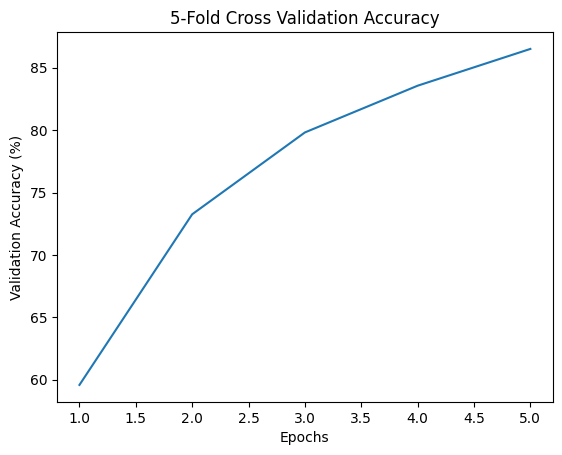

In [ ]:
rot_arr = np.array([tensor.cpu().numpy() for tensor in rot_val_accs])
np.save('/content/rot.npy', rot_arr)
epochs = [1,2,3,4,5]
plt.plot(epochs, rot_arr)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.title('5-Fold Cross Validation Accuracy')
plt.savefig('rot.pdf')
plt.show()

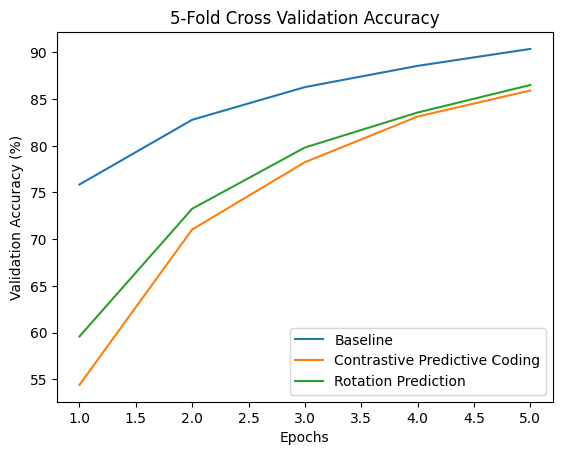

In [ ]:
baseline = np.load('/content/baseline.npy')
cpc = np.load('/content/cpc.npy')
rot = np.load('/content/rot.npy')

# Plot the data
plt.clf()
plt.plot(epochs, baseline, label='Baseline')
plt.plot(epochs, cpc, label='Contrastive Predictive Coding')
plt.plot(epochs, rot, label='Rotation Prediction')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.title('5-Fold Cross Validation Accuracy')
plt.savefig('results.pdf')

# Show the plot
plt.show()